<a href="https://colab.research.google.com/github/078373uhi/DAOTW_A1/blob/main/078373_DAOTW_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analytics on the Web - Assignment 1
### Michelle Paterson 078373

# Introduction



This report aims to investigate the 
relationship between weather and the number of traffic collisions in New York on a particular day in a bid to create datasets that could be fed into linear regression and deep neural network models.  The purpose of these models would be to predict the number of accidents on any given day to allow the emergency services to work more efficiently.  

It will explain the methodology used to create the data required which involved extracting and cleaning weather data, joining it back together again and then joining it with the accident data count.  

Furthermore, it will provide details of the results of analysing the data.  Analysis undertaken included plotting data and measuring correlations for different weather variables, observing plots of latitude and longitude to map the accidents and normalisation of data.  Data was plotted and checked for each individual year and it was investigated if moving day of week order changed the correlation with number of accidents.  Years were also plotted together to identify any annual patterns.  Where abnormalities appeared during analysis further investigation was undertaken in particular for 2020 data.

Finally, when the weather variables with the strongest correlation to number of accidents were selected, the data was prepared for extraction to enable Linear Regression and Deep Neural Network models to be run.

# Method




## Create weather data

The base data used in this task was obtained from BigQuery.  Initially annual weather information from the NOAA GSOD dataset was taken and collated together for 2012 to 2020 using the code below:

In [ ]:
create view `uhi-project-325420.Assignment1.weather_2012_to_2020` AS
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2012` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2013` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2014` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2015` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2016` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2017` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2018` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2019` WHERE stn="725060"
union all 
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `bigquery-public-data.noaa_gsod.gsod2020` WHERE stn="725060"
ORDER BY year, mo, da;

### Check weather data

Next this data had to be counted to ensure the correct number of entries.  

In [ ]:
select count(*) from `uhi-project-325420.Assignment1.weather_2012_to_2020`

However, this showed that there were too many entries.  There should have been 3,288 but there were actually 3,347 - an additional 59.  Therefore, further investigation was necessary.  The data was counted again but grouped by year.

In [ ]:
select count(*) from `uhi-project-325420.Assignment1.weather_2012_to_2020`
group by year

This showed that the error is in 2014 which had 424 entries instead of 365 – there are the extra 59.

###Clean data to merge and eliminate duplicates

To clean the data and deal with the duplicates, the data was split into two datasets.  The duplicates in one table and all the other entries in another.

In [ ]:
To create the duplicates:
create view `uhi-project-325420.Assignment1.weather_2012_to_2020_duplicates` AS
SELECT * FROM (
  SELECT *, COUNT(1) OVER(PARTITION BY date) dup_count
  FROM `uhi-project-325420.Assignment1.weather_2012_to_2020`
)
WHERE dup_count > 1

To create the data with no duplicates:
create view `uhi-project-325420.Assignment1.weather_2012_to_2020_exc_dup` AS
SELECT * FROM (
  SELECT *, COUNT(1) OVER(PARTITION BY date) dup_count
  FROM `uhi-project-325420.Assignment1.weather_2012_to_2020`
)
WHERE dup_count < 2

Next the data was exported as a csv and opened in google sheets.  There, rather than choose one of the duplicates to keep, functions were written to split the difference between the two values for each date to give a new value.  Where there was a choice between a ‘sensible’ looking value and an error type or null value like 9999.9 the sensible looking one was selected.  As there was no indication of which duplicate in a pair was correct this was felt to be the most accurate way of resolving it.  When the duplicates were merged to give just 59 entries they were imported into bigquery again as a table.

This data was then combined with a view created of the weather data excluding duplicates to make one final set of data. This created some problems as a number of columns had changed type during cleaning and were reluctant to join with the rest of the data.  

In [ ]:
create view `uhi-project-325420.Assignment1.weather_2012_to_2020_dup_clean` AS
SELECT DATE(CAST(year AS Int64), CAST(mo AS Int64), CAST(da AS Int64)) as date, year, mo, da, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog
FROM `uhi-project-325420.Assignment1.weather_data_2012_to_2020_dup_clean`
ORDER BY year, mo, da;




A number of columns has to be cast to enable them to join together.

In [ ]:
create view `uhi-project-325420.Assignment1.weather_2012_to_2020_final` AS
SELECT DATE(CAST(year AS INT64  ), CAST(mo AS INT64  ), CAST(da AS INT64  )) as date, CAST(year AS INT64  ) AS year, CAST(mo AS INT64) AS month, CAST(da AS INT64) AS day, temp, dewp, slp, visib, CAST(wdsp AS string) AS wdsp, CAST(mxpsd AS string) AS mxpsd, gust, max, min, prcp, sndp, CAST(fog AS string) AS fog  
FROM `uhi-project-325420.Assignment1.weather_2012_to_2020_exc_dup`
union all 
SELECT DATE(CAST(year AS INT64  ), CAST(mo AS INT64  ), CAST(da AS INT64  )) as date, CAST(year AS INT64  ) AS year, CAST(mo AS INT64) AS month, CAST(da AS INT64) AS day, temp, dewp, slp, visib, CAST(wdsp AS string) AS wdsp, CAST(mxpsd AS string) AS mxpsd, gust, max, min, prcp, sndp, CAST(fog AS string) AS fog
FROM `uhi-project-325420.Assignment1.weather_2012_to_2020_dup_clean`

### Check cleaned weather data 

In [ ]:
SELECT count(*) FROM `uhi-project-325420.Assignment1.weather_2012_to_2020_final`
group by year



This showed the correct number of entries.

## Create and check accident data

First a count of accidents by date was created and checked.

In [ ]:
create view `uhi-project-325420.Assignment1.accident_count`
as select cast(timestamp as DATE) as accident_date, count(cast(timestamp as DATE)) as num_accidents
from `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions` 
group by accident_date

SELECT * FROM `uhi-project-325420.Assignment1.accident_count`

This was then joined together with the previously created weather data.

In [ ]:
CREATE TABLE `uhi-project-325420.Assignment1.weather_collision_combined`
as SELECT day, year, month, date, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog, num_accidents FROM `uhi-project-325420.Assignment1.weather_2012_to_2020_final` AS weather, `uhi-project-325420.Assignment1.accident_count` AS accidents WHERE accidents.accident_date = weather.date

### Remove 2012 entries

It was found at this point that 2012 accident data only started in July and was not available for the entire year so the decision was taken to exlude 2012 from this exercise.  Another table only including 2013-2020 data was created and checked.

In [ ]:
CREATE TABLE `uhi-project-325420.Assignment1.weather_collision_combined_2013-2020`
as SELECT day, year, month, date, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog, num_accidents FROM `uhi-project-325420.Assignment1.weather_collision_combined` where year not in (2012)

SELECT * FROM `uhi-project-325420.Assignment1.weather_collision_combined_2013-2020` 

A day of the week column was added to the table to enable further sorting and analysis.

In [ ]:
create table `uhi-project-325420.Assignment1.weather_collision_combined_2013-2020b`
as select format_date("%u", date) as dayofweek, day, year, month, date, temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog, num_accidents
from `uhi-project-325420.Assignment1.weather_collision_combined_2013-2020`

Finally, the table was uploaded to github to be used in the analysis below.

"https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/collision_data_c.csv"

# Results and analysis


## Install and load required packages.

In [ ]:
install.packages(c("maps", "mapdata", "patchwork"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(maps)
library(mapdata)
library(lattice)
library(ggplot2)
library(tidyverse)
library(patchwork)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()



## Read in and check the collision weather data

In [ ]:
collision_data <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/collision_data_c.csv", stringsAsFactors=TRUE)

In [ ]:
head(collision_data)

dayofweek day year month date       temp dewp slp    visib wdsp mxpsd gust
1 2         1   2013 1     2013-01-01 38.0 25.6 1008.8 10.0  15.0 21.0  28.0
2 3         2   2013 1     2013-01-02 27.5 12.1 1013.4 10.0  12.4 15.9  25.1
3 4         3   2013 1     2013-01-03 21.8  7.8 1018.1 10.0   9.8 18.1  24.1
4 5         4   2013 1     2013-01-04 32.2 21.1 1015.2 10.0  11.3 22.0  29.9
5 6         5   2013 1     2013-01-05 37.3 24.5 1017.3 10.0  13.2 20.0  28.0
6 7         6   2013 1     2013-01-06 35.7 31.3 1019.7  9.8   5.9 15.0  20.0
  max  min  prcp sndp  fog num_accidents
1 41.0 33.1 0.00 999.9 0   381          
2 33.1 21.9 0.00 999.9 0   480          
3 28.9 16.0 0.00 999.9 0   549          
4 41.0 24.1 0.00 999.9 0   505          
5 42.1 30.9 0.00 999.9 0   389          
6 44.1 23.0 0.01 999.9 0   393

In [ ]:
summary(collision_data)

   dayofweek          day             year          month       
 Min.   :1.000   Min.   : 1.00   Min.   :2013   Min.   : 1.000  
 1st Qu.:2.000   1st Qu.: 8.00   1st Qu.:2015   1st Qu.: 4.000  
 Median :4.000   Median :16.00   Median :2016   Median : 7.000  
 Mean   :3.999   Mean   :15.73   Mean   :2017   Mean   : 6.523  
 3rd Qu.:6.000   3rd Qu.:23.00   3rd Qu.:2019   3rd Qu.:10.000  
 Max.   :7.000   Max.   :31.00   Max.   :2020   Max.   :12.000  
                                                                
         date           temp            dewp               slp         
 2013-01-01:   1   Min.   : 5.80   Min.   :   -6.70   Min.   :  989.1  
 2013-01-02:   1   1st Qu.:40.90   1st Qu.:   32.40   1st Qu.: 1012.1  
 2013-01-03:   1   Median :52.10   Median :   45.30   Median : 1016.7  
 2013-01-04:   1   Mean   :51.72   Mean   :   47.78   Mean   : 1022.9  
 2013-01-05:   1   3rd Qu.:63.98   3rd Qu.:   58.80   3rd Qu.: 1021.8  
 2013-01-06:   1   Max.   :77.60   Max.   : 9999

## Analysis of data


### Day of the week

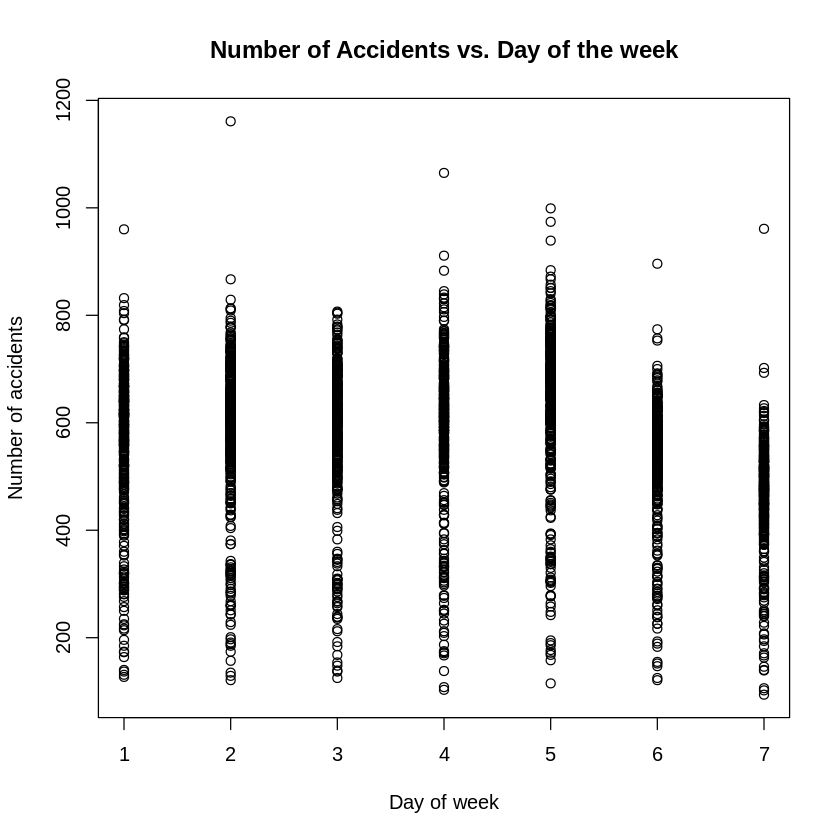

In [ ]:
plot(collision_data$dayofweek, collision_data$num_accidents, main="Number of Accidents vs. Day of the week", xlab = "Day of week", ylab = "Number of accidents")

In [ ]:
cor(collision_data$dayofweek, collision_data$num_accidents)

[1] -0.1892515

This shows something of a linear pattern from day 1 to 5 but then drops down on days 6 and 7.  There is not a particularly strong correlation between day of the week and number of collisions.  It does not appear that changing which day is day 1 would be particularly beneficial here though this will be tested further on.



### Date

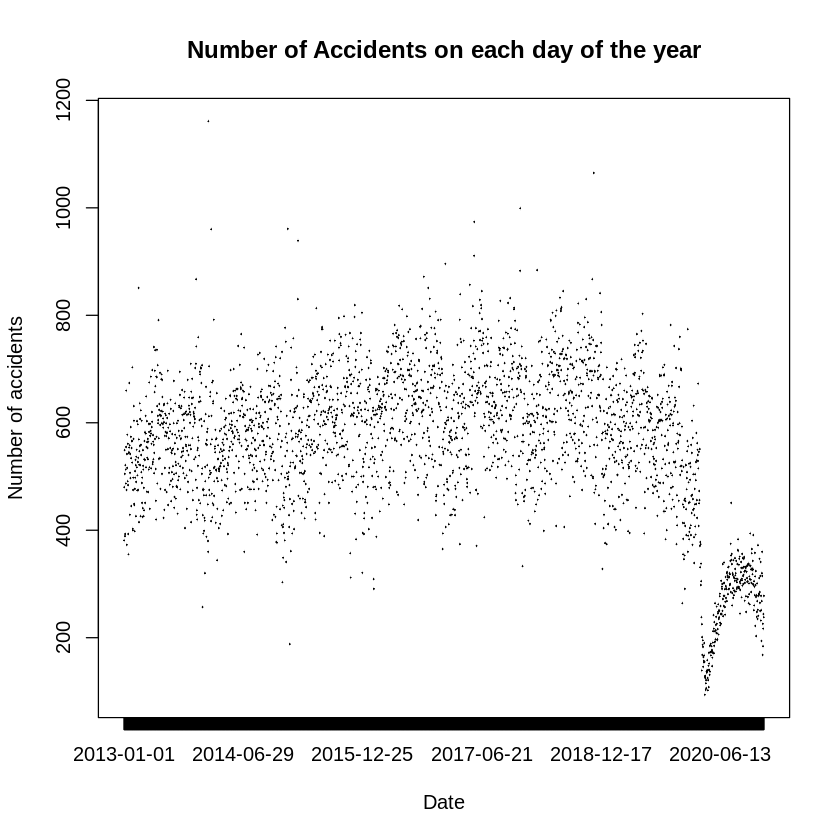

In [ ]:
plot(collision_data$date, collision_data$num_accidents, main="Number of Accidents on each day of the year", xlab = "Date", ylab = "Number of accidents")

This is the data for all collisions from 2013 to 2020.  This is the first sign that something is clearly amiss in 2020.  Between 2013 and 2019 a similar pattern can be seen with an overall slightly increasing amount of accidents but in 2020 the numbers are much lower and the pattern over the year differs.



### Year

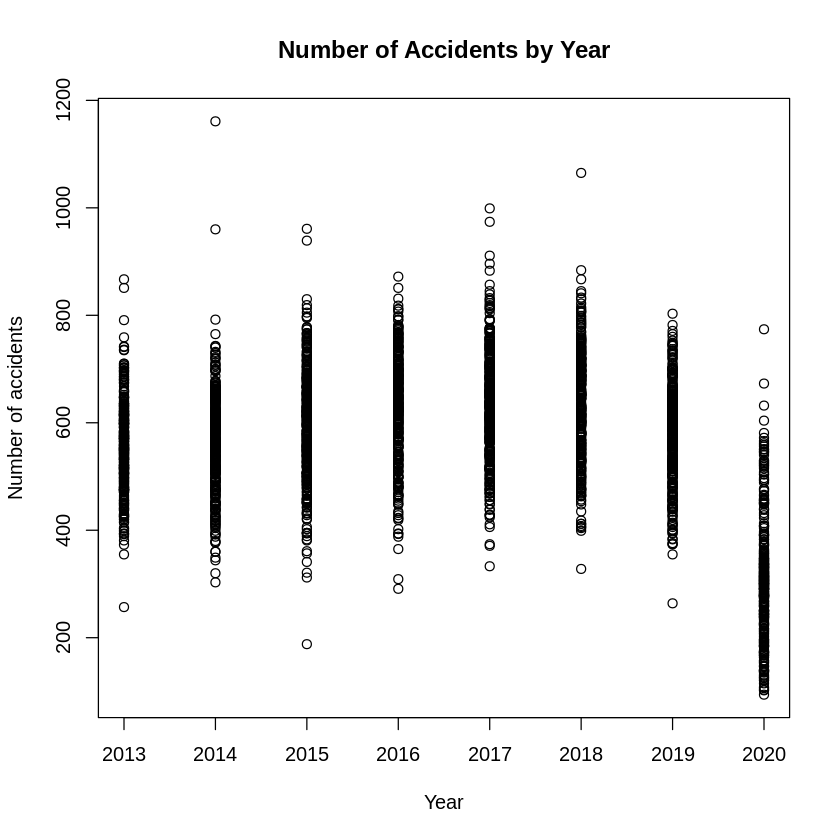

In [ ]:
plot(collision_data$year, collision_data$num_accidents, main="Number of Accidents by Year", xlab = "Year", ylab = "Number of accidents")

This provides further evidence of the problem of 2020 as seen in the previous plot.  There is a considerable drop in the number of accidents compared to all other years.  It is likely that this is due to the Covid-19 lockdown and this is considered further on in this report.



### Temperature

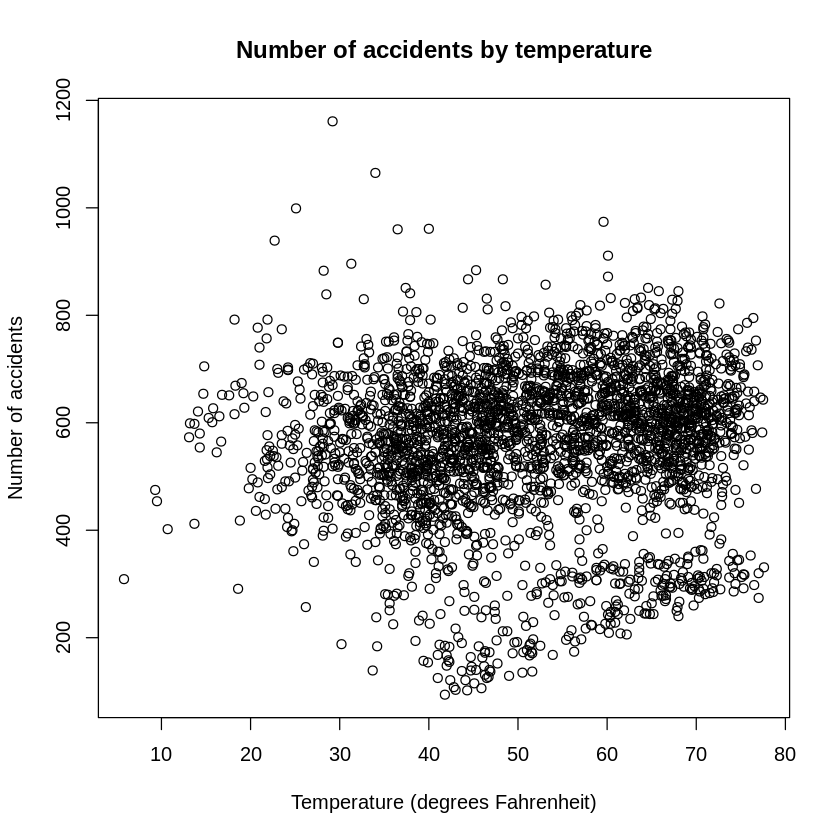

In [ ]:
plot(collision_data$temp, collision_data$num_accidents, main = "Number of accidents by temperature", xlab = "Temperature (degrees Fahrenheit)", ylab = "Number of accidents")

This plot of number of accidenst vs temperature looks loosely linear however the following correlation is not strong.

In [ ]:
cor(collision_data$temp, collision_data$num_accidents)

[1] 0.07995083

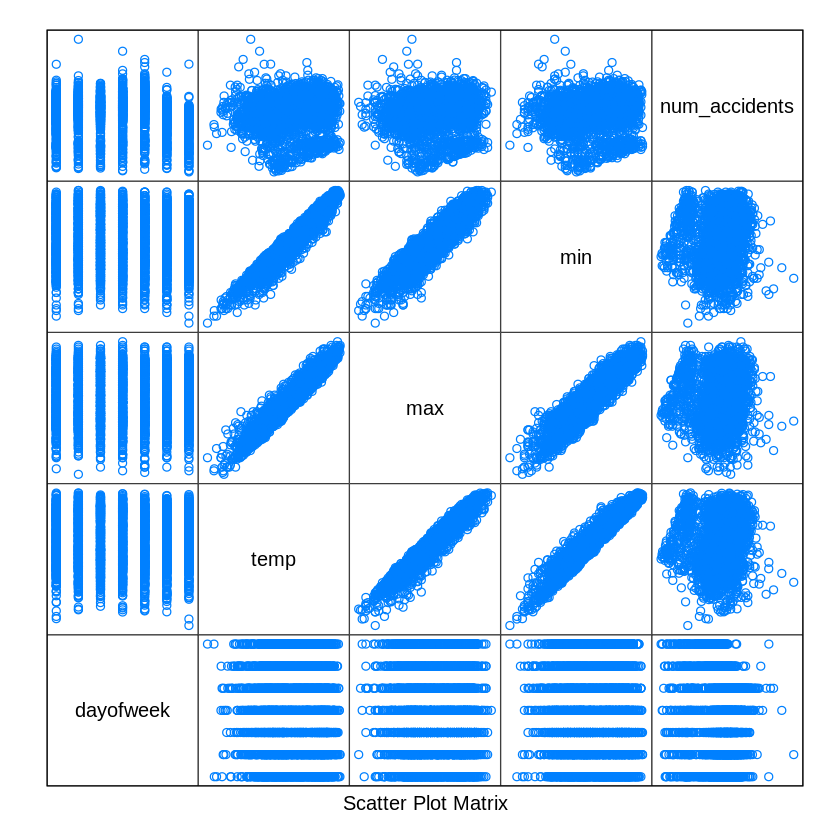

In [ ]:
splom(~ collision_data[,c(1,6, 13, 14,18)], groups=NULL, data=collision_data,
axis.line.tck=0, axis.text.alpha=0)

### Precipitation

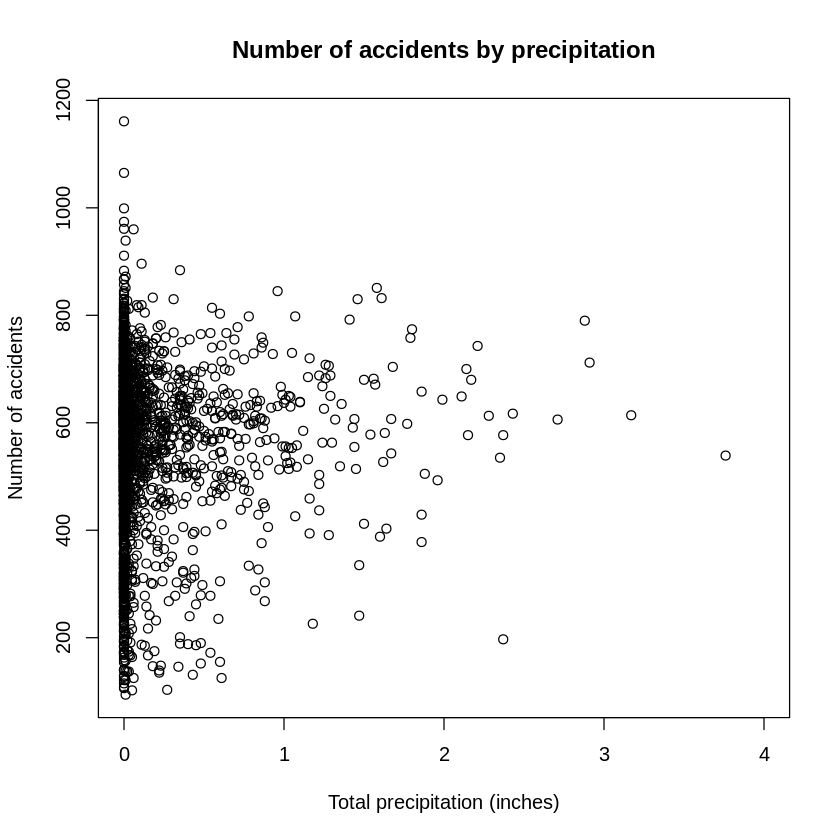

In [ ]:
plot(collision_data$prcp, collision_data$num_accidents, main = "Number of accidents by precipitation", xlim=c(0,4), xlab = "Total precipitation (inches)", ylab = "Number of accidents")

In [ ]:
cor(collision_data$prcp, collision_data$num_accidents)

[1] -0.0200219

There are a number of outliers in this which represent missing data but they are exluded from the plot to allow a better view of the rest of the data.  There appears to be no real pattern here and the correlation is very weak but to check, the outliers will be changed to 0 and the plot and correlation checked again.

In [ ]:
prcpdata <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/collision_data_c.csv", stringsAsFactors=TRUE)

In [ ]:
prcpdata$prcp[prcpdata$prcp == 99.99] <- 0

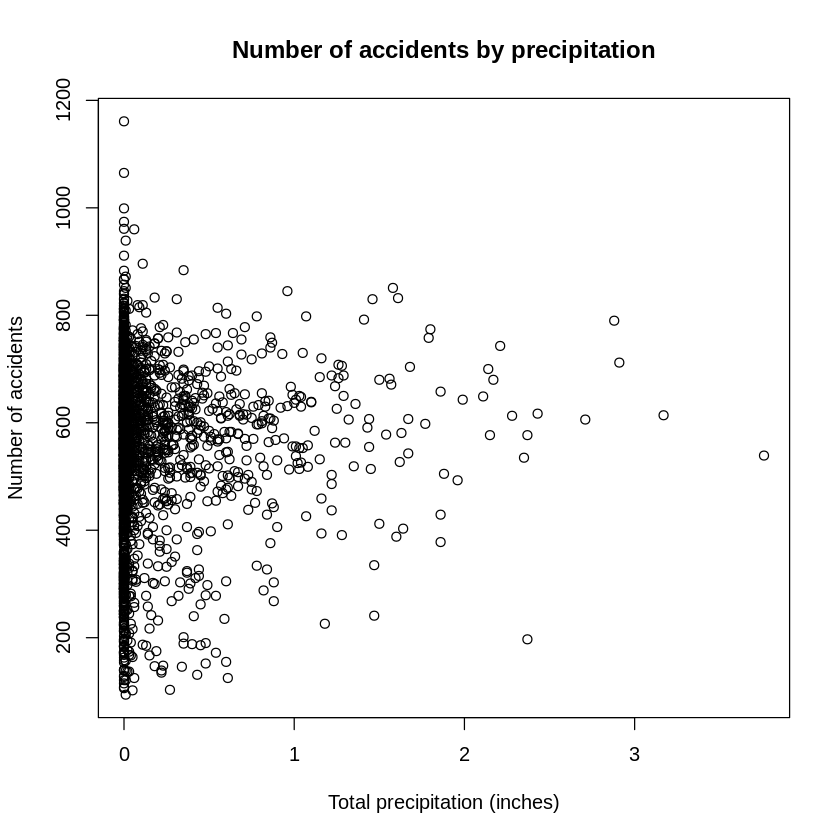

In [ ]:
plot(prcpdata$prcp, prcpdata$num_accidents, main = "Number of accidents by precipitation", xlab = "Total precipitation (inches)", ylab = "Number of accidents")

In [ ]:
cor(prcpdata$prcp, prcpdata$num_accidents)

[1] 0.01959933

This does not show any better correlation between precipitation levels and number of accidents.

### Wind speed

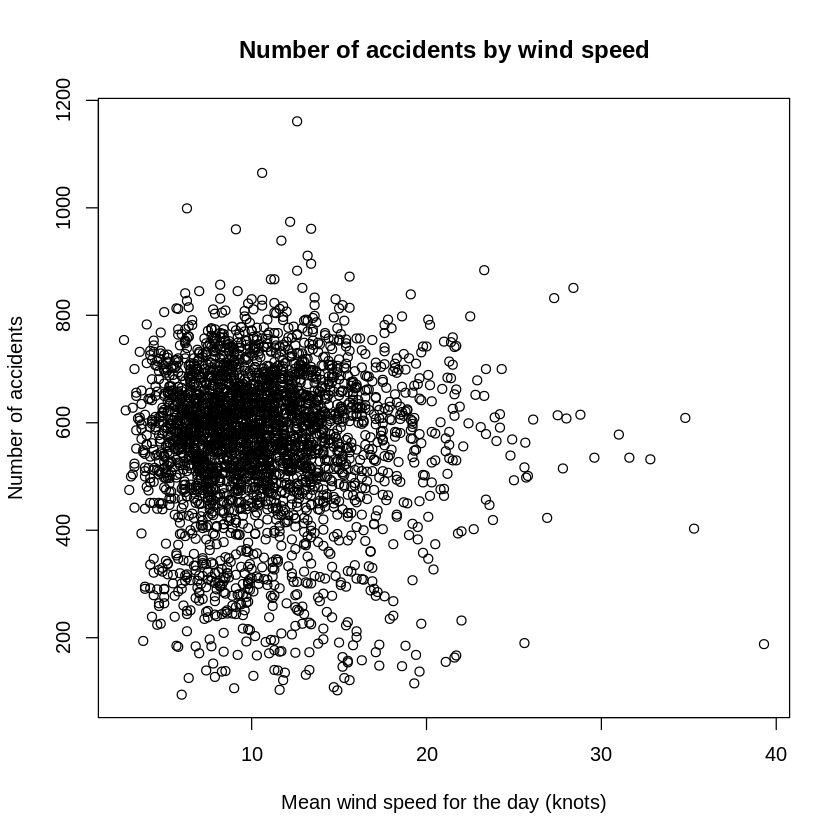

In [ ]:
plot(collision_data$wdsp, collision_data$num_accidents, main = "Number of accidents by wind speed", xlab = "Mean wind speed for the day (knots)", ylab = "Number of accidents")

Wind speed appears to have very little correlation with accidents.


In [ ]:
cor(collision_data$wdsp, collision_data$num_accidents)

[1] -0.01616789

### Dew Point

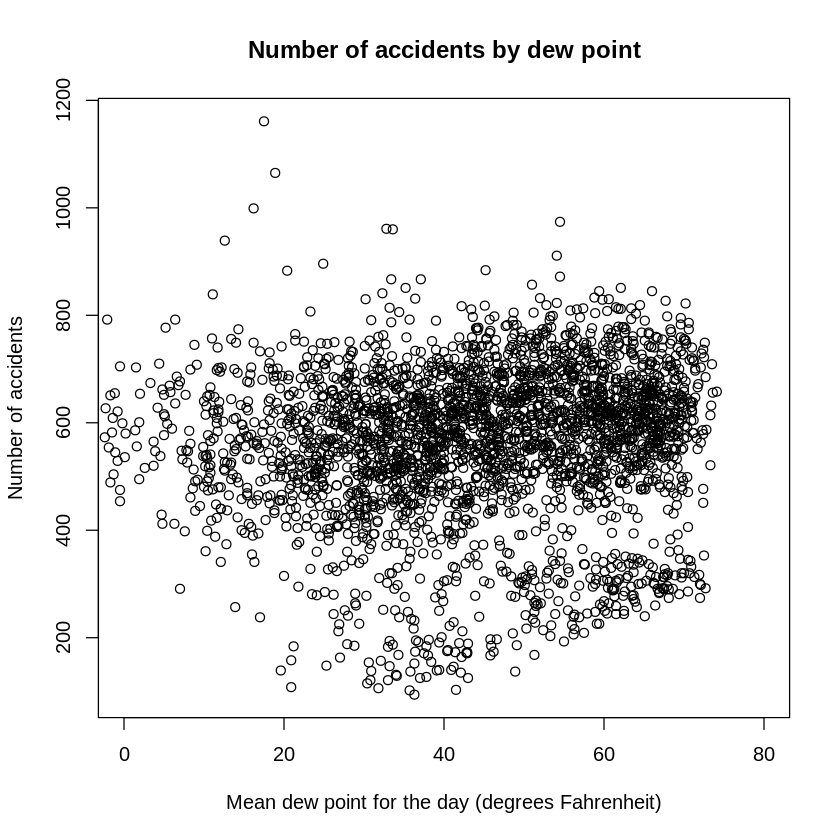

In [ ]:
plot(collision_data$dewp, collision_data$num_accidents, main = "Number of accidents by dew point", xlim = c(0, 80), xlab = "Mean dew point for the day (degrees Fahrenheit)", ylab = "Number of accidents")

In [ ]:
cor(collision_data$dewp, collision_data$num_accidents)

[1] 0.01561002

The plot for dew point appears to be vaguely linear but the correlation with accidents is low.



### Sea level pressure

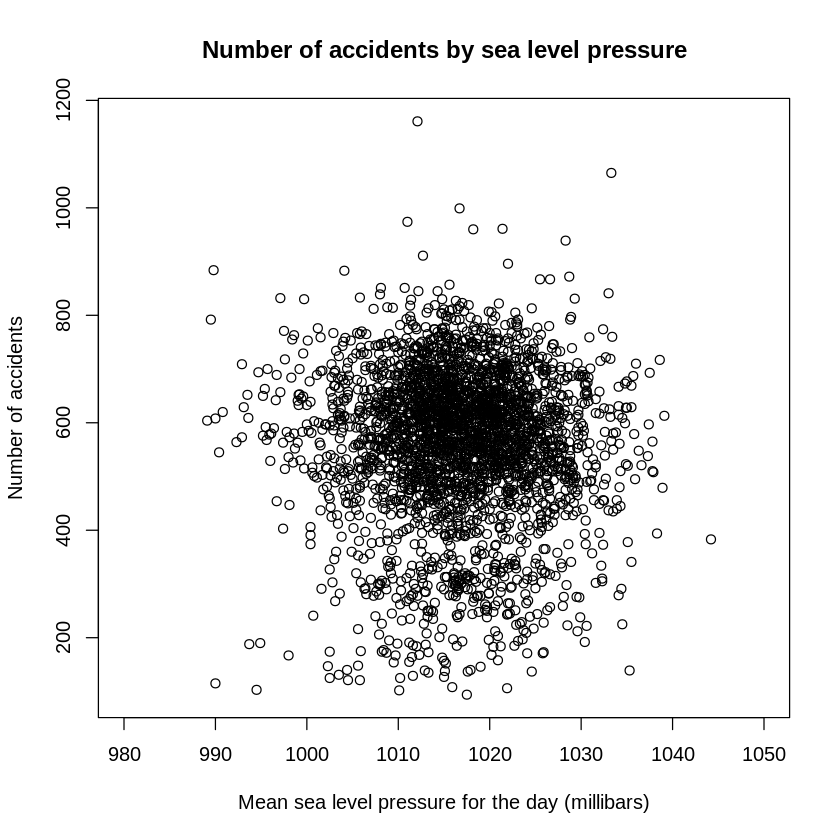

In [ ]:
plot(collision_data$slp, collision_data$num_accidents, main = "Number of accidents by sea level pressure", xlim = c(980, 1050),xlab = "Mean sea level pressure for the day (millibars)", ylab = "Number of accidents")

In [ ]:
cor(collision_data$slp, collision_data$num_accidents)

[1] -0.02701766

There appears to be little correlation between sea level pressure and number of accidents.



### Visibility

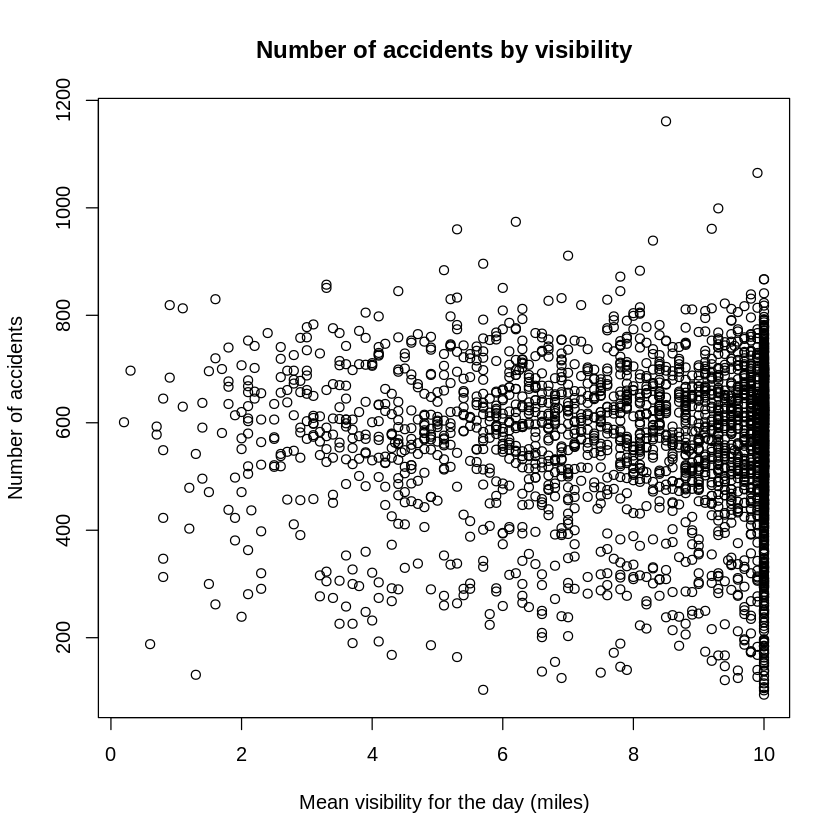

In [ ]:
plot(collision_data$visib, collision_data$num_accidents, main = "Number of accidents by visibility", xlab = "Mean visibility for the day (miles)", ylab = "Number of accidents")

In [ ]:
cor(collision_data$visib, collision_data$num_accidents)

[1] -0.03696777

Visibility appears to have little correlation with accidents.



### Snow Depth

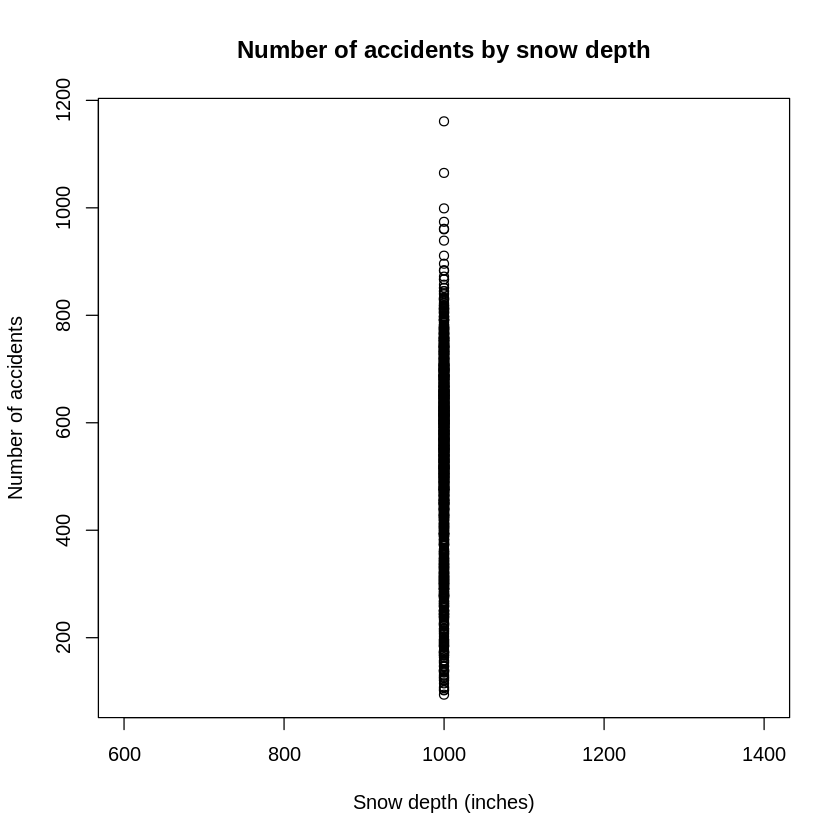

In [ ]:
plot(collision_data$sndp, collision_data$num_accidents, main = "Number of accidents by snow depth", xlab = "Snow depth (inches)", ylab = "Number of accidents")

The snow depth data does not look correct; for snow depth 999.99 represents missing data.  It appears that the snow depth data is incomplete and will therefore will not be included further. 



### Fog

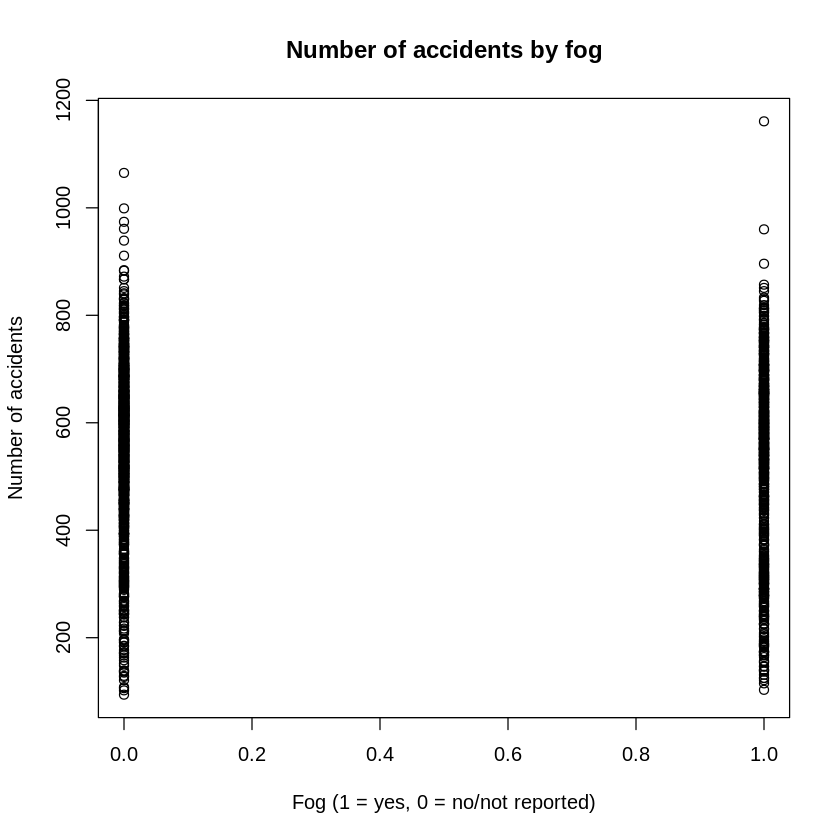

In [ ]:
plot(collision_data$fog, collision_data$num_accidents, main = "Number of accidents by fog", xlab = "Fog (1 = yes, 0 = no/not reported)", ylab = "Number of accidents")

In [ ]:
cor(collision_data$fog, collision_data$num_accidents)

[1] -0.1183426

## Check plots by year



### 2013 plots and summaries

In [ ]:
collision_data$date[0:365]

[1] 2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06
  [7] 2013-01-07 2013-01-08 2013-01-09 2013-01-10 2013-01-11 2013-01-12
 [13] 2013-01-13 2013-01-14 2013-01-15 2013-01-16 2013-01-17 2013-01-18
 [19] 2013-01-19 2013-01-20 2013-01-21 2013-01-22 2013-01-23 2013-01-24
 [25] 2013-01-25 2013-01-26 2013-01-27 2013-01-28 2013-01-29 2013-01-30
 [31] 2013-01-31 2013-02-01 2013-02-02 2013-02-03 2013-02-04 2013-02-05
 [37] 2013-02-06 2013-02-07 2013-02-08 2013-02-09 2013-02-10 2013-02-11
 [43] 2013-02-12 2013-02-13 2013-02-14 2013-02-15 2013-02-16 2013-02-17
 [49] 2013-02-18 2013-02-19 2013-02-20 2013-02-21 2013-02-22 2013-02-23
 [55] 2013-02-24 2013-02-25 2013-02-26 2013-02-27 2013-02-28 2013-03-01
 [61] 2013-03-02 2013-03-03 2013-03-04 2013-03-05 2013-03-06 2013-03-07
 [67] 2013-03-08 2013-03-09 2013-03-10 2013-03-11 2013-03-12 2013-03-13
 [73] 2013-03-14 2013-03-15 2013-03-16 2013-03-17 2013-03-18 2013-03-19
 [79] 2013-03-20 2013-03-21 2013-03-22 2013-03-23 2013-03-24 2013-03-25
 [85] 2013-03-26 2013-03-27 2013-03-28 2013-03-29 2013-03-30 2013-03-31
 [91] 2013-04-01 2013-04-02 2013-04-03 2013-04-04 2013-04-05 2013-04-06
 [97] 2013-04-07 2013-04-08 2013-04-09 2013-04-10 2013-04-11 2013-04-12
[103] 2013-04-13 2013-04-14 2013-04-15 2013-04-16 2013-04-17 2013-04-18
[109] 2013-04-19 2013-04-20 2013-04-21 2013-04-22 2013-04-23 2013-04-24
[115] 2013-04-25 2013-04-26 2013-04-27 2013-04-28 2013-04-29 2013-04-30
[121] 2013-05-01 2013-05-02 2013-05-03 2013-05-04 2013-05-05 2013-05-06
[127] 2013-05-07 2013-05-08 2013-05-09 2013-05-10 2013-05-11 2013-05-12
[133] 2013-05-13 2013-05-14 2013-05-15 2013-05-16 2013-05-17 2013-05-18
[139] 2013-05-19 2013-05-20 2013-05-21 2013-05-22 2013-05-23 2013-05-24
[145] 2013-05-25 2013-05-26 2013-05-27 2013-05-28 2013-05-29 2013-05-30
[151] 2013-05-31 2013-06-01 2013-06-02 2013-06-03 2013-06-04 2013-06-05
[157] 2013-06-06 2013-06-07 2013-06-08 2013-06-09 2013-06-10 2013-06-11
[163] 2013-06-12 2013-06-13 2013-06-14 2013-06-15 2013-06-16 2013-06-17
[169] 2013-06-18 2013-06-19 2013-06-20 2013-06-21 2013-06-22 2013-06-23
[175] 2013-06-24 2013-06-25 2013-06-26 2013-06-27 2013-06-28 2013-06-29
[181] 2013-06-30 2013-07-01 2013-07-02 2013-07-03 2013-07-04 2013-07-05
[187] 2013-07-06 2013-07-07 2013-07-08 2013-07-09 2013-07-10 2013-07-11
[193] 2013-07-12 2013-07-13 2013-07-14 2013-07-15 2013-07-16 2013-07-17
[199] 2013-07-18 2013-07-19 2013-07-20 2013-07-21 2013-07-22 2013-07-23
[205] 2013-07-24 2013-07-25 2013-07-26 2013-07-27 2013-07-28 2013-07-29
[211] 2013-07-30 2013-07-31 2013-08-01 2013-08-02 2013-08-03 2013-08-04
[217] 2013-08-05 2013-08-06 2013-08-07 2013-08-08 2013-08-09 2013-08-10
[223] 2013-08-11 2013-08-12 2013-08-13 2013-08-14 2013-08-15 2013-08-16
[229] 2013-08-17 2013-08-18 2013-08-19 2013-08-20 2013-08-21 2013-08-22
[235] 2013-08-23 2013-08-24 2013-08-25 2013-08-26 2013-08-27 2013-08-28
[241] 2013-08-29 2013-08-30 2013-08-31 2013-09-01 2013-09-02 2013-09-03
[247] 2013-09-04 2013-09-05 2013-09-06 2013-09-07 2013-09-08 2013-09-09
[253] 2013-09-10 2013-09-11 2013-09-12 2013-09-13 2013-09-14 2013-09-15
[259] 2013-09-16 2013-09-17 2013-09-18 2013-09-19 2013-09-20 2013-09-21
[265] 2013-09-22 2013-09-23 2013-09-24 2013-09-25 2013-09-26 2013-09-27
[271] 2013-09-28 2013-09-29 2013-09-30 2013-10-01 2013-10-02 2013-10-03
[277] 2013-10-04 2013-10-05 2013-10-06 2013-10-07 2013-10-08 2013-10-09
[283] 2013-10-10 2013-10-11 2013-10-12 2013-10-13 2013-10-14 2013-10-15
[289] 2013-10-16 2013-10-17 2013-10-18 2013-10-19 2013-10-20 2013-10-21
[295] 2013-10-22 2013-10-23 2013-10-24 2013-10-25 2013-10-26 2013-10-27
[301] 2013-10-28 2013-10-29 2013-10-30 2013-10-31 2013-11-01 2013-11-02
[307] 2013-11-03 2013-11-04 2013-11-05 2013-11-06 2013-11-07 2013-11-08
[313] 2013-11-09 2013-11-10 2013-11-11 2013-11-12 2013-11-13 2013-11-14
[319] 2013-11-15 2013-11-16 2013-11-17 2013-11-18 2013-11-19 2013-11-20
[325] 2013-11-21 2013-11-22 2013-11-23 2013-11-24 2013-11-25 2013-11-26
[331] 2013-11-27 2013-11-28 2013-11-29 201

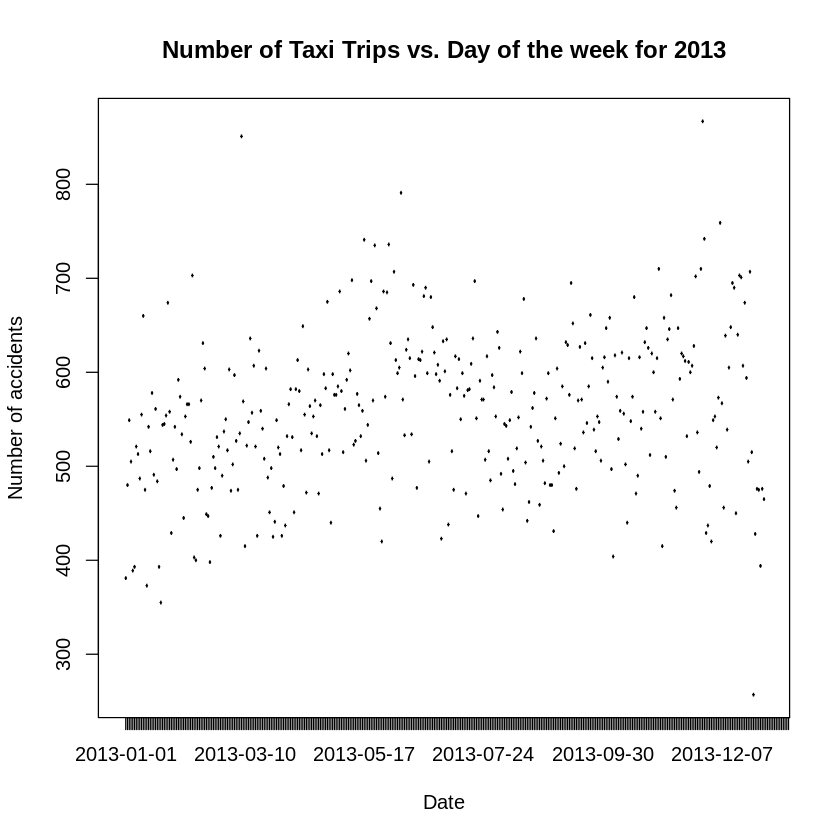

In [ ]:
plot(collision_data$date[0:365], collision_data$num_accidents[0:365], main="Number of Taxi Trips vs. Day of the week for 2013", xlim=c(0, 365), xlab = "Date", ylab = "Number of accidents")

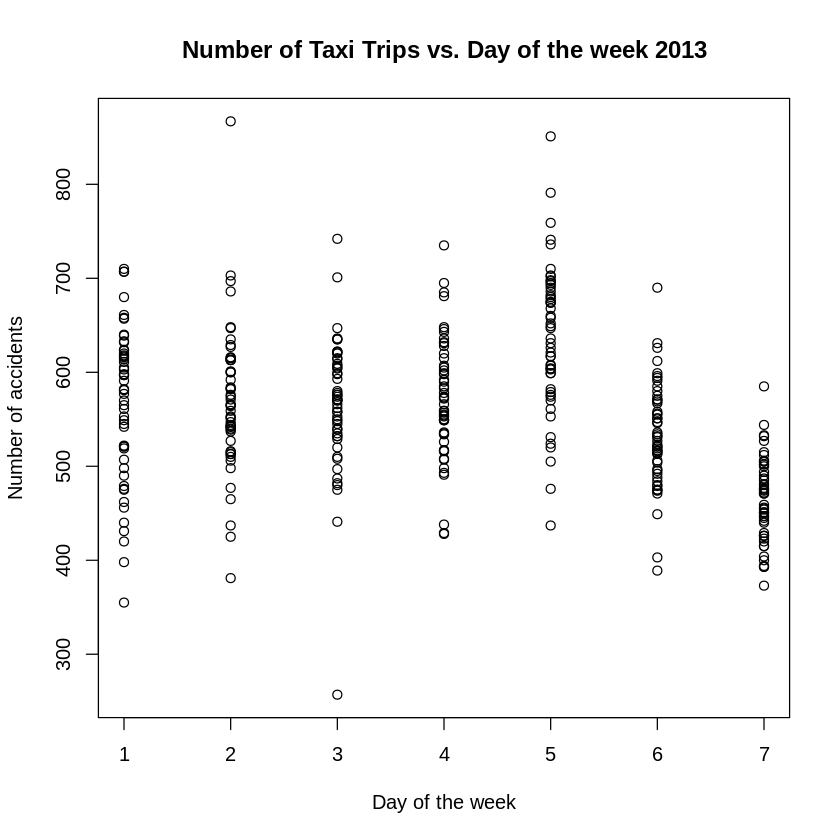

In [ ]:
plot(collision_data$dayofweek[0:365], collision_data$num_accidents[0:365], main="Number of Taxi Trips vs. Day of the week 2013", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[0:365])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  257.0   505.0   558.0   558.2   613.0   867.0 

There appears to be some seasonal variablity in the 2013 data and plotting by day of the week shows a small number of odd outliers both high and low.



### 2014 plots and summaries

In [ ]:
collision_data$date[366:730]

[1] 2014-01-01 2014-01-02 2014-01-03 2014-01-04 2014-01-05 2014-01-06
  [7] 2014-01-07 2014-01-08 2014-01-09 2014-01-10 2014-01-11 2014-01-12
 [13] 2014-01-13 2014-01-14 2014-01-15 2014-01-16 2014-01-17 2014-01-18
 [19] 2014-01-19 2014-01-20 2014-01-21 2014-01-22 2014-01-23 2014-01-24
 [25] 2014-01-25 2014-01-26 2014-01-27 2014-01-28 2014-01-29 2014-01-30
 [31] 2014-01-31 2014-02-01 2014-02-02 2014-02-03 2014-02-04 2014-02-05
 [37] 2014-02-06 2014-02-07 2014-02-08 2014-02-09 2014-02-10 2014-02-11
 [43] 2014-02-12 2014-02-13 2014-02-14 2014-02-15 2014-02-16 2014-02-17
 [49] 2014-02-18 2014-02-19 2014-02-20 2014-02-21 2014-02-22 2014-02-23
 [55] 2014-02-24 2014-02-25 2014-02-26 2014-02-27 2014-02-28 2014-03-01
 [61] 2014-03-02 2014-03-03 2014-03-04 2014-03-05 2014-03-06 2014-03-07
 [67] 2014-03-08 2014-03-09 2014-03-10 2014-03-11 2014-03-12 2014-03-13
 [73] 2014-03-14 2014-03-15 2014-03-16 2014-03-17 2014-03-18 2014-03-19
 [79] 2014-03-20 2014-03-21 2014-03-22 2014-03-23 2014-03-24 2014-03-25
 [85] 2014-03-26 2014-03-27 2014-03-28 2014-03-29 2014-03-30 2014-03-31
 [91] 2014-04-01 2014-04-02 2014-04-03 2014-04-04 2014-04-05 2014-04-06
 [97] 2014-04-07 2014-04-08 2014-04-09 2014-04-10 2014-04-11 2014-04-12
[103] 2014-04-13 2014-04-14 2014-04-15 2014-04-16 2014-04-17 2014-04-18
[109] 2014-04-19 2014-04-20 2014-04-21 2014-04-22 2014-04-23 2014-04-24
[115] 2014-04-25 2014-04-26 2014-04-27 2014-04-28 2014-04-29 2014-04-30
[121] 2014-05-01 2014-05-02 2014-05-03 2014-05-04 2014-05-05 2014-05-06
[127] 2014-05-07 2014-05-08 2014-05-09 2014-05-10 2014-05-11 2014-05-12
[133] 2014-05-13 2014-05-14 2014-05-15 2014-05-16 2014-05-17 2014-05-18
[139] 2014-05-19 2014-05-20 2014-05-21 2014-05-22 2014-05-23 2014-05-24
[145] 2014-05-25 2014-05-26 2014-05-27 2014-05-28 2014-05-29 2014-05-30
[151] 2014-05-31 2014-06-01 2014-06-02 2014-06-03 2014-06-04 2014-06-05
[157] 2014-06-06 2014-06-07 2014-06-08 2014-06-09 2014-06-10 2014-06-11
[163] 2014-06-12 2014-06-13 2014-06-14 2014-06-15 2014-06-16 2014-06-17
[169] 2014-06-18 2014-06-19 2014-06-20 2014-06-21 2014-06-22 2014-06-23
[175] 2014-06-24 2014-06-25 2014-06-26 2014-06-27 2014-06-28 2014-06-29
[181] 2014-06-30 2014-07-01 2014-07-02 2014-07-03 2014-07-04 2014-07-05
[187] 2014-07-06 2014-07-07 2014-07-08 2014-07-09 2014-07-10 2014-07-11
[193] 2014-07-12 2014-07-13 2014-07-14 2014-07-15 2014-07-16 2014-07-17
[199] 2014-07-18 2014-07-19 2014-07-20 2014-07-21 2014-07-22 2014-07-23
[205] 2014-07-24 2014-07-25 2014-07-26 2014-07-27 2014-07-28 2014-07-29
[211] 2014-07-30 2014-07-31 2014-08-01 2014-08-02 2014-08-03 2014-08-04
[217] 2014-08-05 2014-08-06 2014-08-07 2014-08-08 2014-08-09 2014-08-10
[223] 2014-08-11 2014-08-12 2014-08-13 2014-08-14 2014-08-15 2014-08-16
[229] 2014-08-17 2014-08-18 2014-08-19 2014-08-20 2014-08-21 2014-08-22
[235] 2014-08-23 2014-08-24 2014-08-25 2014-08-26 2014-08-27 2014-08-28
[241] 2014-08-29 2014-08-30 2014-08-31 2014-09-01 2014-09-02 2014-09-03
[247] 2014-09-04 2014-09-05 2014-09-06 2014-09-07 2014-09-08 2014-09-09
[253] 2014-09-10 2014-09-11 2014-09-12 2014-09-13 2014-09-14 2014-09-15
[259] 2014-09-16 2014-09-17 2014-09-18 2014-09-19 2014-09-20 2014-09-21
[265] 2014-09-22 2014-09-23 2014-09-24 2014-09-25 2014-09-26 2014-09-27
[271] 2014-09-28 2014-09-29 2014-09-30 2014-10-01 2014-10-02 2014-10-03
[277] 2014-10-04 2014-10-05 2014-10-06 2014-10-07 2014-10-08 2014-10-09
[283] 2014-10-10 2014-10-11 2014-10-12 2014-10-13 2014-10-14 2014-10-15
[289] 2014-10-16 2014-10-17 2014-10-18 2014-10-19 2014-10-20 2014-10-21
[295] 2014-10-22 2014-10-23 2014-10-24 2014-10-25 2014-10-26 2014-10-27
[301] 2014-10-28 2014-10-29 2014-10-30 2014-10-31 2014-11-01 2014-11-02
[307] 2014-11-03 2014-11-04 2014-11-05 2014-11-06 2014-11-07 2014-11-08
[313] 2014-11-09 2014-11-10 2014-11-11 2014-11-12 2014-11-13 2014-11-14
[319] 2014-11-15 2014-11-16 2014-11-17 2014-11-18 2014-11-19 2014-11-20
[325] 2014-11-21 2014-11-22 2014-11-23 2014-11-24 2014-11-25 2014-11-26
[331] 2014-11-27 2014-11-28 2014-11-29 201

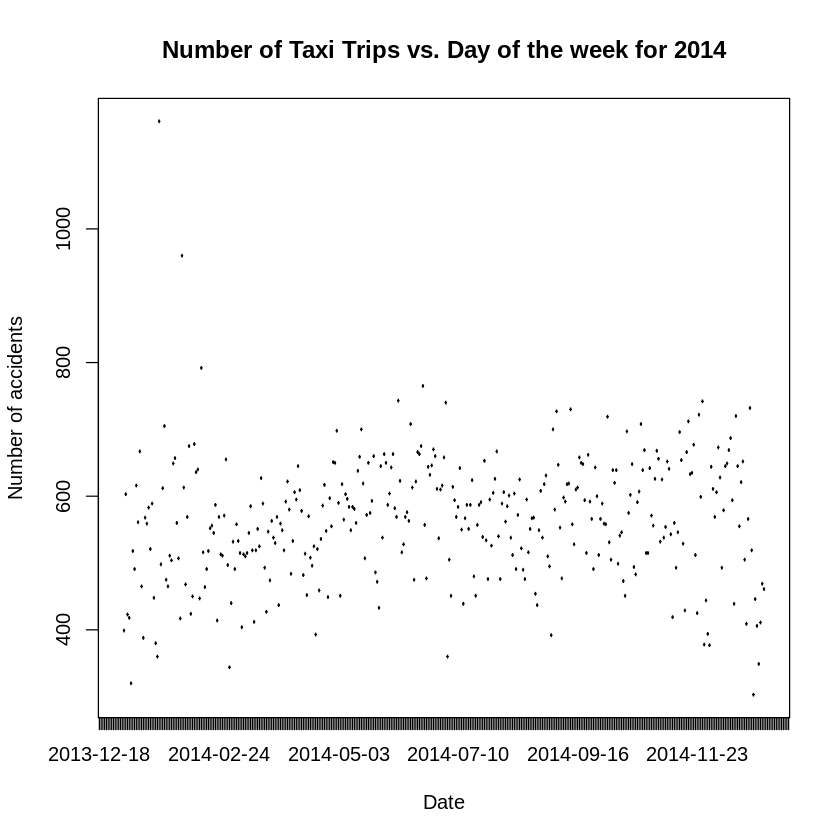

In [ ]:
plot(collision_data$date[366:730], collision_data$num_accidents[366:730], main="Number of Taxi Trips vs. Day of the week for 2014", xlim=c(366, 730), xlab = "Date", ylab = "Number of accidents")

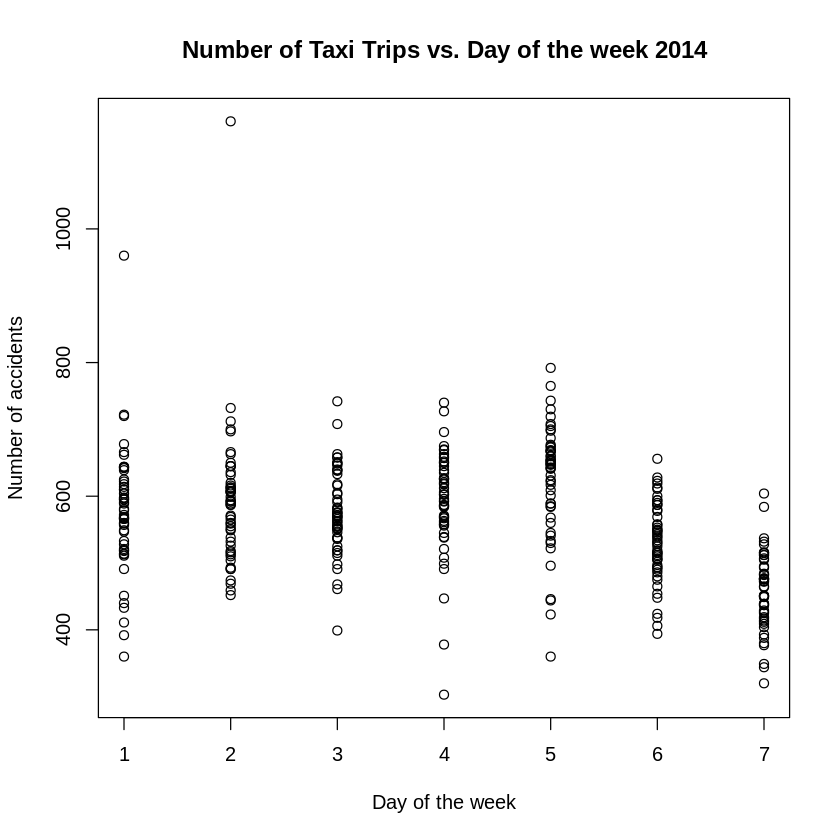

In [ ]:
plot(collision_data$dayofweek[366:730], collision_data$num_accidents[366:730], main="Number of Taxi Trips vs. Day of the week 2014", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[366:730])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  303.0   510.0   568.0   564.5   623.0  1161.0 

There is a similar seasonal variablity in the 2014 data and plotting by day of the week also shows a small number of mostly high outliers.



### 2015 plots and summaries

In [ ]:
collision_data$date[731:1095]

[1] 2015-01-01 2015-01-02 2015-01-03 2015-01-04 2015-01-05 2015-01-06
  [7] 2015-01-07 2015-01-08 2015-01-09 2015-01-10 2015-01-11 2015-01-12
 [13] 2015-01-13 2015-01-14 2015-01-15 2015-01-16 2015-01-17 2015-01-18
 [19] 2015-01-19 2015-01-20 2015-01-21 2015-01-22 2015-01-23 2015-01-24
 [25] 2015-01-25 2015-01-26 2015-01-27 2015-01-28 2015-01-29 2015-01-30
 [31] 2015-01-31 2015-02-01 2015-02-02 2015-02-03 2015-02-04 2015-02-05
 [37] 2015-02-06 2015-02-07 2015-02-08 2015-02-09 2015-02-10 2015-02-11
 [43] 2015-02-12 2015-02-13 2015-02-14 2015-02-15 2015-02-16 2015-02-17
 [49] 2015-02-18 2015-02-19 2015-02-20 2015-02-21 2015-02-22 2015-02-23
 [55] 2015-02-24 2015-02-25 2015-02-26 2015-02-27 2015-02-28 2015-03-01
 [61] 2015-03-02 2015-03-03 2015-03-04 2015-03-05 2015-03-06 2015-03-07
 [67] 2015-03-08 2015-03-09 2015-03-10 2015-03-11 2015-03-12 2015-03-13
 [73] 2015-03-14 2015-03-15 2015-03-16 2015-03-17 2015-03-18 2015-03-19
 [79] 2015-03-20 2015-03-21 2015-03-22 2015-03-23 2015-03-24 2015-03-25
 [85] 2015-03-26 2015-03-27 2015-03-28 2015-03-29 2015-03-30 2015-03-31
 [91] 2015-04-01 2015-04-02 2015-04-03 2015-04-04 2015-04-05 2015-04-06
 [97] 2015-04-07 2015-04-08 2015-04-09 2015-04-10 2015-04-11 2015-04-12
[103] 2015-04-13 2015-04-14 2015-04-15 2015-04-16 2015-04-17 2015-04-18
[109] 2015-04-19 2015-04-20 2015-04-21 2015-04-22 2015-04-23 2015-04-24
[115] 2015-04-25 2015-04-26 2015-04-27 2015-04-28 2015-04-29 2015-04-30
[121] 2015-05-01 2015-05-02 2015-05-03 2015-05-04 2015-05-05 2015-05-06
[127] 2015-05-07 2015-05-08 2015-05-09 2015-05-10 2015-05-11 2015-05-12
[133] 2015-05-13 2015-05-14 2015-05-15 2015-05-16 2015-05-17 2015-05-18
[139] 2015-05-19 2015-05-20 2015-05-21 2015-05-22 2015-05-23 2015-05-24
[145] 2015-05-25 2015-05-26 2015-05-27 2015-05-28 2015-05-29 2015-05-30
[151] 2015-05-31 2015-06-01 2015-06-02 2015-06-03 2015-06-04 2015-06-05
[157] 2015-06-06 2015-06-07 2015-06-08 2015-06-09 2015-06-10 2015-06-11
[163] 2015-06-12 2015-06-13 2015-06-14 2015-06-15 2015-06-16 2015-06-17
[169] 2015-06-18 2015-06-19 2015-06-20 2015-06-21 2015-06-22 2015-06-23
[175] 2015-06-24 2015-06-25 2015-06-26 2015-06-27 2015-06-28 2015-06-29
[181] 2015-06-30 2015-07-01 2015-07-02 2015-07-03 2015-07-04 2015-07-05
[187] 2015-07-06 2015-07-07 2015-07-08 2015-07-09 2015-07-10 2015-07-11
[193] 2015-07-12 2015-07-13 2015-07-14 2015-07-15 2015-07-16 2015-07-17
[199] 2015-07-18 2015-07-19 2015-07-20 2015-07-21 2015-07-22 2015-07-23
[205] 2015-07-24 2015-07-25 2015-07-26 2015-07-27 2015-07-28 2015-07-29
[211] 2015-07-30 2015-07-31 2015-08-01 2015-08-02 2015-08-03 2015-08-04
[217] 2015-08-05 2015-08-06 2015-08-07 2015-08-08 2015-08-09 2015-08-10
[223] 2015-08-11 2015-08-12 2015-08-13 2015-08-14 2015-08-15 2015-08-16
[229] 2015-08-17 2015-08-18 2015-08-19 2015-08-20 2015-08-21 2015-08-22
[235] 2015-08-23 2015-08-24 2015-08-25 2015-08-26 2015-08-27 2015-08-28
[241] 2015-08-29 2015-08-30 2015-08-31 2015-09-01 2015-09-02 2015-09-03
[247] 2015-09-04 2015-09-05 2015-09-06 2015-09-07 2015-09-08 2015-09-09
[253] 2015-09-10 2015-09-11 2015-09-12 2015-09-13 2015-09-14 2015-09-15
[259] 2015-09-16 2015-09-17 2015-09-18 2015-09-19 2015-09-20 2015-09-21
[265] 2015-09-22 2015-09-23 2015-09-24 2015-09-25 2015-09-26 2015-09-27
[271] 2015-09-28 2015-09-29 2015-09-30 2015-10-01 2015-10-02 2015-10-03
[277] 2015-10-04 2015-10-05 2015-10-06 2015-10-07 2015-10-08 2015-10-09
[283] 2015-10-10 2015-10-11 2015-10-12 2015-10-13 2015-10-14 2015-10-15
[289] 2015-10-16 2015-10-17 2015-10-18 2015-10-19 2015-10-20 2015-10-21
[295] 2015-10-22 2015-10-23 2015-10-24 2015-10-25 2015-10-26 2015-10-27
[301] 2015-10-28 2015-10-29 2015-10-30 2015-10-31 2015-11-01 2015-11-02
[307] 2015-11-03 2015-11-04 2015-11-05 2015-11-06 2015-11-07 2015-11-08
[313] 2015-11-09 2015-11-10 2015-11-11 2015-11-12 2015-11-13 2015-11-14
[319] 2015-11-15 2015-11-16 2015-11-17 2015-11-18 2015-11-19 2015-11-20
[325] 2015-11-21 2015-11-22 2015-11-23 2015-11-24 2015-11-25 2015-11-26
[331] 2015-11-27 2015-11-28 2015-11-29 201

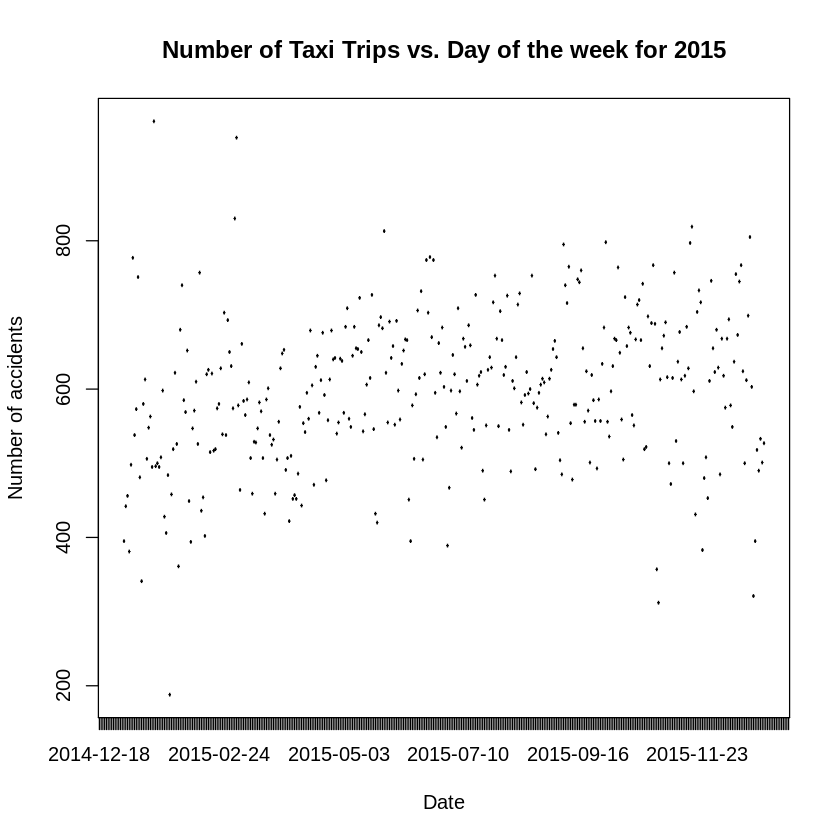

In [ ]:
plot(collision_data$date[731:1095], collision_data$num_accidents[731:1095], main="Number of Taxi Trips vs. Day of the week for 2015", xlim=c(731, 1095), xlab = "Date", ylab = "Number of accidents")

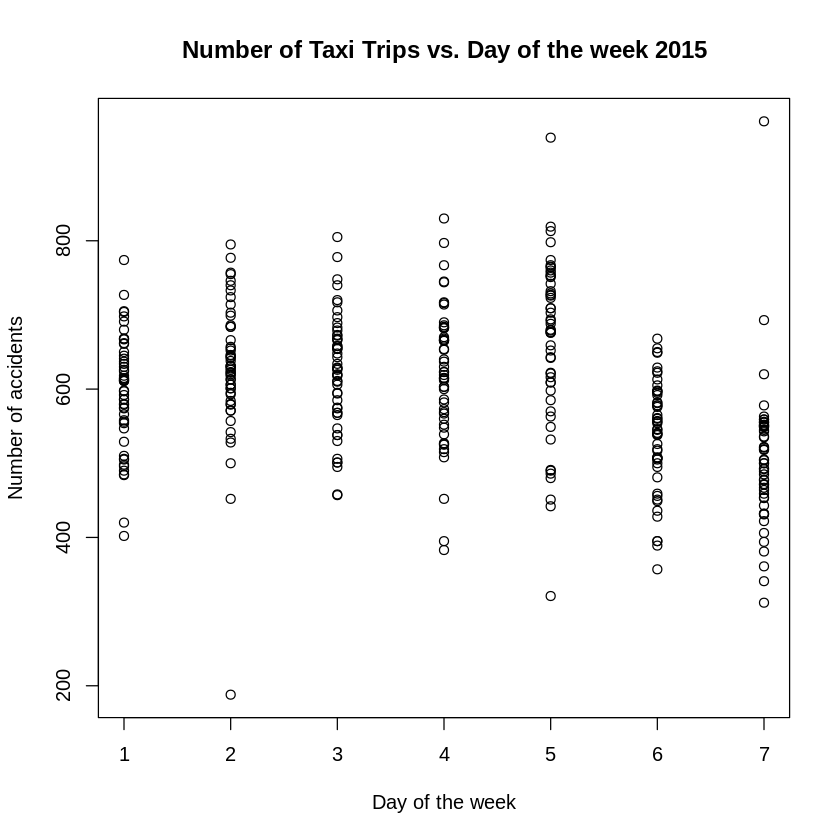

In [ ]:
plot(collision_data$dayofweek[731:1095], collision_data$num_accidents[731:1095], main="Number of Taxi Trips vs. Day of the week 2015", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[731:1095])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  188.0   532.0   601.0   596.4   666.0   961.0 

The seasonal variablity in the 2015 data is not as obvious as in the previous years though plotting by day of the week does show a similar small number of odd outliers both high and low.



### 2016 plots and summaries

In [ ]:
collision_data$date[1096:1461]

[1] 2016-01-01 2016-01-02 2016-01-03 2016-01-04 2016-01-05 2016-01-06
  [7] 2016-01-07 2016-01-08 2016-01-09 2016-01-10 2016-01-11 2016-01-12
 [13] 2016-01-13 2016-01-14 2016-01-15 2016-01-16 2016-01-17 2016-01-18
 [19] 2016-01-19 2016-01-20 2016-01-21 2016-01-22 2016-01-23 2016-01-24
 [25] 2016-01-25 2016-01-26 2016-01-27 2016-01-28 2016-01-29 2016-01-30
 [31] 2016-01-31 2016-02-01 2016-02-02 2016-02-03 2016-02-04 2016-02-05
 [37] 2016-02-06 2016-02-07 2016-02-08 2016-02-09 2016-02-10 2016-02-11
 [43] 2016-02-12 2016-02-13 2016-02-14 2016-02-15 2016-02-16 2016-02-17
 [49] 2016-02-18 2016-02-19 2016-02-20 2016-02-21 2016-02-22 2016-02-23
 [55] 2016-02-24 2016-02-25 2016-02-26 2016-02-27 2016-02-28 2016-02-29
 [61] 2016-03-01 2016-03-02 2016-03-03 2016-03-04 2016-03-05 2016-03-06
 [67] 2016-03-07 2016-03-08 2016-03-09 2016-03-10 2016-03-11 2016-03-12
 [73] 2016-03-13 2016-03-14 2016-03-15 2016-03-16 2016-03-17 2016-03-18
 [79] 2016-03-19 2016-03-20 2016-03-21 2016-03-22 2016-03-23 2016-03-24
 [85] 2016-03-25 2016-03-26 2016-03-27 2016-03-28 2016-03-29 2016-03-30
 [91] 2016-03-31 2016-04-01 2016-04-02 2016-04-03 2016-04-04 2016-04-05
 [97] 2016-04-06 2016-04-07 2016-04-08 2016-04-09 2016-04-10 2016-04-11
[103] 2016-04-12 2016-04-13 2016-04-14 2016-04-15 2016-04-16 2016-04-17
[109] 2016-04-18 2016-04-19 2016-04-20 2016-04-21 2016-04-22 2016-04-23
[115] 2016-04-24 2016-04-25 2016-04-26 2016-04-27 2016-04-28 2016-04-29
[121] 2016-04-30 2016-05-01 2016-05-02 2016-05-03 2016-05-04 2016-05-05
[127] 2016-05-06 2016-05-07 2016-05-08 2016-05-09 2016-05-10 2016-05-11
[133] 2016-05-12 2016-05-13 2016-05-14 2016-05-15 2016-05-16 2016-05-17
[139] 2016-05-18 2016-05-19 2016-05-20 2016-05-21 2016-05-22 2016-05-23
[145] 2016-05-24 2016-05-25 2016-05-26 2016-05-27 2016-05-28 2016-05-29
[151] 2016-05-30 2016-05-31 2016-06-01 2016-06-02 2016-06-03 2016-06-04
[157] 2016-06-05 2016-06-06 2016-06-07 2016-06-08 2016-06-09 2016-06-10
[163] 2016-06-11 2016-06-12 2016-06-13 2016-06-14 2016-06-15 2016-06-16
[169] 2016-06-17 2016-06-18 2016-06-19 2016-06-20 2016-06-21 2016-06-22
[175] 2016-06-23 2016-06-24 2016-06-25 2016-06-26 2016-06-27 2016-06-28
[181] 2016-06-29 2016-06-30 2016-07-01 2016-07-02 2016-07-03 2016-07-04
[187] 2016-07-05 2016-07-06 2016-07-07 2016-07-08 2016-07-09 2016-07-10
[193] 2016-07-11 2016-07-12 2016-07-13 2016-07-14 2016-07-15 2016-07-16
[199] 2016-07-17 2016-07-18 2016-07-19 2016-07-20 2016-07-21 2016-07-22
[205] 2016-07-23 2016-07-24 2016-07-25 2016-07-26 2016-07-27 2016-07-28
[211] 2016-07-29 2016-07-30 2016-07-31 2016-08-01 2016-08-02 2016-08-03
[217] 2016-08-04 2016-08-05 2016-08-06 2016-08-07 2016-08-08 2016-08-09
[223] 2016-08-10 2016-08-11 2016-08-12 2016-08-13 2016-08-14 2016-08-15
[229] 2016-08-16 2016-08-17 2016-08-18 2016-08-19 2016-08-20 2016-08-21
[235] 2016-08-22 2016-08-23 2016-08-24 2016-08-25 2016-08-26 2016-08-27
[241] 2016-08-28 2016-08-29 2016-08-30 2016-08-31 2016-09-01 2016-09-02
[247] 2016-09-03 2016-09-04 2016-09-05 2016-09-06 2016-09-07 2016-09-08
[253] 2016-09-09 2016-09-10 2016-09-11 2016-09-12 2016-09-13 2016-09-14
[259] 2016-09-15 2016-09-16 2016-09-17 2016-09-18 2016-09-19 2016-09-20
[265] 2016-09-21 2016-09-22 2016-09-23 2016-09-24 2016-09-25 2016-09-26
[271] 2016-09-27 2016-09-28 2016-09-29 2016-09-30 2016-10-01 2016-10-02
[277] 2016-10-03 2016-10-04 2016-10-05 2016-10-06 2016-10-07 2016-10-08
[283] 2016-10-09 2016-10-10 2016-10-11 2016-10-12 2016-10-13 2016-10-14
[289] 2016-10-15 2016-10-16 2016-10-17 2016-10-18 2016-10-19 2016-10-20
[295] 2016-10-21 2016-10-22 2016-10-23 2016-10-24 2016-10-25 2016-10-26
[301] 2016-10-27 2016-10-28 2016-10-29 2016-10-30 2016-10-31 2016-11-01
[307] 2016-11-02 2016-11-03 2016-11-04 2016-11-05 2016-11-06 2016-11-07
[313] 2016-11-08 2016-11-09 2016-11-10 2016-11-11 2016-11-12 2016-11-13
[319] 2016-11-14 2016-11-15 2016-11-16 2016-11-17 2016-11-18 2016-11-19
[325] 2016-11-20 2016-11-21 2016-11-22 2016-11-23 2016-11-24 2016-11-25
[331] 2016-11-26 2016-11-27 2016-11-28 201

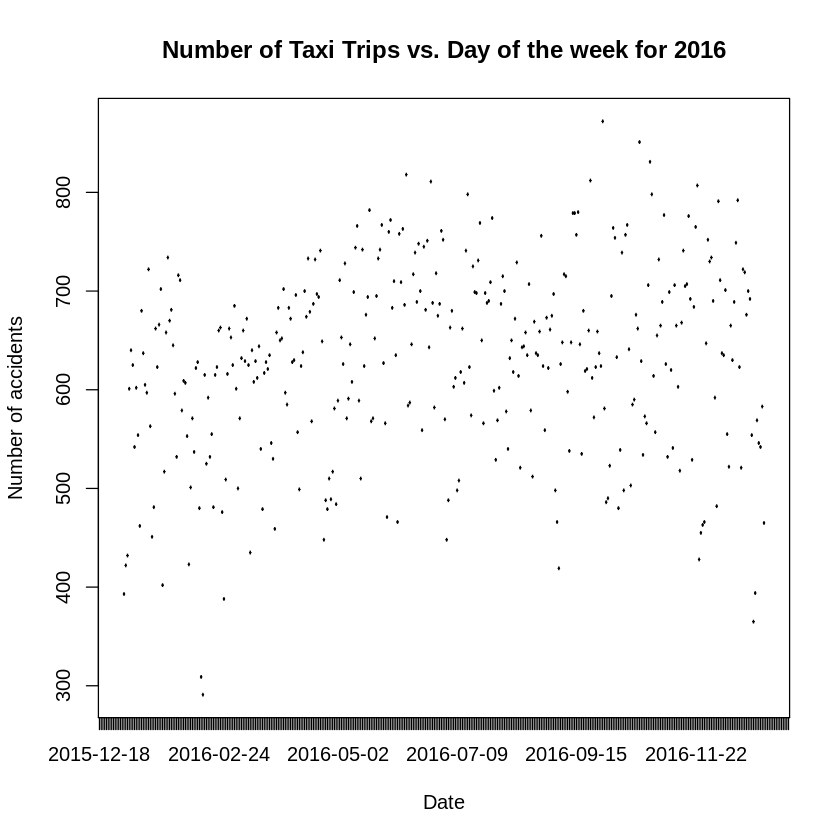

In [ ]:
plot(collision_data$date[1096:1461], collision_data$num_accidents[1096:1461], main="Number of Taxi Trips vs. Day of the week for 2016", xlim=c(1096, 1461), xlab = "Date", ylab = "Number of accidents")

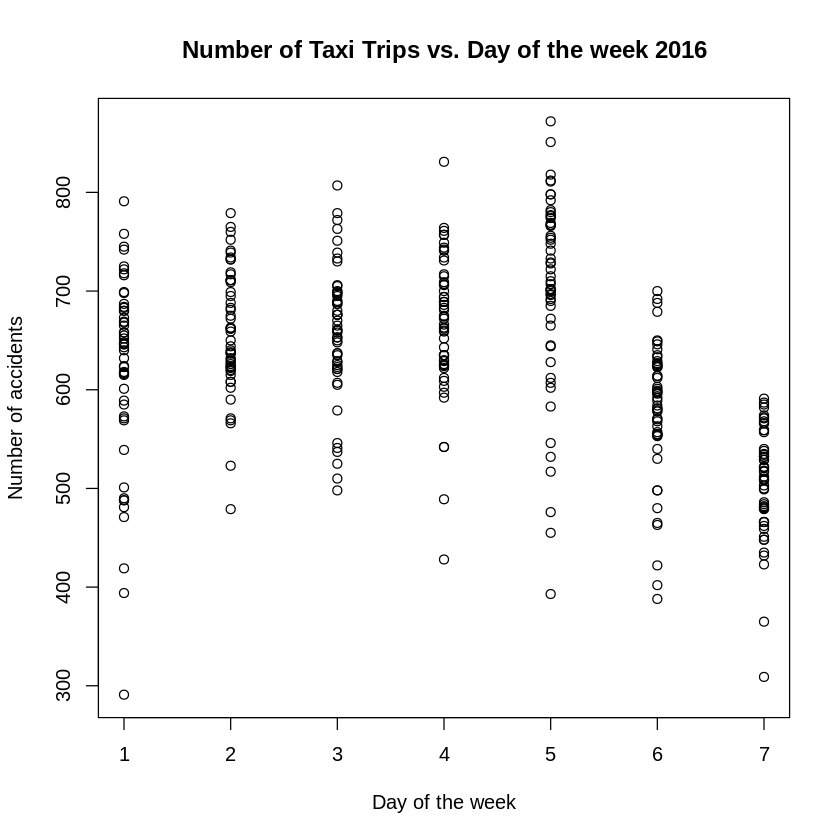

In [ ]:
plot(collision_data$dayofweek[1096:1461], collision_data$num_accidents[1096:1461], main="Number of Taxi Trips vs. Day of the week 2016", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[1096:1461])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  291.0   568.2   635.0   628.0   696.8   872.0 

2016 shows some seasonal variablity and plotting by day of the week shows only a few low outliers.



### 2017 Summary and plots

In [ ]:
collision_data$date[1462:1826]

[1] 2017-01-01 2017-01-02 2017-01-03 2017-01-04 2017-01-05 2017-01-06
  [7] 2017-01-07 2017-01-08 2017-01-09 2017-01-10 2017-01-11 2017-01-12
 [13] 2017-01-13 2017-01-14 2017-01-15 2017-01-16 2017-01-17 2017-01-18
 [19] 2017-01-19 2017-01-20 2017-01-21 2017-01-22 2017-01-23 2017-01-24
 [25] 2017-01-25 2017-01-26 2017-01-27 2017-01-28 2017-01-29 2017-01-30
 [31] 2017-01-31 2017-02-01 2017-02-02 2017-02-03 2017-02-04 2017-02-05
 [37] 2017-02-06 2017-02-07 2017-02-08 2017-02-09 2017-02-10 2017-02-11
 [43] 2017-02-12 2017-02-13 2017-02-14 2017-02-15 2017-02-16 2017-02-17
 [49] 2017-02-18 2017-02-19 2017-02-20 2017-02-21 2017-02-22 2017-02-23
 [55] 2017-02-24 2017-02-25 2017-02-26 2017-02-27 2017-02-28 2017-03-01
 [61] 2017-03-02 2017-03-03 2017-03-04 2017-03-05 2017-03-06 2017-03-07
 [67] 2017-03-08 2017-03-09 2017-03-10 2017-03-11 2017-03-12 2017-03-13
 [73] 2017-03-14 2017-03-15 2017-03-16 2017-03-17 2017-03-18 2017-03-19
 [79] 2017-03-20 2017-03-21 2017-03-22 2017-03-23 2017-03-24 2017-03-25
 [85] 2017-03-26 2017-03-27 2017-03-28 2017-03-29 2017-03-30 2017-03-31
 [91] 2017-04-01 2017-04-02 2017-04-03 2017-04-04 2017-04-05 2017-04-06
 [97] 2017-04-07 2017-04-08 2017-04-09 2017-04-10 2017-04-11 2017-04-12
[103] 2017-04-13 2017-04-14 2017-04-15 2017-04-16 2017-04-17 2017-04-18
[109] 2017-04-19 2017-04-20 2017-04-21 2017-04-22 2017-04-23 2017-04-24
[115] 2017-04-25 2017-04-26 2017-04-27 2017-04-28 2017-04-29 2017-04-30
[121] 2017-05-01 2017-05-02 2017-05-03 2017-05-04 2017-05-05 2017-05-06
[127] 2017-05-07 2017-05-08 2017-05-09 2017-05-10 2017-05-11 2017-05-12
[133] 2017-05-13 2017-05-14 2017-05-15 2017-05-16 2017-05-17 2017-05-18
[139] 2017-05-19 2017-05-20 2017-05-21 2017-05-22 2017-05-23 2017-05-24
[145] 2017-05-25 2017-05-26 2017-05-27 2017-05-28 2017-05-29 2017-05-30
[151] 2017-05-31 2017-06-01 2017-06-02 2017-06-03 2017-06-04 2017-06-05
[157] 2017-06-06 2017-06-07 2017-06-08 2017-06-09 2017-06-10 2017-06-11
[163] 2017-06-12 2017-06-13 2017-06-14 2017-06-15 2017-06-16 2017-06-17
[169] 2017-06-18 2017-06-19 2017-06-20 2017-06-21 2017-06-22 2017-06-23
[175] 2017-06-24 2017-06-25 2017-06-26 2017-06-27 2017-06-28 2017-06-29
[181] 2017-06-30 2017-07-01 2017-07-02 2017-07-03 2017-07-04 2017-07-05
[187] 2017-07-06 2017-07-07 2017-07-08 2017-07-09 2017-07-10 2017-07-11
[193] 2017-07-12 2017-07-13 2017-07-14 2017-07-15 2017-07-16 2017-07-17
[199] 2017-07-18 2017-07-19 2017-07-20 2017-07-21 2017-07-22 2017-07-23
[205] 2017-07-24 2017-07-25 2017-07-26 2017-07-27 2017-07-28 2017-07-29
[211] 2017-07-30 2017-07-31 2017-08-01 2017-08-02 2017-08-03 2017-08-04
[217] 2017-08-05 2017-08-06 2017-08-07 2017-08-08 2017-08-09 2017-08-10
[223] 2017-08-11 2017-08-12 2017-08-13 2017-08-14 2017-08-15 2017-08-16
[229] 2017-08-17 2017-08-18 2017-08-19 2017-08-20 2017-08-21 2017-08-22
[235] 2017-08-23 2017-08-24 2017-08-25 2017-08-26 2017-08-27 2017-08-28
[241] 2017-08-29 2017-08-30 2017-08-31 2017-09-01 2017-09-02 2017-09-03
[247] 2017-09-04 2017-09-05 2017-09-06 2017-09-07 2017-09-08 2017-09-09
[253] 2017-09-10 2017-09-11 2017-09-12 2017-09-13 2017-09-14 2017-09-15
[259] 2017-09-16 2017-09-17 2017-09-18 2017-09-19 2017-09-20 2017-09-21
[265] 2017-09-22 2017-09-23 2017-09-24 2017-09-25 2017-09-26 2017-09-27
[271] 2017-09-28 2017-09-29 2017-09-30 2017-10-01 2017-10-02 2017-10-03
[277] 2017-10-04 2017-10-05 2017-10-06 2017-10-07 2017-10-08 2017-10-09
[283] 2017-10-10 2017-10-11 2017-10-12 2017-10-13 2017-10-14 2017-10-15
[289] 2017-10-16 2017-10-17 2017-10-18 2017-10-19 2017-10-20 2017-10-21
[295] 2017-10-22 2017-10-23 2017-10-24 2017-10-25 2017-10-26 2017-10-27
[301] 2017-10-28 2017-10-29 2017-10-30 2017-10-31 2017-11-01 2017-11-02
[307] 2017-11-03 2017-11-04 2017-11-05 2017-11-06 2017-11-07 2017-11-08
[313] 2017-11-09 2017-11-10 2017-11-11 2017-11-12 2017-11-13 2017-11-14
[319] 2017-11-15 2017-11-16 2017-11-17 2017-11-18 2017-11-19 2017-11-20
[325] 2017-11-21 2017-11-22 2017-11-23 2017-11-24 2017-11-25 2017-11-26
[331] 2017-11-27 2017-11-28 2017-11-29 201

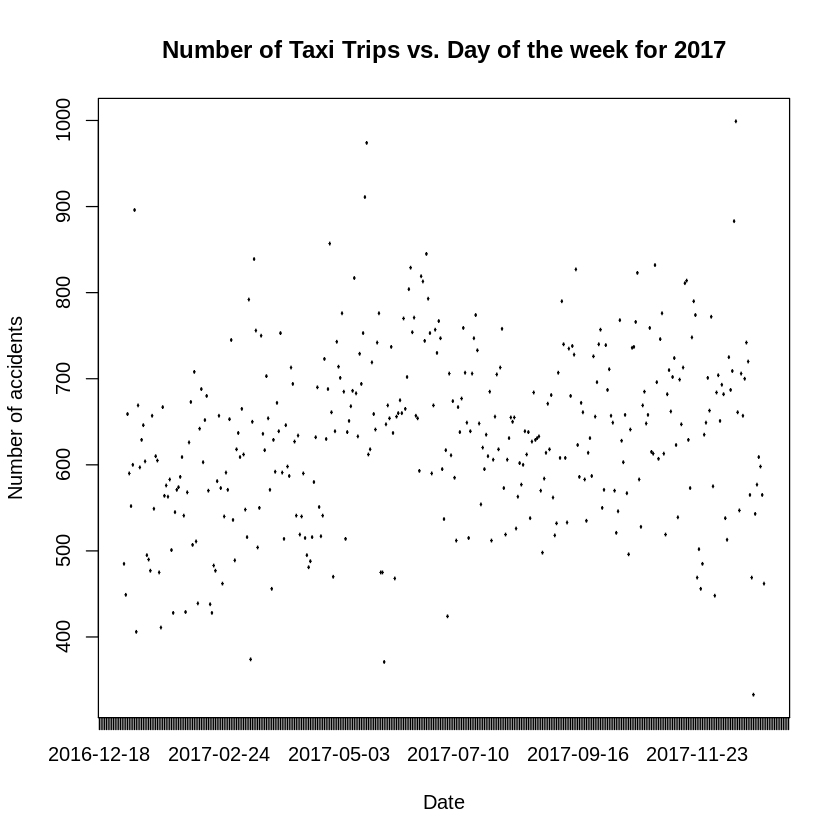

In [ ]:
plot(collision_data$date[1462:1826], collision_data$num_accidents[1462:1826], main="Number of Taxi Trips vs. Day of the week for 2017", xlim=c(1462, 1826), xlab = "Date", ylab = "Number of accidents")

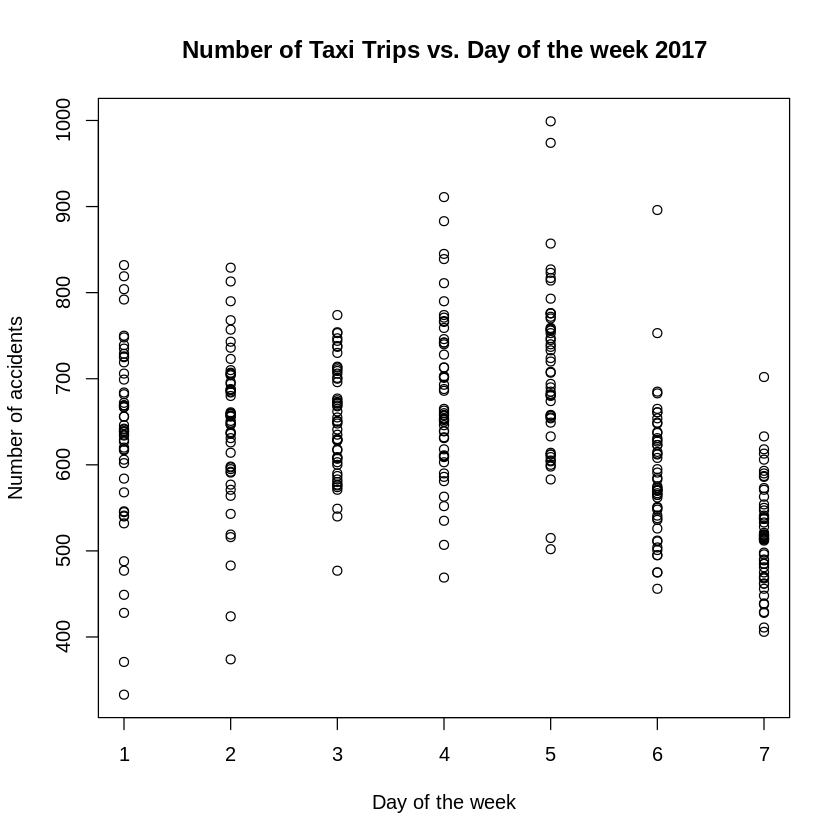

In [ ]:
plot(collision_data$dayofweek[1462:1826], collision_data$num_accidents[1462:1826], main="Number of Taxi Trips vs. Day of the week 2017", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[1462:1826])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  333.0   570.0   636.0   632.9   700.0   999.0 

The seasonal variablity in the 2017 data is less clear though plotting by day of the week shows a small number of odd outliers both high and low.



### 2018 plots and summary

In [ ]:
collision_data$date[1827:2191]

[1] 2018-01-01 2018-01-02 2018-01-03 2018-01-04 2018-01-05 2018-01-06
  [7] 2018-01-07 2018-01-08 2018-01-09 2018-01-10 2018-01-11 2018-01-12
 [13] 2018-01-13 2018-01-14 2018-01-15 2018-01-16 2018-01-17 2018-01-18
 [19] 2018-01-19 2018-01-20 2018-01-21 2018-01-22 2018-01-23 2018-01-24
 [25] 2018-01-25 2018-01-26 2018-01-27 2018-01-28 2018-01-29 2018-01-30
 [31] 2018-01-31 2018-02-01 2018-02-02 2018-02-03 2018-02-04 2018-02-05
 [37] 2018-02-06 2018-02-07 2018-02-08 2018-02-09 2018-02-10 2018-02-11
 [43] 2018-02-12 2018-02-13 2018-02-14 2018-02-15 2018-02-16 2018-02-17
 [49] 2018-02-18 2018-02-19 2018-02-20 2018-02-21 2018-02-22 2018-02-23
 [55] 2018-02-24 2018-02-25 2018-02-26 2018-02-27 2018-02-28 2018-03-01
 [61] 2018-03-02 2018-03-03 2018-03-04 2018-03-05 2018-03-06 2018-03-07
 [67] 2018-03-08 2018-03-09 2018-03-10 2018-03-11 2018-03-12 2018-03-13
 [73] 2018-03-14 2018-03-15 2018-03-16 2018-03-17 2018-03-18 2018-03-19
 [79] 2018-03-20 2018-03-21 2018-03-22 2018-03-23 2018-03-24 2018-03-25
 [85] 2018-03-26 2018-03-27 2018-03-28 2018-03-29 2018-03-30 2018-03-31
 [91] 2018-04-01 2018-04-02 2018-04-03 2018-04-04 2018-04-05 2018-04-06
 [97] 2018-04-07 2018-04-08 2018-04-09 2018-04-10 2018-04-11 2018-04-12
[103] 2018-04-13 2018-04-14 2018-04-15 2018-04-16 2018-04-17 2018-04-18
[109] 2018-04-19 2018-04-20 2018-04-21 2018-04-22 2018-04-23 2018-04-24
[115] 2018-04-25 2018-04-26 2018-04-27 2018-04-28 2018-04-29 2018-04-30
[121] 2018-05-01 2018-05-02 2018-05-03 2018-05-04 2018-05-05 2018-05-06
[127] 2018-05-07 2018-05-08 2018-05-09 2018-05-10 2018-05-11 2018-05-12
[133] 2018-05-13 2018-05-14 2018-05-15 2018-05-16 2018-05-17 2018-05-18
[139] 2018-05-19 2018-05-20 2018-05-21 2018-05-22 2018-05-23 2018-05-24
[145] 2018-05-25 2018-05-26 2018-05-27 2018-05-28 2018-05-29 2018-05-30
[151] 2018-05-31 2018-06-01 2018-06-02 2018-06-03 2018-06-04 2018-06-05
[157] 2018-06-06 2018-06-07 2018-06-08 2018-06-09 2018-06-10 2018-06-11
[163] 2018-06-12 2018-06-13 2018-06-14 2018-06-15 2018-06-16 2018-06-17
[169] 2018-06-18 2018-06-19 2018-06-20 2018-06-21 2018-06-22 2018-06-23
[175] 2018-06-24 2018-06-25 2018-06-26 2018-06-27 2018-06-28 2018-06-29
[181] 2018-06-30 2018-07-01 2018-07-02 2018-07-03 2018-07-04 2018-07-05
[187] 2018-07-06 2018-07-07 2018-07-08 2018-07-09 2018-07-10 2018-07-11
[193] 2018-07-12 2018-07-13 2018-07-14 2018-07-15 2018-07-16 2018-07-17
[199] 2018-07-18 2018-07-19 2018-07-20 2018-07-21 2018-07-22 2018-07-23
[205] 2018-07-24 2018-07-25 2018-07-26 2018-07-27 2018-07-28 2018-07-29
[211] 2018-07-30 2018-07-31 2018-08-01 2018-08-02 2018-08-03 2018-08-04
[217] 2018-08-05 2018-08-06 2018-08-07 2018-08-08 2018-08-09 2018-08-10
[223] 2018-08-11 2018-08-12 2018-08-13 2018-08-14 2018-08-15 2018-08-16
[229] 2018-08-17 2018-08-18 2018-08-19 2018-08-20 2018-08-21 2018-08-22
[235] 2018-08-23 2018-08-24 2018-08-25 2018-08-26 2018-08-27 2018-08-28
[241] 2018-08-29 2018-08-30 2018-08-31 2018-09-01 2018-09-02 2018-09-03
[247] 2018-09-04 2018-09-05 2018-09-06 2018-09-07 2018-09-08 2018-09-09
[253] 2018-09-10 2018-09-11 2018-09-12 2018-09-13 2018-09-14 2018-09-15
[259] 2018-09-16 2018-09-17 2018-09-18 2018-09-19 2018-09-20 2018-09-21
[265] 2018-09-22 2018-09-23 2018-09-24 2018-09-25 2018-09-26 2018-09-27
[271] 2018-09-28 2018-09-29 2018-09-30 2018-10-01 2018-10-02 2018-10-03
[277] 2018-10-04 2018-10-05 2018-10-06 2018-10-07 2018-10-08 2018-10-09
[283] 2018-10-10 2018-10-11 2018-10-12 2018-10-13 2018-10-14 2018-10-15
[289] 2018-10-16 2018-10-17 2018-10-18 2018-10-19 2018-10-20 2018-10-21
[295] 2018-10-22 2018-10-23 2018-10-24 2018-10-25 2018-10-26 2018-10-27
[301] 2018-10-28 2018-10-29 2018-10-30 2018-10-31 2018-11-01 2018-11-02
[307] 2018-11-03 2018-11-04 2018-11-05 2018-11-06 2018-11-07 2018-11-08
[313] 2018-11-09 2018-11-10 2018-11-11 2018-11-12 2018-11-13 2018-11-14
[319] 2018-11-15 2018-11-16 2018-11-17 2018-11-18 2018-11-19 2018-11-20
[325] 2018-11-21 2018-11-22 2018-11-23 2018-11-24 2018-11-25 2018-11-26
[331] 2018-11-27 2018-11-28 2018-11-29 201

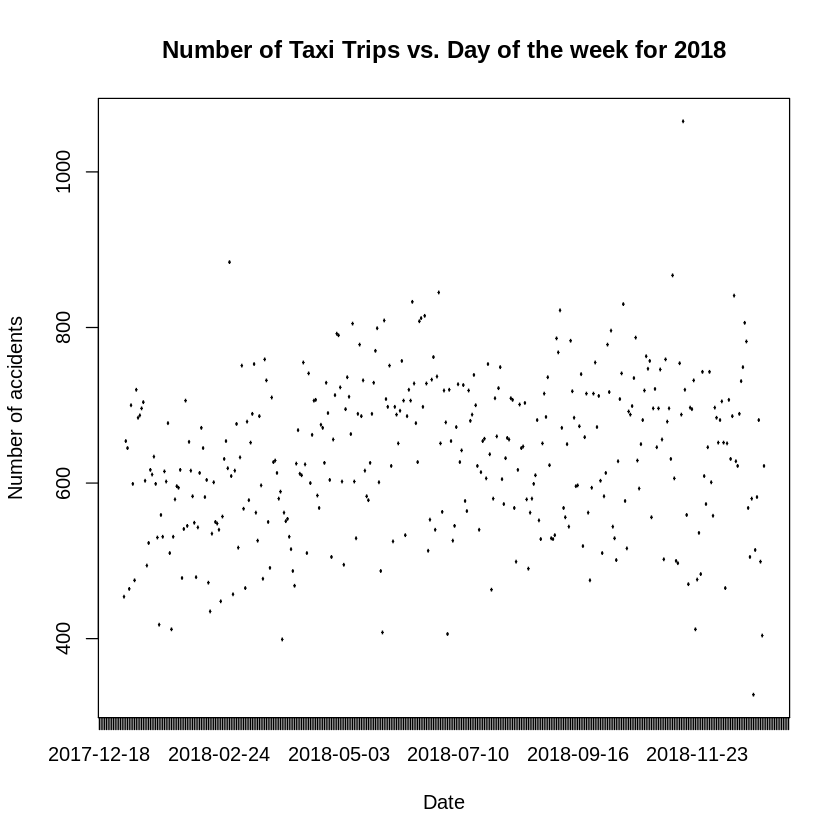

In [ ]:
plot(collision_data$date[1827:2191], collision_data$num_accidents[1827:2191], main="Number of Taxi Trips vs. Day of the week for 2018", xlim=c(1827, 2191), xlab = "Date", ylab = "Number of accidents")

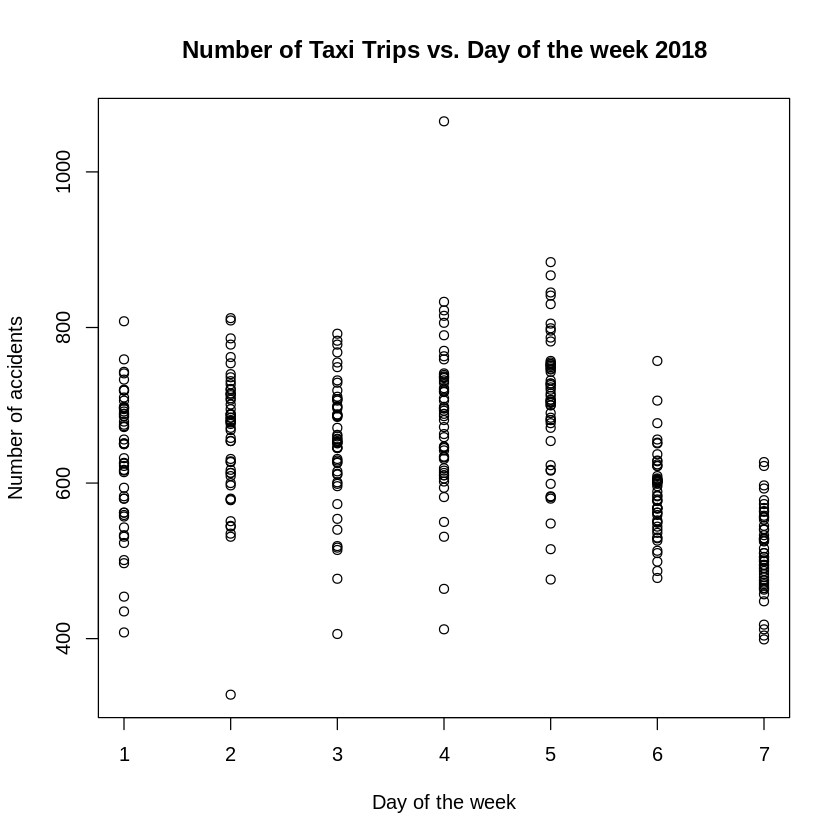

In [ ]:
plot(collision_data$dayofweek[1827:2191], collision_data$num_accidents[1827:2191], main="Number of Taxi Trips vs. Day of the week 2018", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[1827:2191])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  328.0   562.0   634.0   634.4   706.0  1065.0 

There appears to be less seasonal variablity in the 2018 data and plotting by day of the week shows very few outliers, only high.



### 2019 plots and summary

In [ ]:
collision_data$date[2192:2556]

[1] 2019-01-01 2019-01-02 2019-01-03 2019-01-04 2019-01-05 2019-01-06
  [7] 2019-01-07 2019-01-08 2019-01-09 2019-01-10 2019-01-11 2019-01-12
 [13] 2019-01-13 2019-01-14 2019-01-15 2019-01-16 2019-01-17 2019-01-18
 [19] 2019-01-19 2019-01-20 2019-01-21 2019-01-22 2019-01-23 2019-01-24
 [25] 2019-01-25 2019-01-26 2019-01-27 2019-01-28 2019-01-29 2019-01-30
 [31] 2019-01-31 2019-02-01 2019-02-02 2019-02-03 2019-02-04 2019-02-05
 [37] 2019-02-06 2019-02-07 2019-02-08 2019-02-09 2019-02-10 2019-02-11
 [43] 2019-02-12 2019-02-13 2019-02-14 2019-02-15 2019-02-16 2019-02-17
 [49] 2019-02-18 2019-02-19 2019-02-20 2019-02-21 2019-02-22 2019-02-23
 [55] 2019-02-24 2019-02-25 2019-02-26 2019-02-27 2019-02-28 2019-03-01
 [61] 2019-03-02 2019-03-03 2019-03-04 2019-03-05 2019-03-06 2019-03-07
 [67] 2019-03-08 2019-03-09 2019-03-10 2019-03-11 2019-03-12 2019-03-13
 [73] 2019-03-14 2019-03-15 2019-03-16 2019-03-17 2019-03-18 2019-03-19
 [79] 2019-03-20 2019-03-21 2019-03-22 2019-03-23 2019-03-24 2019-03-25
 [85] 2019-03-26 2019-03-27 2019-03-28 2019-03-29 2019-03-30 2019-03-31
 [91] 2019-04-01 2019-04-02 2019-04-03 2019-04-04 2019-04-05 2019-04-06
 [97] 2019-04-07 2019-04-08 2019-04-09 2019-04-10 2019-04-11 2019-04-12
[103] 2019-04-13 2019-04-14 2019-04-15 2019-04-16 2019-04-17 2019-04-18
[109] 2019-04-19 2019-04-20 2019-04-21 2019-04-22 2019-04-23 2019-04-24
[115] 2019-04-25 2019-04-26 2019-04-27 2019-04-28 2019-04-29 2019-04-30
[121] 2019-05-01 2019-05-02 2019-05-03 2019-05-04 2019-05-05 2019-05-06
[127] 2019-05-07 2019-05-08 2019-05-09 2019-05-10 2019-05-11 2019-05-12
[133] 2019-05-13 2019-05-14 2019-05-15 2019-05-16 2019-05-17 2019-05-18
[139] 2019-05-19 2019-05-20 2019-05-21 2019-05-22 2019-05-23 2019-05-24
[145] 2019-05-25 2019-05-26 2019-05-27 2019-05-28 2019-05-29 2019-05-30
[151] 2019-05-31 2019-06-01 2019-06-02 2019-06-03 2019-06-04 2019-06-05
[157] 2019-06-06 2019-06-07 2019-06-08 2019-06-09 2019-06-10 2019-06-11
[163] 2019-06-12 2019-06-13 2019-06-14 2019-06-15 2019-06-16 2019-06-17
[169] 2019-06-18 2019-06-19 2019-06-20 2019-06-21 2019-06-22 2019-06-23
[175] 2019-06-24 2019-06-25 2019-06-26 2019-06-27 2019-06-28 2019-06-29
[181] 2019-06-30 2019-07-01 2019-07-02 2019-07-03 2019-07-04 2019-07-05
[187] 2019-07-06 2019-07-07 2019-07-08 2019-07-09 2019-07-10 2019-07-11
[193] 2019-07-12 2019-07-13 2019-07-14 2019-07-15 2019-07-16 2019-07-17
[199] 2019-07-18 2019-07-19 2019-07-20 2019-07-21 2019-07-22 2019-07-23
[205] 2019-07-24 2019-07-25 2019-07-26 2019-07-27 2019-07-28 2019-07-29
[211] 2019-07-30 2019-07-31 2019-08-01 2019-08-02 2019-08-03 2019-08-04
[217] 2019-08-05 2019-08-06 2019-08-07 2019-08-08 2019-08-09 2019-08-10
[223] 2019-08-11 2019-08-12 2019-08-13 2019-08-14 2019-08-15 2019-08-16
[229] 2019-08-17 2019-08-18 2019-08-19 2019-08-20 2019-08-21 2019-08-22
[235] 2019-08-23 2019-08-24 2019-08-25 2019-08-26 2019-08-27 2019-08-28
[241] 2019-08-29 2019-08-30 2019-08-31 2019-09-01 2019-09-02 2019-09-03
[247] 2019-09-04 2019-09-05 2019-09-06 2019-09-07 2019-09-08 2019-09-09
[253] 2019-09-10 2019-09-11 2019-09-12 2019-09-13 2019-09-14 2019-09-15
[259] 2019-09-16 2019-09-17 2019-09-18 2019-09-19 2019-09-20 2019-09-21
[265] 2019-09-22 2019-09-23 2019-09-24 2019-09-25 2019-09-26 2019-09-27
[271] 2019-09-28 2019-09-29 2019-09-30 2019-10-01 2019-10-02 2019-10-03
[277] 2019-10-04 2019-10-05 2019-10-06 2019-10-07 2019-10-08 2019-10-09
[283] 2019-10-10 2019-10-11 2019-10-12 2019-10-13 2019-10-14 2019-10-15
[289] 2019-10-16 2019-10-17 2019-10-18 2019-10-19 2019-10-20 2019-10-21
[295] 2019-10-22 2019-10-23 2019-10-24 2019-10-25 2019-10-26 2019-10-27
[301] 2019-10-28 2019-10-29 2019-10-30 2019-10-31 2019-11-01 2019-11-02
[307] 2019-11-03 2019-11-04 2019-11-05 2019-11-06 2019-11-07 2019-11-08
[313] 2019-11-09 2019-11-10 2019-11-11 2019-11-12 2019-11-13 2019-11-14
[319] 2019-11-15 2019-11-16 2019-11-17 2019-11-18 2019-11-19 2019-11-20
[325] 2019-11-21 2019-11-22 2019-11-23 2019-11-24 2019-11-25 2019-11-26
[331] 2019-11-27 2019-11-28 2019-11-29 201

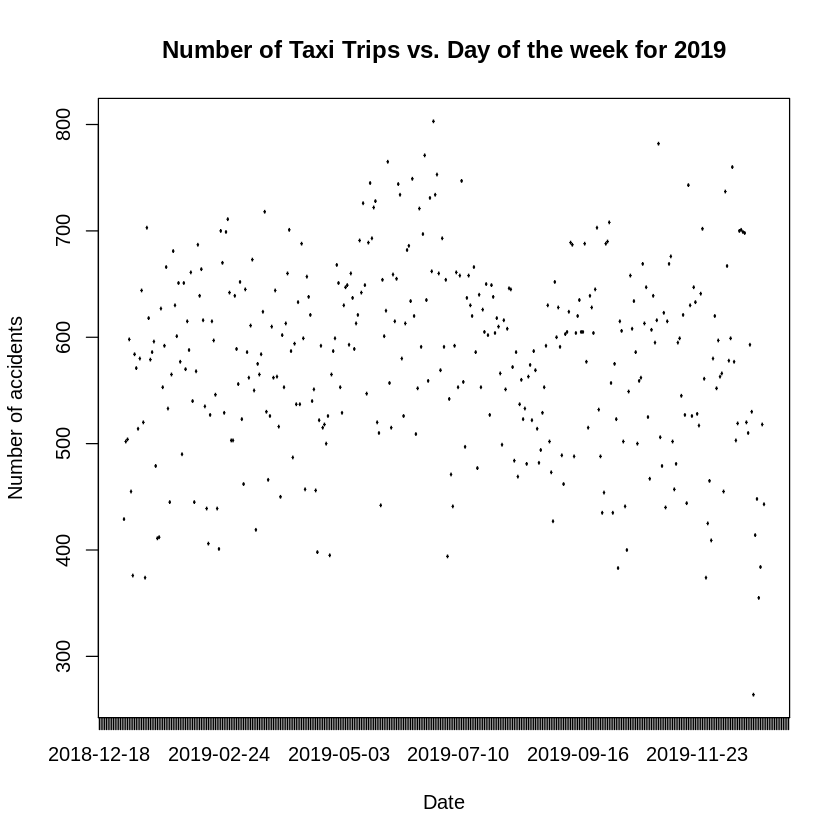

In [ ]:
plot(collision_data$date[2192:2556], collision_data$num_accidents[2192:2556], main="Number of Taxi Trips vs. Day of the week for 2019", xlim=c(2192, 2556), xlab = "Date", ylab = "Number of accidents")

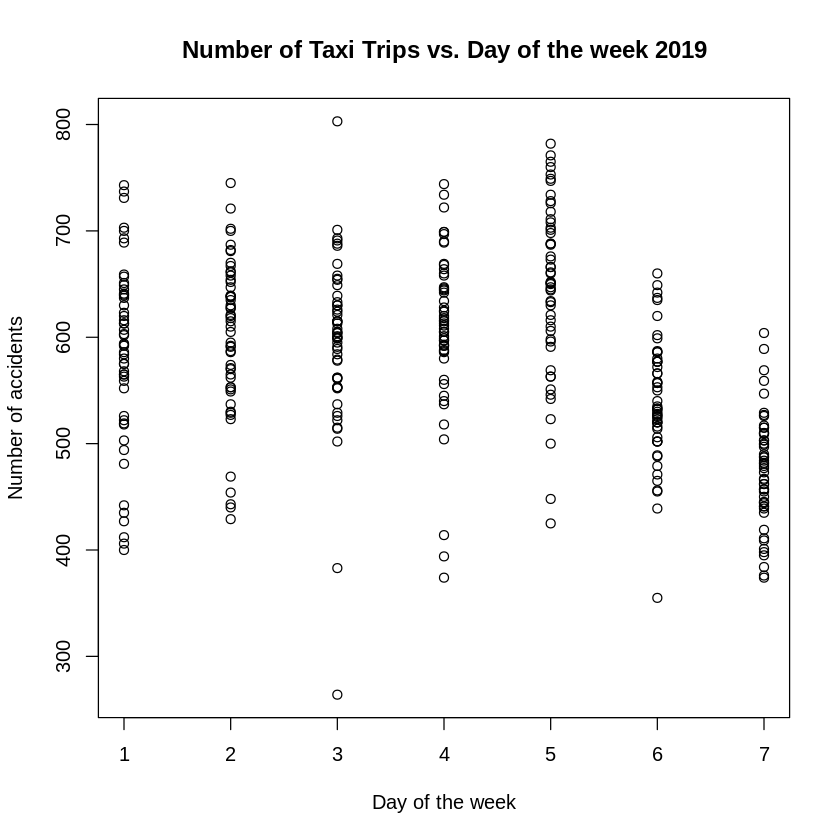

In [ ]:
plot(collision_data$dayofweek[2192:2556], collision_data$num_accidents[2192:2556], main="Number of Taxi Trips vs. Day of the week 2019", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[2192:2556])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  264.0   522.0   589.0   579.4   641.0   803.0 

There appears to be less seasonal variablity in the 2019 data and plotting by day of the week shows just a few outliers. which are low.



### 2020 plots and summary

In [ ]:
collision_data$date[2557:2922]

[1] 2020-01-01 2020-01-02 2020-01-03 2020-01-04 2020-01-05 2020-01-06
  [7] 2020-01-07 2020-01-08 2020-01-09 2020-01-10 2020-01-11 2020-01-12
 [13] 2020-01-13 2020-01-14 2020-01-15 2020-01-16 2020-01-17 2020-01-18
 [19] 2020-01-19 2020-01-20 2020-01-21 2020-01-22 2020-01-23 2020-01-24
 [25] 2020-01-25 2020-01-26 2020-01-27 2020-01-28 2020-01-29 2020-01-30
 [31] 2020-01-31 2020-02-01 2020-02-02 2020-02-03 2020-02-04 2020-02-05
 [37] 2020-02-06 2020-02-07 2020-02-08 2020-02-09 2020-02-10 2020-02-11
 [43] 2020-02-12 2020-02-13 2020-02-14 2020-02-15 2020-02-16 2020-02-17
 [49] 2020-02-18 2020-02-19 2020-02-20 2020-02-21 2020-02-22 2020-02-23
 [55] 2020-02-24 2020-02-25 2020-02-26 2020-02-27 2020-02-28 2020-02-29
 [61] 2020-03-01 2020-03-02 2020-03-03 2020-03-04 2020-03-05 2020-03-06
 [67] 2020-03-07 2020-03-08 2020-03-09 2020-03-10 2020-03-11 2020-03-12
 [73] 2020-03-13 2020-03-14 2020-03-15 2020-03-16 2020-03-17 2020-03-18
 [79] 2020-03-19 2020-03-20 2020-03-21 2020-03-22 2020-03-23 2020-03-24
 [85] 2020-03-25 2020-03-26 2020-03-27 2020-03-28 2020-03-29 2020-03-30
 [91] 2020-03-31 2020-04-01 2020-04-02 2020-04-03 2020-04-04 2020-04-05
 [97] 2020-04-06 2020-04-07 2020-04-08 2020-04-09 2020-04-10 2020-04-11
[103] 2020-04-12 2020-04-13 2020-04-14 2020-04-15 2020-04-16 2020-04-17
[109] 2020-04-18 2020-04-19 2020-04-20 2020-04-21 2020-04-22 2020-04-23
[115] 2020-04-24 2020-04-25 2020-04-26 2020-04-27 2020-04-28 2020-04-29
[121] 2020-04-30 2020-05-01 2020-05-02 2020-05-03 2020-05-04 2020-05-05
[127] 2020-05-06 2020-05-07 2020-05-08 2020-05-09 2020-05-10 2020-05-11
[133] 2020-05-12 2020-05-13 2020-05-14 2020-05-15 2020-05-16 2020-05-17
[139] 2020-05-18 2020-05-19 2020-05-20 2020-05-21 2020-05-22 2020-05-23
[145] 2020-05-24 2020-05-25 2020-05-26 2020-05-27 2020-05-28 2020-05-29
[151] 2020-05-30 2020-05-31 2020-06-01 2020-06-02 2020-06-03 2020-06-04
[157] 2020-06-05 2020-06-06 2020-06-07 2020-06-08 2020-06-09 2020-06-10
[163] 2020-06-11 2020-06-12 2020-06-13 2020-06-14 2020-06-15 2020-06-16
[169] 2020-06-17 2020-06-18 2020-06-19 2020-06-20 2020-06-21 2020-06-22
[175] 2020-06-23 2020-06-24 2020-06-25 2020-06-26 2020-06-27 2020-06-28
[181] 2020-06-29 2020-06-30 2020-07-01 2020-07-02 2020-07-03 2020-07-04
[187] 2020-07-05 2020-07-06 2020-07-07 2020-07-08 2020-07-09 2020-07-10
[193] 2020-07-11 2020-07-12 2020-07-13 2020-07-14 2020-07-15 2020-07-16
[199] 2020-07-17 2020-07-18 2020-07-19 2020-07-20 2020-07-21 2020-07-22
[205] 2020-07-23 2020-07-24 2020-07-25 2020-07-26 2020-07-27 2020-07-28
[211] 2020-07-29 2020-07-30 2020-07-31 2020-08-01 2020-08-02 2020-08-03
[217] 2020-08-04 2020-08-05 2020-08-06 2020-08-07 2020-08-08 2020-08-09
[223] 2020-08-10 2020-08-11 2020-08-12 2020-08-13 2020-08-14 2020-08-15
[229] 2020-08-16 2020-08-17 2020-08-18 2020-08-19 2020-08-20 2020-08-21
[235] 2020-08-22 2020-08-23 2020-08-24 2020-08-25 2020-08-26 2020-08-27
[241] 2020-08-28 2020-08-29 2020-08-30 2020-08-31 2020-09-01 2020-09-02
[247] 2020-09-03 2020-09-04 2020-09-05 2020-09-06 2020-09-07 2020-09-08
[253] 2020-09-09 2020-09-10 2020-09-11 2020-09-12 2020-09-13 2020-09-14
[259] 2020-09-15 2020-09-16 2020-09-17 2020-09-18 2020-09-19 2020-09-20
[265] 2020-09-21 2020-09-22 2020-09-23 2020-09-24 2020-09-25 2020-09-26
[271] 2020-09-27 2020-09-28 2020-09-29 2020-09-30 2020-10-01 2020-10-02
[277] 2020-10-03 2020-10-04 2020-10-05 2020-10-06 2020-10-07 2020-10-08
[283] 2020-10-09 2020-10-10 2020-10-11 2020-10-12 2020-10-13 2020-10-14
[289] 2020-10-15 2020-10-16 2020-10-17 2020-10-18 2020-10-19 2020-10-20
[295] 2020-10-21 2020-10-22 2020-10-23 2020-10-24 2020-10-25 2020-10-26
[301] 2020-10-27 2020-10-28 2020-10-29 2020-10-30 2020-10-31 2020-11-01
[307] 2020-11-02 2020-11-03 2020-11-04 2020-11-05 2020-11-06 2020-11-07
[313] 2020-11-08 2020-11-09 2020-11-10 2020-11-11 2020-11-12 2020-11-13
[319] 2020-11-14 2020-11-15 2020-11-16 2020-11-17 2020-11-18 2020-11-19
[325] 2020-11-20 2020-11-21 2020-11-22 2020-11-23 2020-11-24 2020-11-25
[331] 2020-11-26 2020-11-27 2020-11-28 202

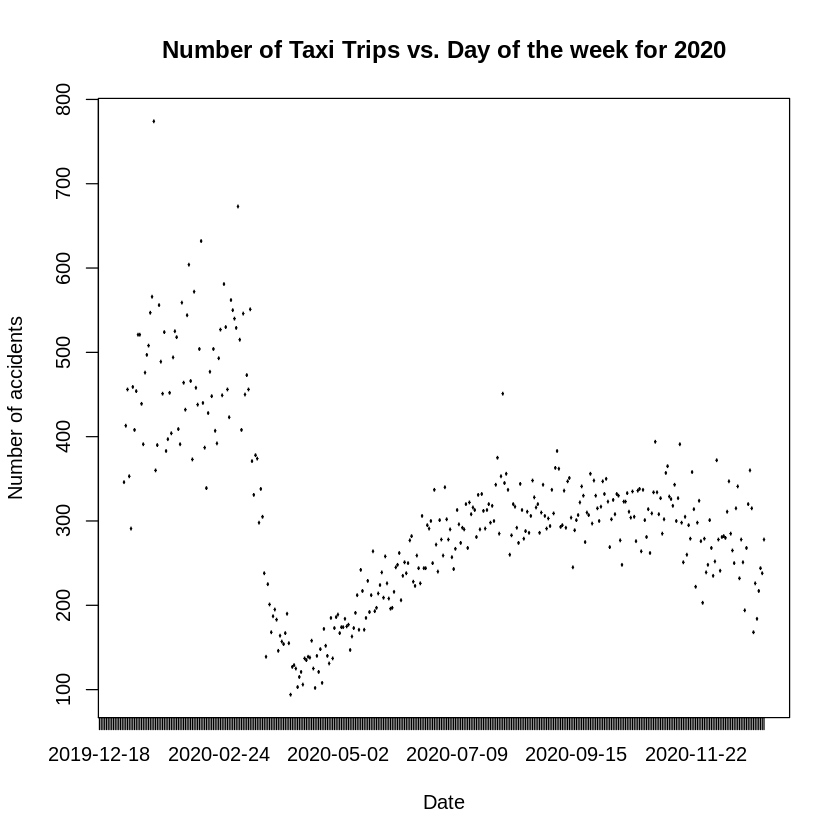

In [ ]:
plot(collision_data$date[2557:2922], collision_data$num_accidents[2557:2922], main="Number of Taxi Trips vs. Day of the week for 2020", xlim=c(2557, 2922), xlab = "Date", ylab = "Number of accidents")

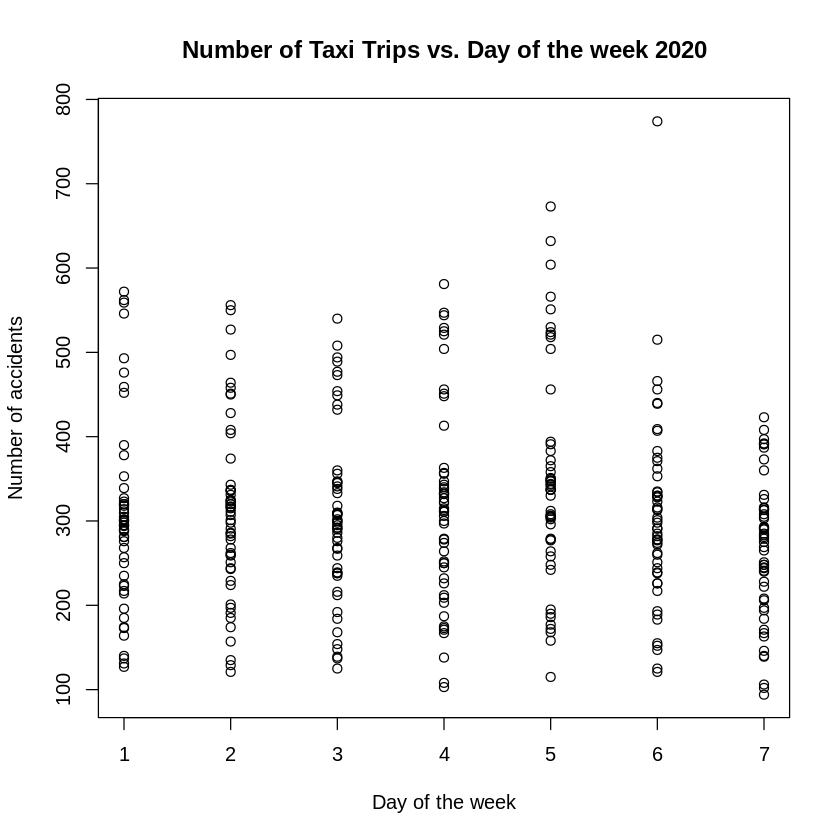

In [ ]:
plot(collision_data$dayofweek[2557:2922], collision_data$num_accidents[2557:2922], main="Number of Taxi Trips vs. Day of the week 2020", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[2557:2922])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   94.0   242.2   301.0   308.4   347.8   774.0 

The plots for 2020 show a completely different pattern than those seen in other years.  As previously mentioned, it is believed this is due to the covid-19 lockdown experienced in New York.  This is now investigated more closely.



### Covid impact on 2020 data



New York was in a full lockdown from March - April 2020 then went through a four stage return to normal from April 2020 to July 202 (New York State 2021).  The analysis for this period can be seen below.

In [ ]:
collision_data$date[2588:2769]

[1] 2020-02-01 2020-02-02 2020-02-03 2020-02-04 2020-02-05 2020-02-06
  [7] 2020-02-07 2020-02-08 2020-02-09 2020-02-10 2020-02-11 2020-02-12
 [13] 2020-02-13 2020-02-14 2020-02-15 2020-02-16 2020-02-17 2020-02-18
 [19] 2020-02-19 2020-02-20 2020-02-21 2020-02-22 2020-02-23 2020-02-24
 [25] 2020-02-25 2020-02-26 2020-02-27 2020-02-28 2020-02-29 2020-03-01
 [31] 2020-03-02 2020-03-03 2020-03-04 2020-03-05 2020-03-06 2020-03-07
 [37] 2020-03-08 2020-03-09 2020-03-10 2020-03-11 2020-03-12 2020-03-13
 [43] 2020-03-14 2020-03-15 2020-03-16 2020-03-17 2020-03-18 2020-03-19
 [49] 2020-03-20 2020-03-21 2020-03-22 2020-03-23 2020-03-24 2020-03-25
 [55] 2020-03-26 2020-03-27 2020-03-28 2020-03-29 2020-03-30 2020-03-31
 [61] 2020-04-01 2020-04-02 2020-04-03 2020-04-04 2020-04-05 2020-04-06
 [67] 2020-04-07 2020-04-08 2020-04-09 2020-04-10 2020-04-11 2020-04-12
 [73] 2020-04-13 2020-04-14 2020-04-15 2020-04-16 2020-04-17 2020-04-18
 [79] 2020-04-19 2020-04-20 2020-04-21 2020-04-22 2020-04-23 2020-04-24
 [85] 2020-04-25 2020-04-26 2020-04-27 2020-04-28 2020-04-29 2020-04-30
 [91] 2020-05-01 2020-05-02 2020-05-03 2020-05-04 2020-05-05 2020-05-06
 [97] 2020-05-07 2020-05-08 2020-05-09 2020-05-10 2020-05-11 2020-05-12
[103] 2020-05-13 2020-05-14 2020-05-15 2020-05-16 2020-05-17 2020-05-18
[109] 2020-05-19 2020-05-20 2020-05-21 2020-05-22 2020-05-23 2020-05-24
[115] 2020-05-25 2020-05-26 2020-05-27 2020-05-28 2020-05-29 2020-05-30
[121] 2020-05-31 2020-06-01 2020-06-02 2020-06-03 2020-06-04 2020-06-05
[127] 2020-06-06 2020-06-07 2020-06-08 2020-06-09 2020-06-10 2020-06-11
[133] 2020-06-12 2020-06-13 2020-06-14 2020-06-15 2020-06-16 2020-06-17
[139] 2020-06-18 2020-06-19 2020-06-20 2020-06-21 2020-06-22 2020-06-23
[145] 2020-06-24 2020-06-25 2020-06-26 2020-06-27 2020-06-28 2020-06-29
[151] 2020-06-30 2020-07-01 2020-07-02 2020-07-03 2020-07-04 2020-07-05
[157] 2020-07-06 2020-07-07 2020-07-08 2020-07-09 2020-07-10 2020-07-11
[163] 2020-07-12 2020-07-13 2020-07-14 2020-07-15 2020-07-16 2020-07-17
[169] 2020-07-18 2020-07-19 2020-07-20 2020-07-21 2020-07-22 2020-07-23
[175] 2020-07-24 2020-07-25 2020-07-26 2020-07-27 2020-07-28 2020-07-29
[181] 2020-07-30 2020-07-31
2922 Levels: 2013-01-01 2013-01-02 2013-01-03 2013-01-04 ... 2020-12-31

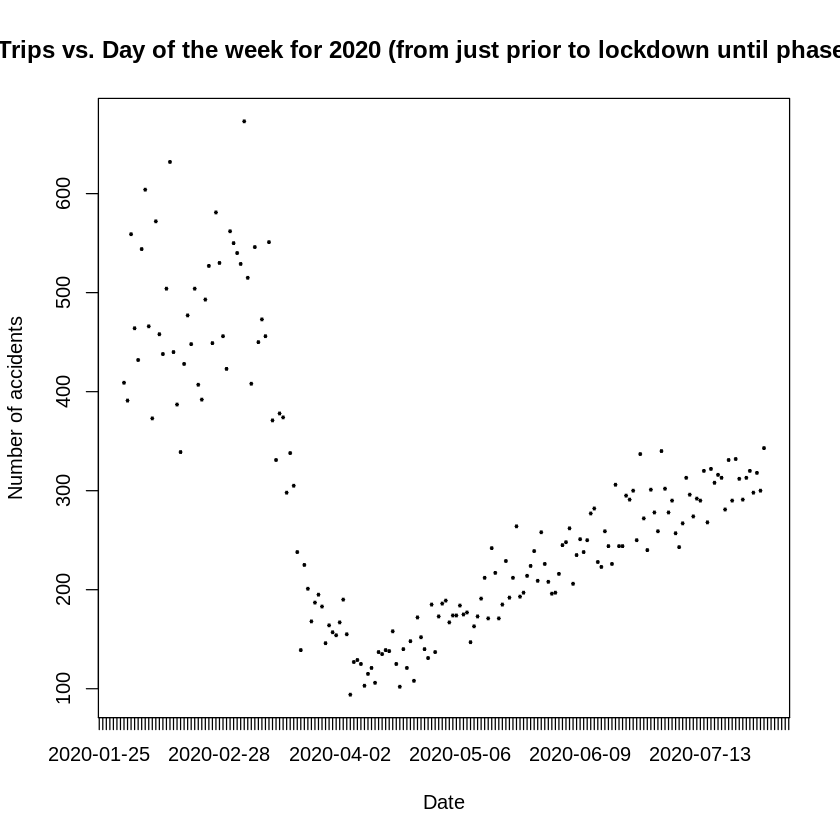

In [ ]:
plot(collision_data$date[2588:2769], collision_data$num_accidents[2588:2769], main="Number of Taxi Trips vs. Day of the week for 2020 (from just prior to lockdown until phased return completed)", xlim=c(2588, 2769), xlab = "Date", ylab = "Number of accidents")

This plot shows a marked decline in the number of accidents from March 2020, dropping to a low point in early April.  From here accident numbers gradually increase until July as the staged return to normal took place however, these figures never returned as high as would be expected based on previous years.

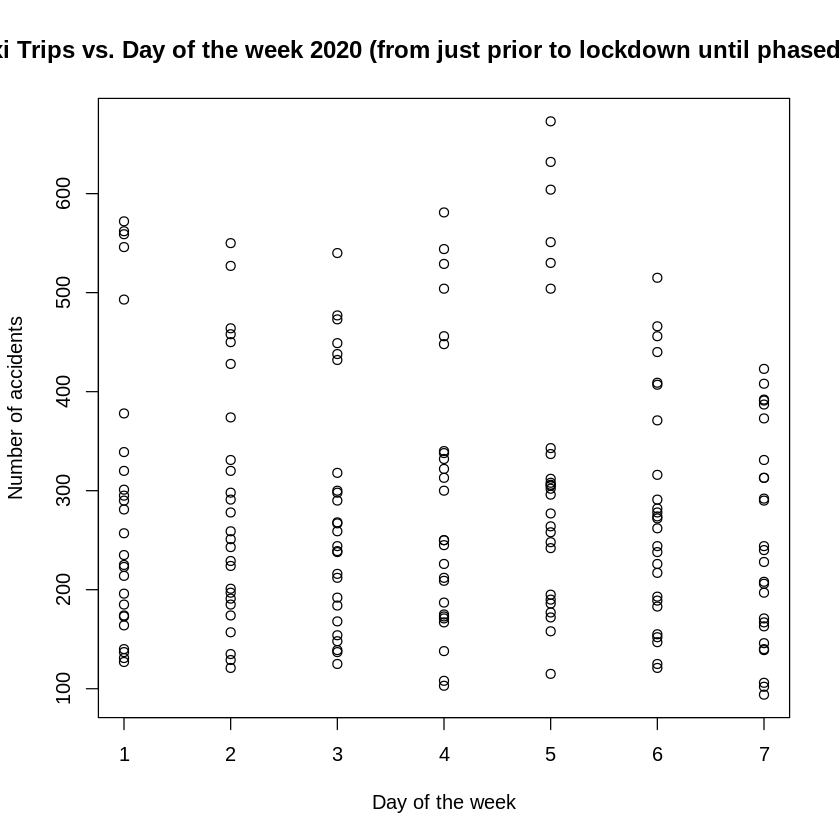

In [ ]:
plot(collision_data$dayofweek[2588:2769], collision_data$num_accidents[2588:2769], main="Number of Taxi Trips vs. Day of the week 2020 (from just prior to lockdown until phased return completed)", xlab = "Day of the week", ylab = "Number of accidents")

In [ ]:
summary(collision_data$num_accidents[2588:2769])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   94.0   185.0   258.5   285.6   339.8   673.0 

Plotting 2020 by day of the week and and looking at the summary supports the view that 2020 is something of an deviation from the regular patterns.  It can be seen that each year generally shows a similar pattern with the exception of some outliers in individual years and with a small increase year on year.  2020 as previously discussed was an unusual year so is quite different from the others. Due to this it has been decided that 2020 will not be included for the following maps and then ignored.

## Map plots of collisions using lat/long

In [ ]:
cl_2013 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2013_collision_location.csv")
cl_2014 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2014_collision_location.csv")
cl_2015 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2015_collision_data.csv")
cl_2016 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2016_collisions_data.csv")
cl_2017 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2017_collision_data.csv")
cl_2018 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2018_collision_location.csv")
cl_2019 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2019_collision_data.csv")
cl_2020 <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/2020_collision_data.csv")

In [ ]:
col_2013 <- ggplot(cl_2013, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() +
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2013") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

col_2014 <- ggplot(cl_2014, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() + 
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2014") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

col_2015 <- ggplot(cl_2015, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() + 
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2015") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

col_2016 <- ggplot(cl_2016, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() + 
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2016") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

col_2017 <- ggplot(cl_2017, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() + 
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2017") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

col_2018 <- ggplot(cl_2018, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() + 
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2018") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

col_2019 <- ggplot(cl_2019, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() + 
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2019") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

  col_2020 <- ggplot(cl_2020, aes(x = longitude, y = latitude)) + 
  geom_point(size = 0.1, alpha = 0.05) + 
  coord_equal() + 
  xlab('Longitude') + 
  ylab('Latitude') + 
  ggtitle("2020") +
  coord_cartesian(xlim = c(-73.7, -74.25), 
                  ylim = c(40.5, 40.95))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



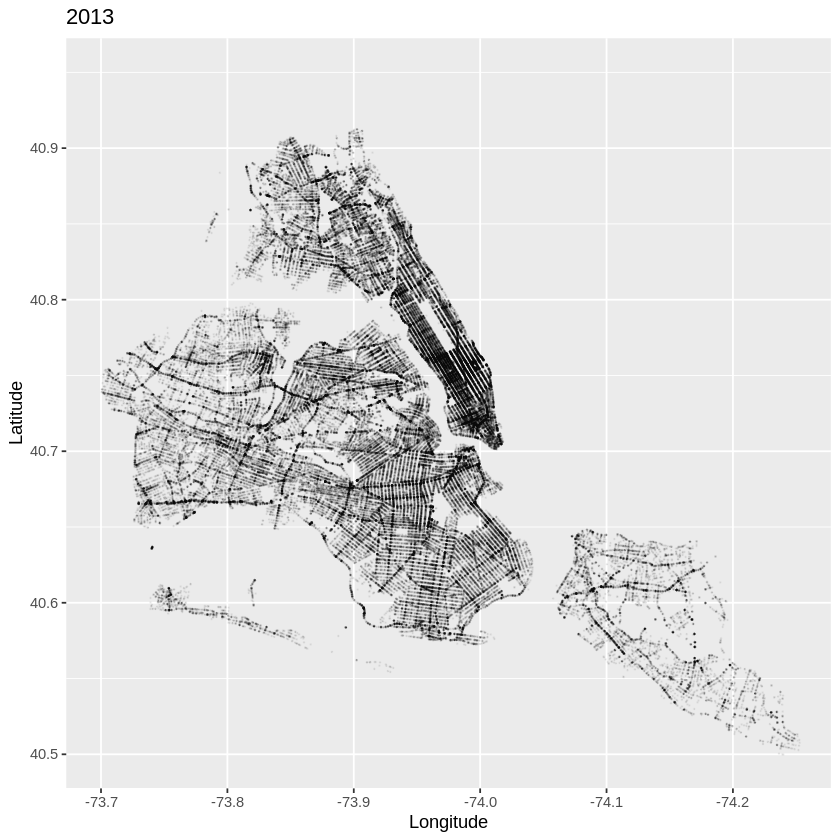

In [ ]:
col_2013

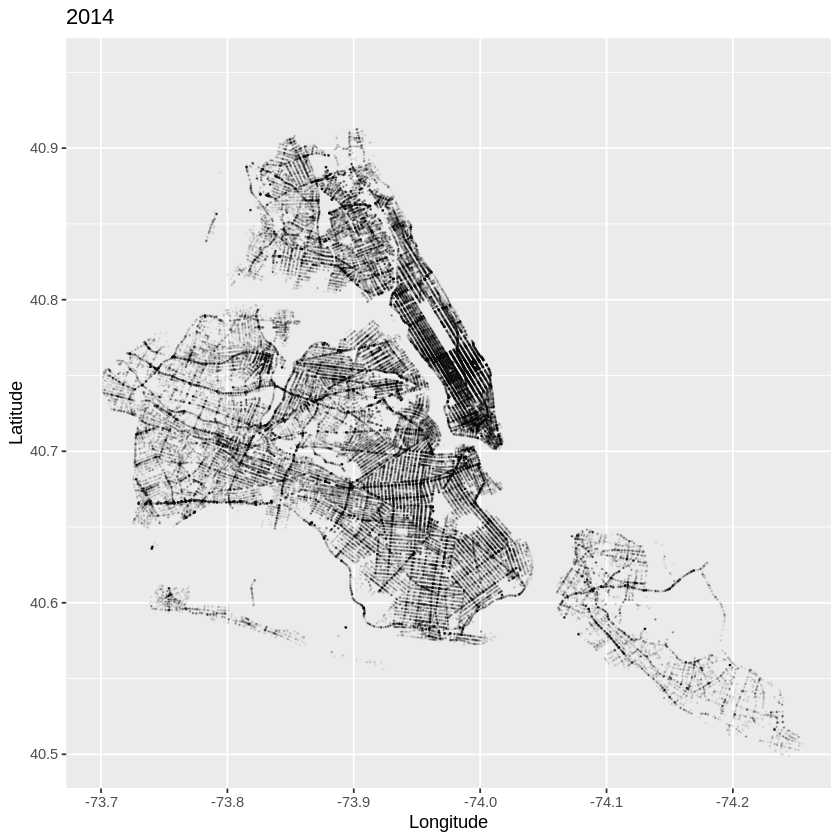

In [ ]:
col_2014

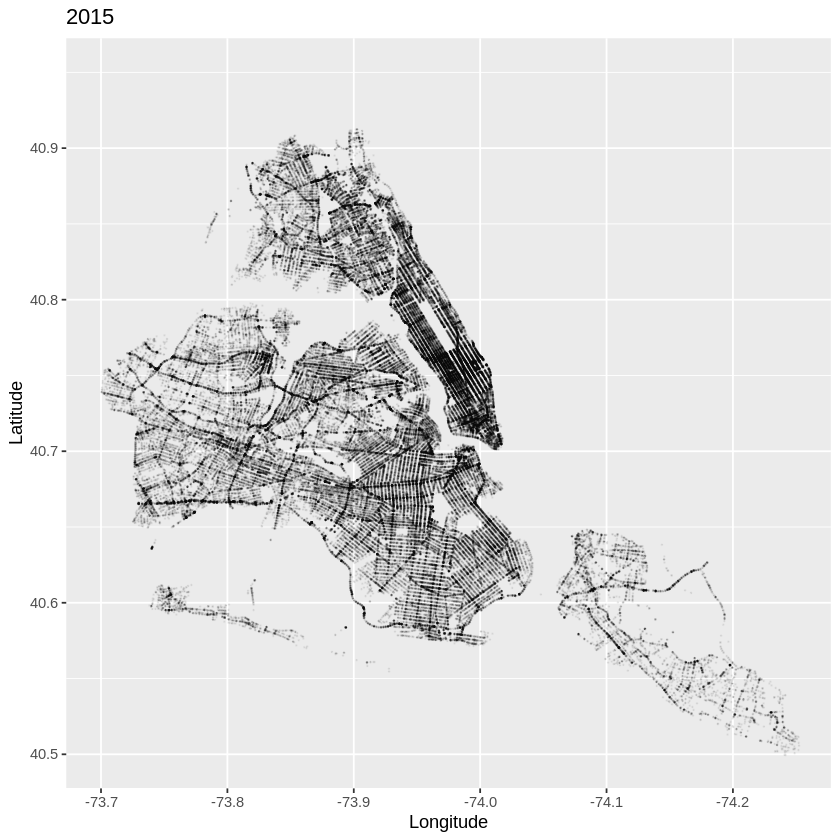

In [ ]:
col_2015

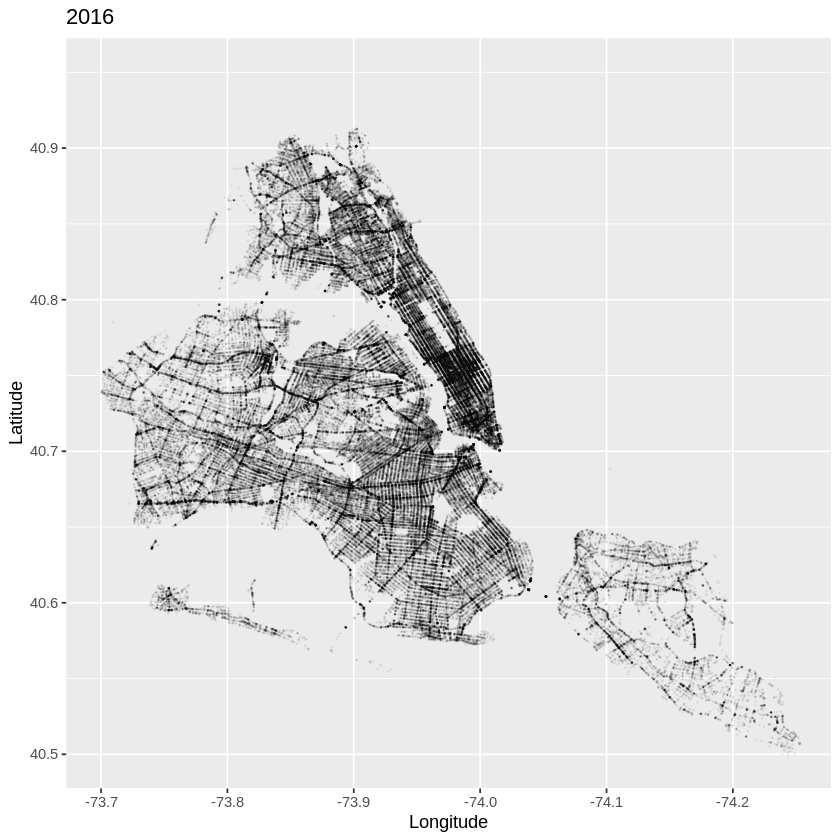

In [ ]:
col_2016

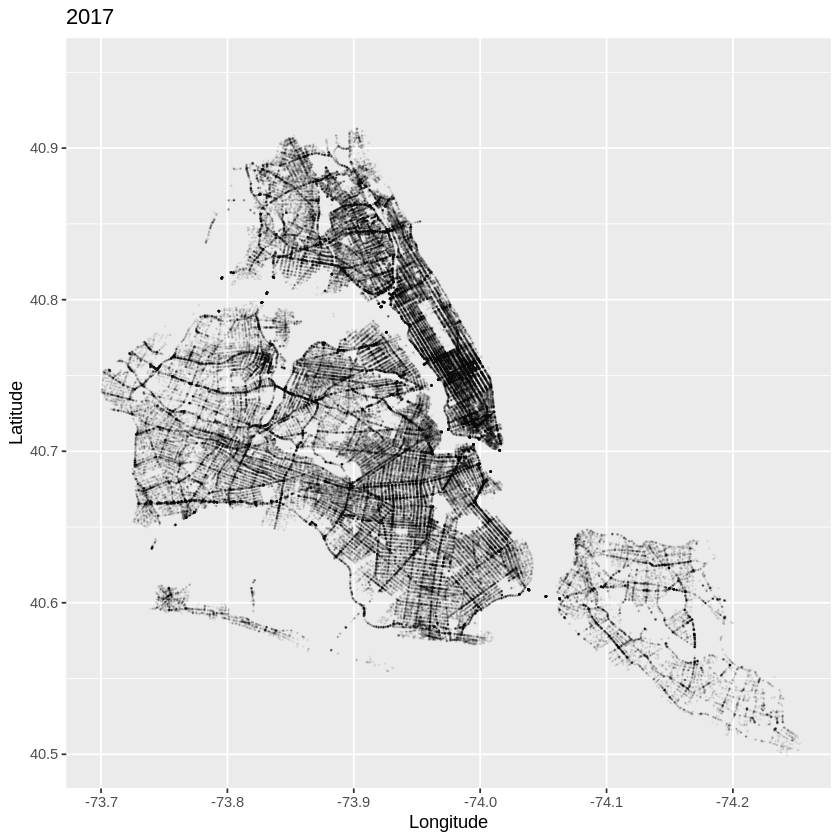

In [ ]:
col_2017

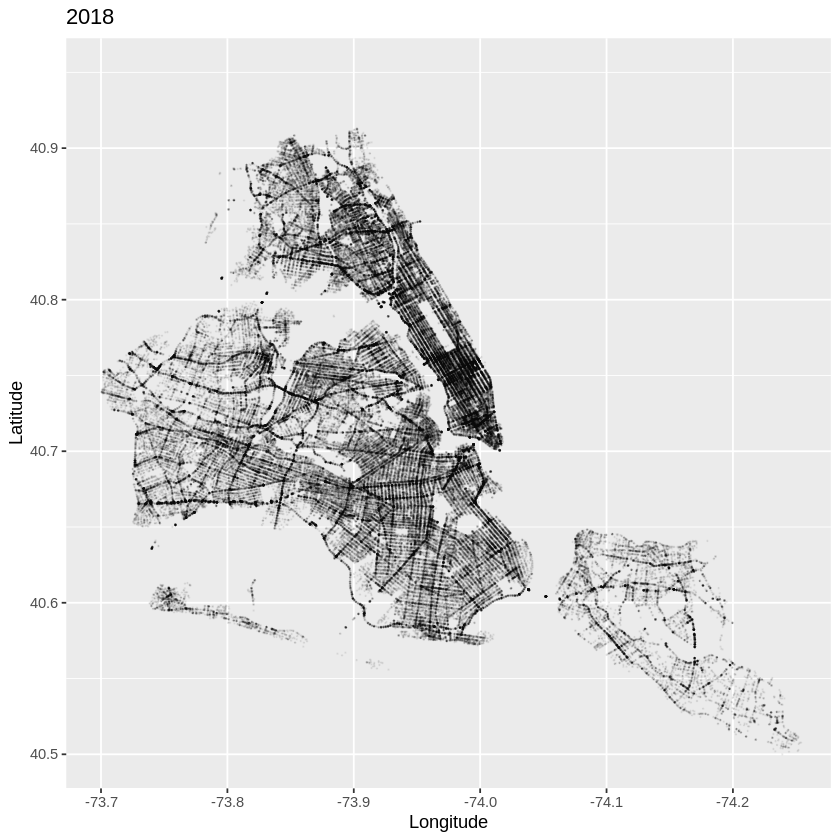

In [ ]:
col_2018

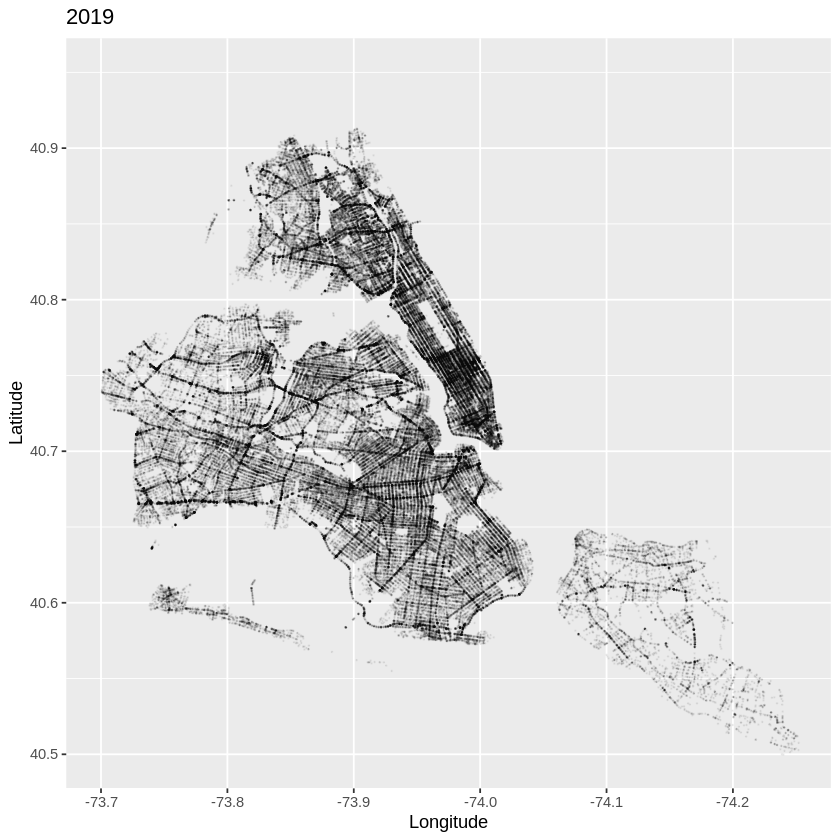

In [ ]:
col_2019

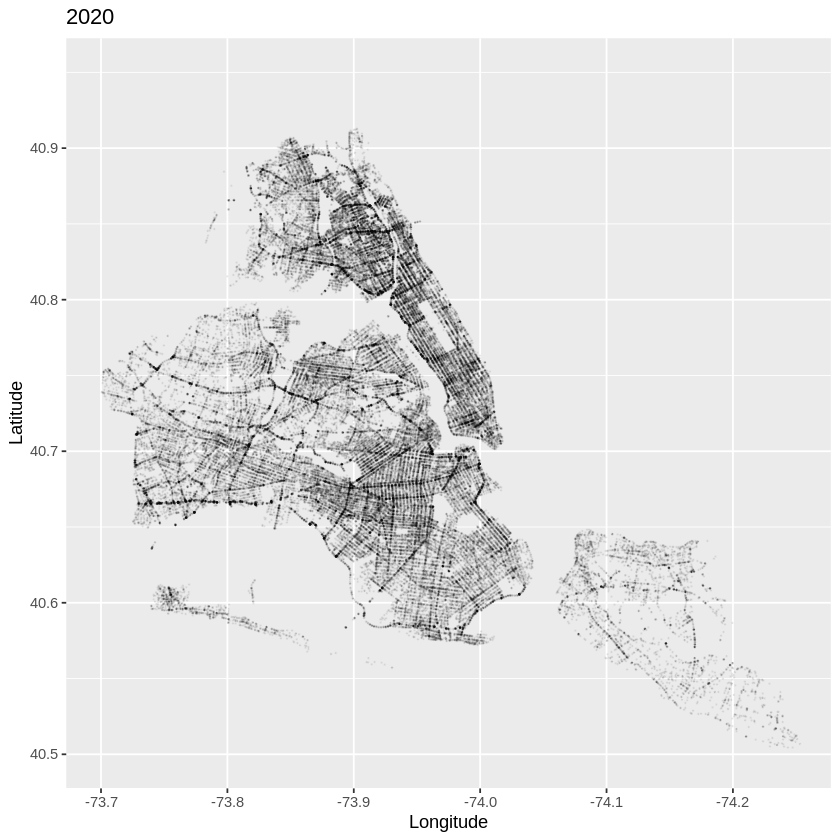

In [ ]:
col_2020

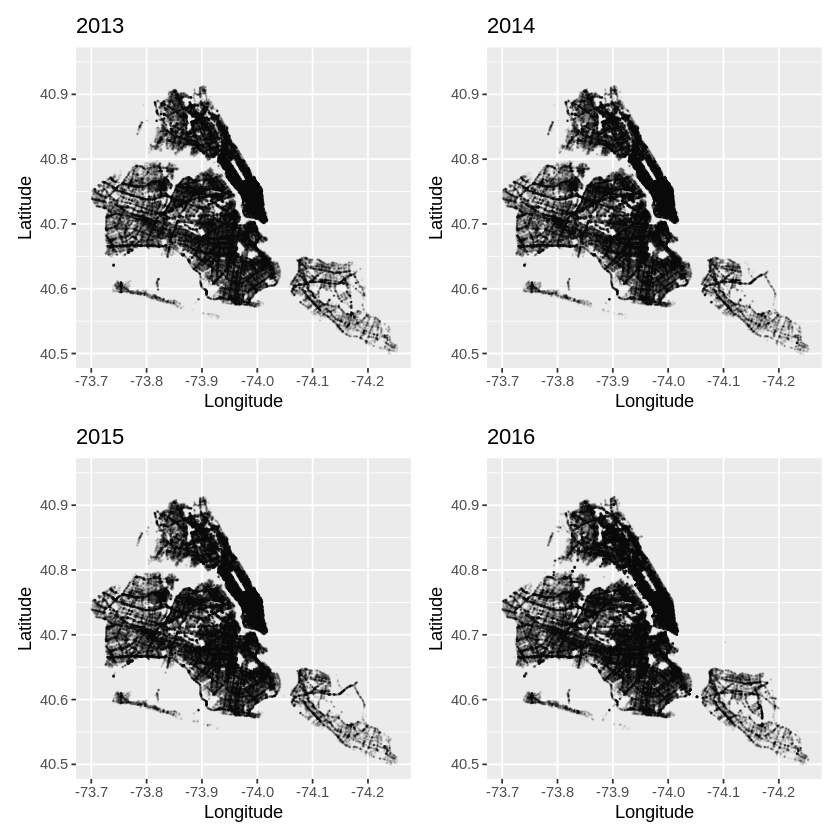

In [ ]:
col_2013 + col_2014 + col_2015 + col_2016

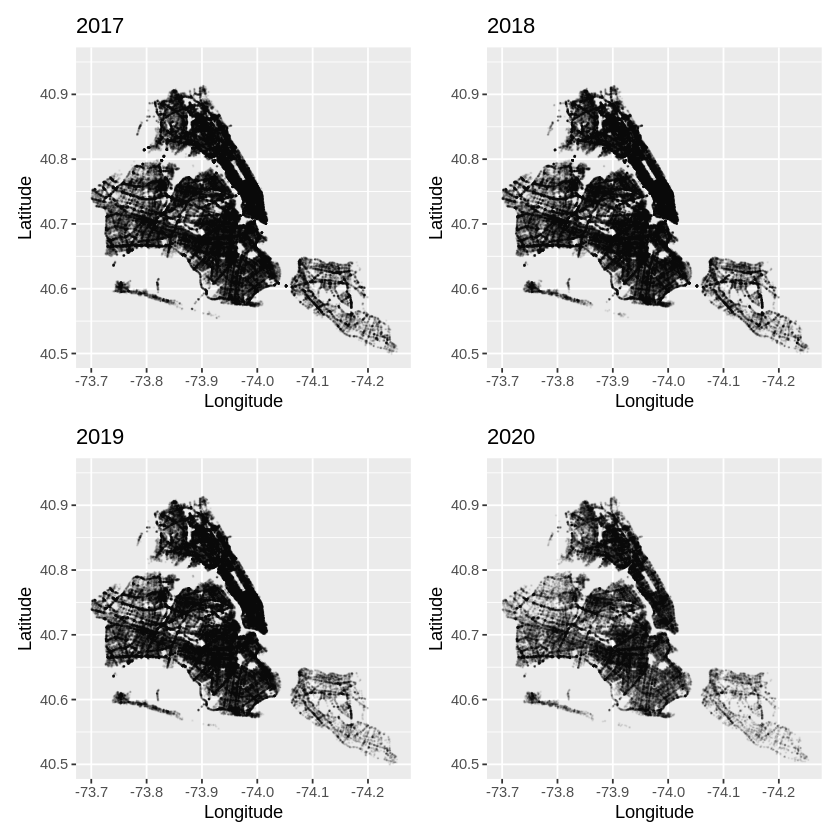

In [ ]:
col_2017 + col_2018 + col_2019 + col_2020

These plots by latitude and longitude to map the collisions show where accidents happen most commonly.  They are generally similar year or year though 2020 has lighter shading reflecting the reduced number of accidents that year.



## Check if making Sunday first day of the week makes correlation with number of collisions stronger

### Make Sunday day 1

In [ ]:
moveday <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/collision_data_c.csv")

In [ ]:
head(moveday)

dayofweek day year month date       temp dewp slp    visib wdsp mxpsd gust
1 2         1   2013 1     2013-01-01 38.0 25.6 1008.8 10.0  15.0 21.0  28.0
2 3         2   2013 1     2013-01-02 27.5 12.1 1013.4 10.0  12.4 15.9  25.1
3 4         3   2013 1     2013-01-03 21.8  7.8 1018.1 10.0   9.8 18.1  24.1
4 5         4   2013 1     2013-01-04 32.2 21.1 1015.2 10.0  11.3 22.0  29.9
5 6         5   2013 1     2013-01-05 37.3 24.5 1017.3 10.0  13.2 20.0  28.0
6 7         6   2013 1     2013-01-06 35.7 31.3 1019.7  9.8   5.9 15.0  20.0
  max  min  prcp sndp  fog num_accidents
1 41.0 33.1 0.00 999.9 0   381          
2 33.1 21.9 0.00 999.9 0   480          
3 28.9 16.0 0.00 999.9 0   549          
4 41.0 24.1 0.00 999.9 0   505          
5 42.1 30.9 0.00 999.9 0   389          
6 44.1 23.0 0.01 999.9 0   393

Make Sunday = day 1

In [ ]:
moveday$dayofweek <- moveday$dayofweek+1

In [ ]:
head(moveday)

dayofweek day year month date       temp dewp slp    visib wdsp mxpsd gust
1 3         1   2013 1     2013-01-01 38.0 25.6 1008.8 10.0  15.0 21.0  28.0
2 4         2   2013 1     2013-01-02 27.5 12.1 1013.4 10.0  12.4 15.9  25.1
3 5         3   2013 1     2013-01-03 21.8  7.8 1018.1 10.0   9.8 18.1  24.1
4 6         4   2013 1     2013-01-04 32.2 21.1 1015.2 10.0  11.3 22.0  29.9
5 7         5   2013 1     2013-01-05 37.3 24.5 1017.3 10.0  13.2 20.0  28.0
6 8         6   2013 1     2013-01-06 35.7 31.3 1019.7  9.8   5.9 15.0  20.0
  max  min  prcp sndp  fog num_accidents
1 41.0 33.1 0.00 999.9 0   381          
2 33.1 21.9 0.00 999.9 0   480          
3 28.9 16.0 0.00 999.9 0   549          
4 41.0 24.1 0.00 999.9 0   505          
5 42.1 30.9 0.00 999.9 0   389          
6 44.1 23.0 0.01 999.9 0   393

In [ ]:
moveday$dayofweek[moveday$dayofweek == 8] <- 1

In [ ]:
head(moveday)

dayofweek day year month date       temp dewp slp    visib wdsp mxpsd gust
1 3         1   2013 1     2013-01-01 38.0 25.6 1008.8 10.0  15.0 21.0  28.0
2 4         2   2013 1     2013-01-02 27.5 12.1 1013.4 10.0  12.4 15.9  25.1
3 5         3   2013 1     2013-01-03 21.8  7.8 1018.1 10.0   9.8 18.1  24.1
4 6         4   2013 1     2013-01-04 32.2 21.1 1015.2 10.0  11.3 22.0  29.9
5 7         5   2013 1     2013-01-05 37.3 24.5 1017.3 10.0  13.2 20.0  28.0
6 1         6   2013 1     2013-01-06 35.7 31.3 1019.7  9.8   5.9 15.0  20.0
  max  min  prcp sndp  fog num_accidents
1 41.0 33.1 0.00 999.9 0   381          
2 33.1 21.9 0.00 999.9 0   480          
3 28.9 16.0 0.00 999.9 0   549          
4 41.0 24.1 0.00 999.9 0   505          
5 42.1 30.9 0.00 999.9 0   389          
6 44.1 23.0 0.01 999.9 0   393

Re-plot with Sunday as the first day of the week.

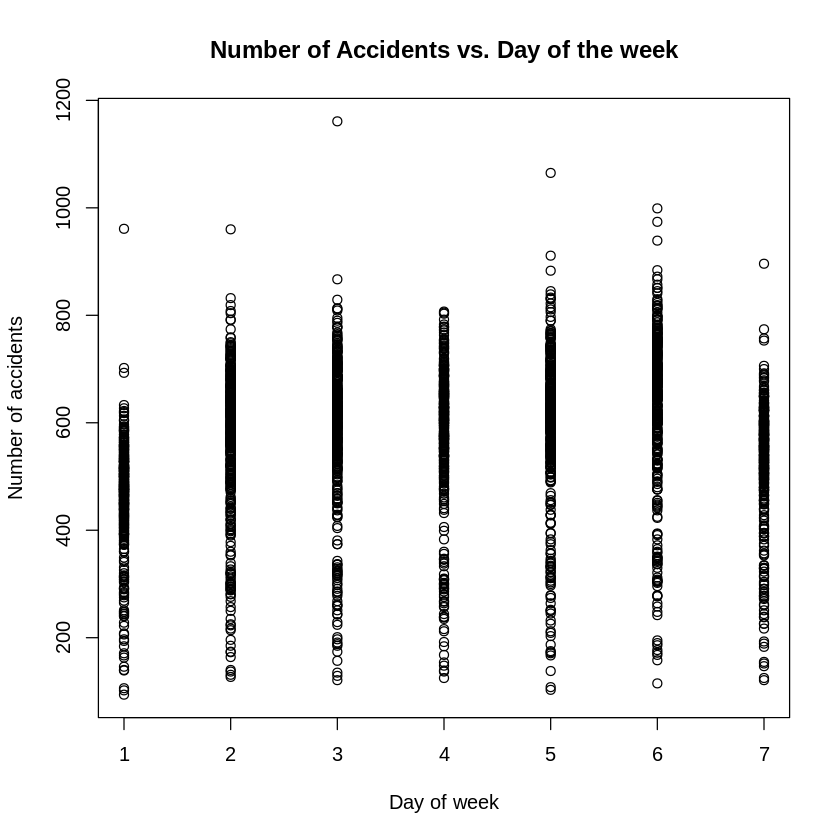

In [ ]:
plot(moveday$dayofweek, moveday$num_accidents, main="Number of Accidents vs. Day of the week", xlab = "Day of week", ylab = "Number of accidents")

In [ ]:
cor(moveday$dayofweek, moveday$num_accidents)

[1] 0.1658257

This change has not made the correlation any stronger.  It has simply changed it from a negative correlation to a positive one and in fact, has slightly weakened the correlation so this will not be taken any further.  Next it will be seen if moving both Sunday and Saturday, so Saturday becomes day 1, has any impact.

### Make Saturday day 1

In [ ]:
movedaysat <- read.csv("https://raw.githubusercontent.com/078373uhi/DAOTW_A1/main/collision_data_c.csv")

In [ ]:
head(movedaysat)

dayofweek day year month date       temp dewp slp    visib wdsp mxpsd gust
1 2         1   2013 1     2013-01-01 38.0 25.6 1008.8 10.0  15.0 21.0  28.0
2 3         2   2013 1     2013-01-02 27.5 12.1 1013.4 10.0  12.4 15.9  25.1
3 4         3   2013 1     2013-01-03 21.8  7.8 1018.1 10.0   9.8 18.1  24.1
4 5         4   2013 1     2013-01-04 32.2 21.1 1015.2 10.0  11.3 22.0  29.9
5 6         5   2013 1     2013-01-05 37.3 24.5 1017.3 10.0  13.2 20.0  28.0
6 7         6   2013 1     2013-01-06 35.7 31.3 1019.7  9.8   5.9 15.0  20.0
  max  min  prcp sndp  fog num_accidents
1 41.0 33.1 0.00 999.9 0   381          
2 33.1 21.9 0.00 999.9 0   480          
3 28.9 16.0 0.00 999.9 0   549          
4 41.0 24.1 0.00 999.9 0   505          
5 42.1 30.9 0.00 999.9 0   389          
6 44.1 23.0 0.01 999.9 0   393


Make Saturday = day 1 and Sunday = day 2

In [ ]:
movedaysat$dayofweek <- movedaysat$dayofweek+2

In [ ]:
head(movedaysat)

dayofweek day year month date       temp dewp slp    visib wdsp mxpsd gust
1 4         1   2013 1     2013-01-01 38.0 25.6 1008.8 10.0  15.0 21.0  28.0
2 5         2   2013 1     2013-01-02 27.5 12.1 1013.4 10.0  12.4 15.9  25.1
3 6         3   2013 1     2013-01-03 21.8  7.8 1018.1 10.0   9.8 18.1  24.1
4 7         4   2013 1     2013-01-04 32.2 21.1 1015.2 10.0  11.3 22.0  29.9
5 8         5   2013 1     2013-01-05 37.3 24.5 1017.3 10.0  13.2 20.0  28.0
6 9         6   2013 1     2013-01-06 35.7 31.3 1019.7  9.8   5.9 15.0  20.0
  max  min  prcp sndp  fog num_accidents
1 41.0 33.1 0.00 999.9 0   381          
2 33.1 21.9 0.00 999.9 0   480          
3 28.9 16.0 0.00 999.9 0   549          
4 41.0 24.1 0.00 999.9 0   505          
5 42.1 30.9 0.00 999.9 0   389          
6 44.1 23.0 0.01 999.9 0   393

In [ ]:
movedaysat$dayofweek[movedaysat$dayofweek == 9] <- 2

In [ ]:
movedaysat$dayofweek[movedaysat$dayofweek == 8] <- 1

Re-plot with Saturday as day 1 of the week.

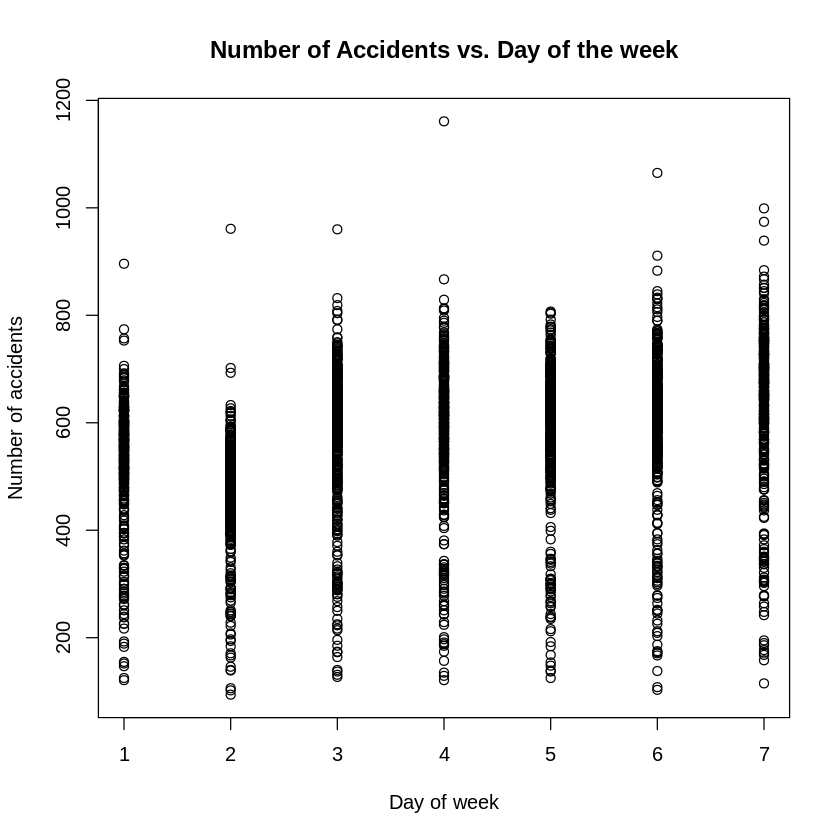

In [ ]:
plot(movedaysat$dayofweek, movedaysat$num_accidents, main="Number of Accidents vs. Day of the week", xlab = "Day of week", ylab = "Number of accidents")

In [ ]:
cor(movedaysat$dayofweek, movedaysat$num_accidents)

[1] 0.2978196

Moving Saturday to be day 1 and Sunday day 2 gives the best linear correlation between day of the week and number of collisions.

## Plot years together to enable removal of outliers

In [ ]:
mds13 <- movedaysat[which(movedaysat$year == 2013), ]

In [ ]:
dayofyear <- 1*seq_len(nrow(mds13))
dayindex <- 1*seq_len(nrow(mds13))
mds13 <- cbind(dayindex, dayofyear, mds13)

In [ ]:
head(mds13, 10)

dayindex dayofyear dayofweek day year month date       temp dewp slp   
1   1        1        4          1  2013 1     2013-01-01 38.0 25.6 1008.8
2   2        2        5          2  2013 1     2013-01-02 27.5 12.1 1013.4
3   3        3        6          3  2013 1     2013-01-03 21.8  7.8 1018.1
4   4        4        7          4  2013 1     2013-01-04 32.2 21.1 1015.2
5   5        5        1          5  2013 1     2013-01-05 37.3 24.5 1017.3
6   6        6        2          6  2013 1     2013-01-06 35.7 31.3 1019.7
7   7        7        3          7  2013 1     2013-01-07 35.9 31.0 1020.5
8   8        8        4          8  2013 1     2013-01-08 39.8 34.1 1028.8
9   9        9        5          9  2013 1     2013-01-09 39.9 37.6 1026.2
10 10       10        6         10  2013 1     2013-01-10 43.5 30.4 1024.0
   visib wdsp mxpsd gust  max  min  prcp sndp  fog num_accidents
1  10.0  15.0 21.0   28.0 41.0 33.1 0.00 999.9 0   381          
2  10.0  12.4 15.9   25.1 33.1 21.9 0.00 999.9 0   480          
3  10.0   9.8 18.1   24.1 28.9 16.0 0.00 999.9 0   549          
4  10.0  11.3 22.0   29.9 41.0 24.1 0.00 999.9 0   505          
5  10.0  13.2 20.0   28.0 42.1 30.9 0.00 999.9 0   389          
6   9.8   5.9 15.0   20.0 44.1 23.0 0.01 999.9 0   393          
7   8.8   8.5 17.1   22.0 42.1 28.0 0.01 999.9 0   521          
8   9.8  10.4 17.1   25.1 48.0 25.0 0.00 999.9 0   513          
9   6.8   5.3 11.1  999.9 46.0 28.0 0.00 999.9 1   487          
10  9.9  14.7 21.0   32.1 48.0 36.0 0.00 999.9 0   555

In [ ]:
mds14 <- movedaysat[which(movedaysat$year == 2014), ]

In [ ]:
mds15 <- movedaysat[which(movedaysat$year == 2015), ]

In [ ]:
mds16 <- movedaysat[which(movedaysat$year == 2016), ]

In [ ]:
mds17 <- movedaysat[which(movedaysat$year == 2017), ]

In [ ]:
mds18 <- movedaysat[which(movedaysat$year == 2018), ]

In [ ]:
mds19 <- movedaysat[which(movedaysat$year == 2019), ]

In [ ]:
dayofyear <- 1*seq_len(nrow(mds14))
dayindex <- 1*seq_len(nrow(mds14)) + 365
mds14 <- cbind(dayindex, dayofyear, mds14)

In [ ]:
dayofyear <- 1*seq_len(nrow(mds15))
dayindex <- 1*seq_len(nrow(mds15)) + 730
mds15 <- cbind(dayindex, dayofyear, mds15)

In [ ]:
dayofyear <- 1*seq_len(nrow(mds16))
dayindex <- 1*seq_len(nrow(mds16)) + 1095
mds16 <- cbind(dayindex, dayofyear, mds16)

In [ ]:
dayofyear <- 1*seq_len(nrow(mds17))
dayindex <- 1*seq_len(nrow(mds17)) + 1461
mds17 <- cbind(dayindex, dayofyear, mds17)

In [ ]:
dayofyear <- 1*seq_len(nrow(mds18))
dayindex <- 1*seq_len(nrow(mds18)) + 1826
mds18 <- cbind(dayindex, dayofyear, mds18)

In [ ]:
dayofyear <- 1*seq_len(nrow(mds19))
dayindex <- 1*seq_len(nrow(mds19)) + 2191
mds19 <- cbind(dayindex, dayofyear, mds19)

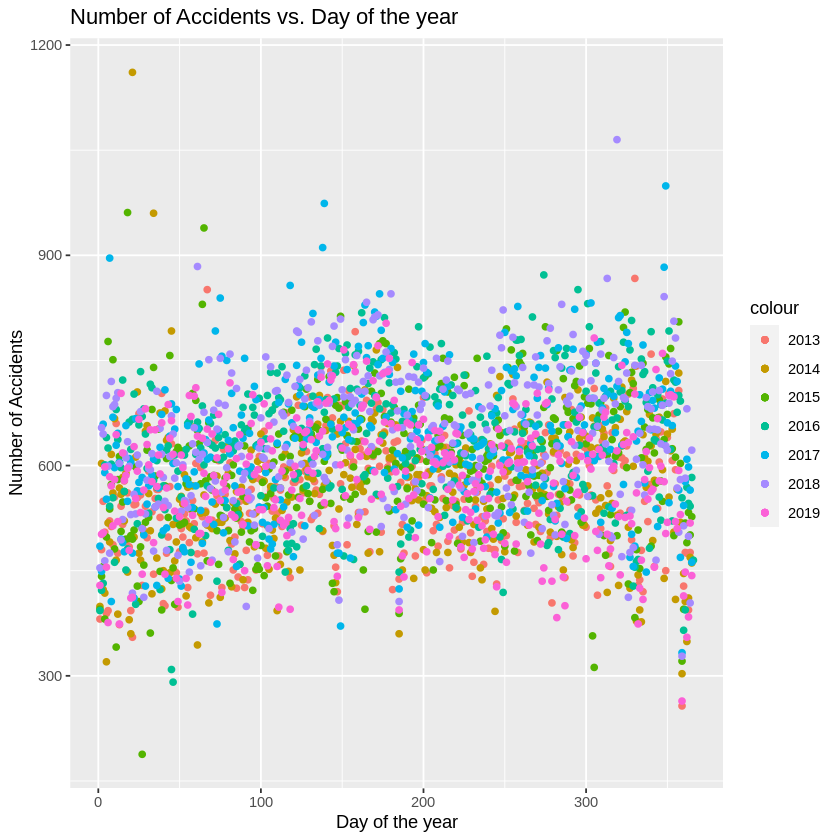

In [ ]:
doy_acc <- ggplot() +
  geom_point(data=mds13, aes(dayofyear, num_accidents, color="2013")) +
  geom_point(data=mds14, aes(dayofyear, num_accidents, color="2014")) +
  geom_point(data=mds15, aes(dayofyear, num_accidents, color="2015")) +
  geom_point(data=mds16, aes(dayofyear, num_accidents, color= "2016")) +
  geom_point(data=mds17, aes(dayofyear, num_accidents, color="2017")) +
  geom_point(data=mds18, aes(dayofyear, num_accidents, color="2018")) +
  geom_point(data=mds19, aes(dayofyear, num_accidents, color= "2019")) +
  ggtitle("Number of Accidents vs. Day of the year") +
  xlab("Day of the year") +
  ylab("Number of Accidents")
  doy_acc

From this plot with the years colour coded on top of each other it has been decided that 900 will be an appropriate maximum and 300 an appropriate minimum to give a cut off for outliers.

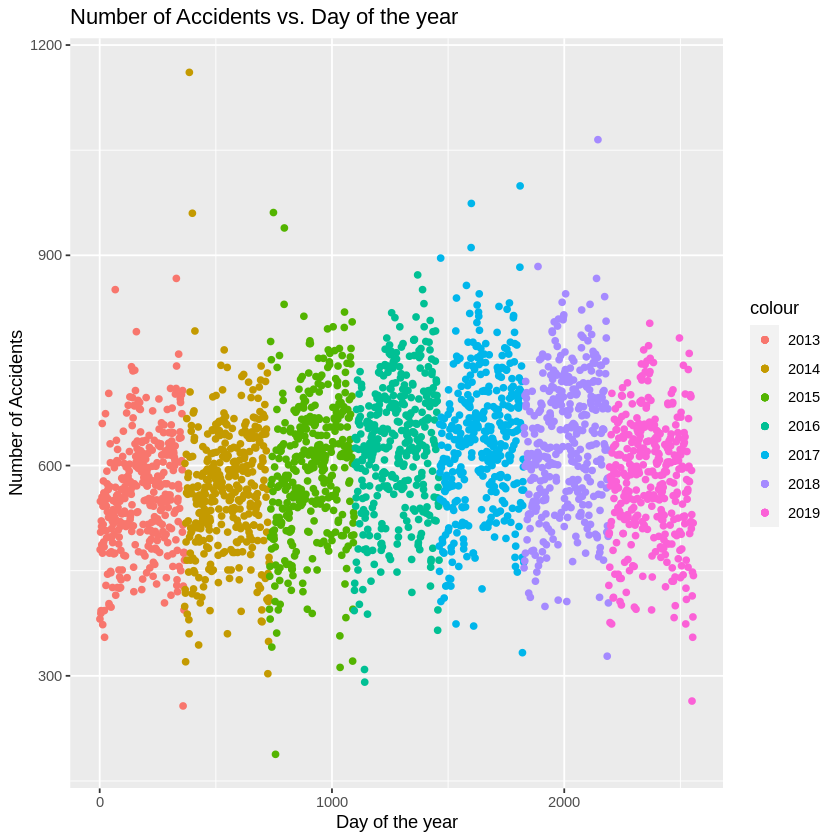

In [ ]:
din_acc <- ggplot() +
  geom_point(data=mds13, aes(dayindex, num_accidents, color="2013")) +
  geom_point(data=mds14, aes(dayindex, num_accidents, color="2014")) +
  geom_point(data=mds15, aes(dayindex, num_accidents, color="2015")) +
  geom_point(data=mds16, aes(dayindex, num_accidents, color= "2016")) +
  geom_point(data=mds17, aes(dayindex, num_accidents, color="2017")) +
  geom_point(data=mds18, aes(dayindex, num_accidents, color="2018")) +
  geom_point(data=mds19, aes(dayindex, num_accidents, color= "2019")) +
  ggtitle("Number of Accidents vs. Day of the year") +
  xlab("Day of the year") +
  ylab("Number of Accidents")
  din_acc

This plot supports the previous decision of 900 and 300 for maximum and minimum values so this will now be applied.  It also shows clearly a general increase year on year in accidents from 2013 until 2018 and then 2019 when it is a bit lower.

### Remove outliers and re-plot to check impact

In [ ]:
mds13 <- mds13[which(mds13$num_accidents >= 300), ]
mds14 <- mds14[which(mds14$num_accidents >= 300), ]
mds15 <- mds15[which(mds15$num_accidents >= 300), ]
mds16 <- mds16[which(mds16$num_accidents >= 300), ]
mds17 <- mds17[which(mds17$num_accidents >= 300), ]
mds18 <- mds18[which(mds18$num_accidents >= 300), ]
mds19 <- mds19[which(mds19$num_accidents >= 300), ]
mds13 <- mds13[which(mds13$num_accidents <= 900), ]
mds14 <- mds14[which(mds14$num_accidents <= 900), ]
mds15 <- mds15[which(mds15$num_accidents <= 900), ]
mds16 <- mds16[which(mds16$num_accidents <= 900), ]
mds17 <- mds17[which(mds17$num_accidents <= 900), ]
mds18 <- mds18[which(mds18$num_accidents <= 900), ]
mds19 <- mds19[which(mds19$num_accidents <= 900), ]

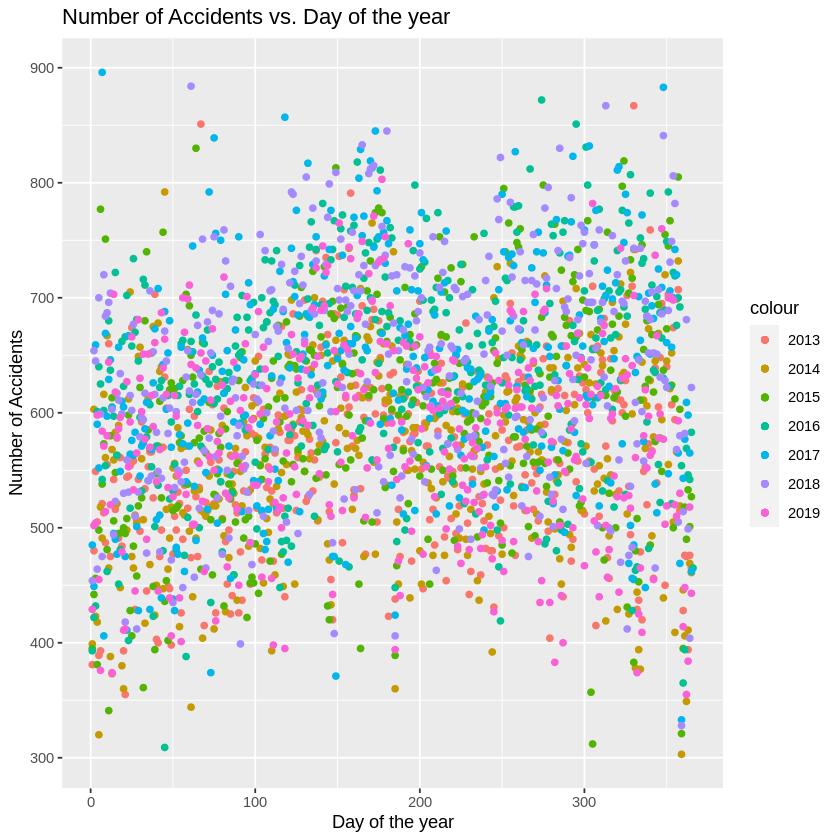

In [ ]:
plot <- ggplot() +
  geom_point(data=mds13, aes(dayofyear, num_accidents, color="2013")) +
  geom_point(data=mds14, aes(dayofyear, num_accidents, color="2014")) +
  geom_point(data=mds15, aes(dayofyear, num_accidents, color="2015")) +
  geom_point(data=mds16, aes(dayofyear, num_accidents, color= "2016")) +
  geom_point(data=mds17, aes(dayofyear, num_accidents, color="2017")) +
  geom_point(data=mds18, aes(dayofyear, num_accidents, color="2018")) +
  geom_point(data=mds19, aes(dayofyear, num_accidents, color= "2019")) +
  ggtitle("Number of Accidents vs. Day of the year") +
  xlab("Day of the year") +
  ylab("Number of Accidents")
  plot

From this, it is felt that the cutoffs will be revised to 350 minimum and 850 maximum so this will be undertaken now.

In [ ]:
mds13 <- mds13[which(mds13$num_accidents >= 350), ]
mds14 <- mds14[which(mds14$num_accidents >= 350), ]
mds15 <- mds15[which(mds15$num_accidents >= 350), ]
mds16 <- mds16[which(mds16$num_accidents >= 350), ]
mds17 <- mds17[which(mds17$num_accidents >= 350), ]
mds18 <- mds18[which(mds18$num_accidents >= 350), ]
mds19 <- mds19[which(mds19$num_accidents >= 350), ]
mds13 <- mds13[which(mds13$num_accidents <= 850), ]
mds14 <- mds14[which(mds14$num_accidents <= 850), ]
mds15 <- mds15[which(mds15$num_accidents <= 850), ]
mds16 <- mds16[which(mds16$num_accidents <= 850), ]
mds17 <- mds17[which(mds17$num_accidents <= 850), ]
mds18 <- mds18[which(mds18$num_accidents <= 850), ]
mds19 <- mds19[which(mds19$num_accidents <= 850), ]

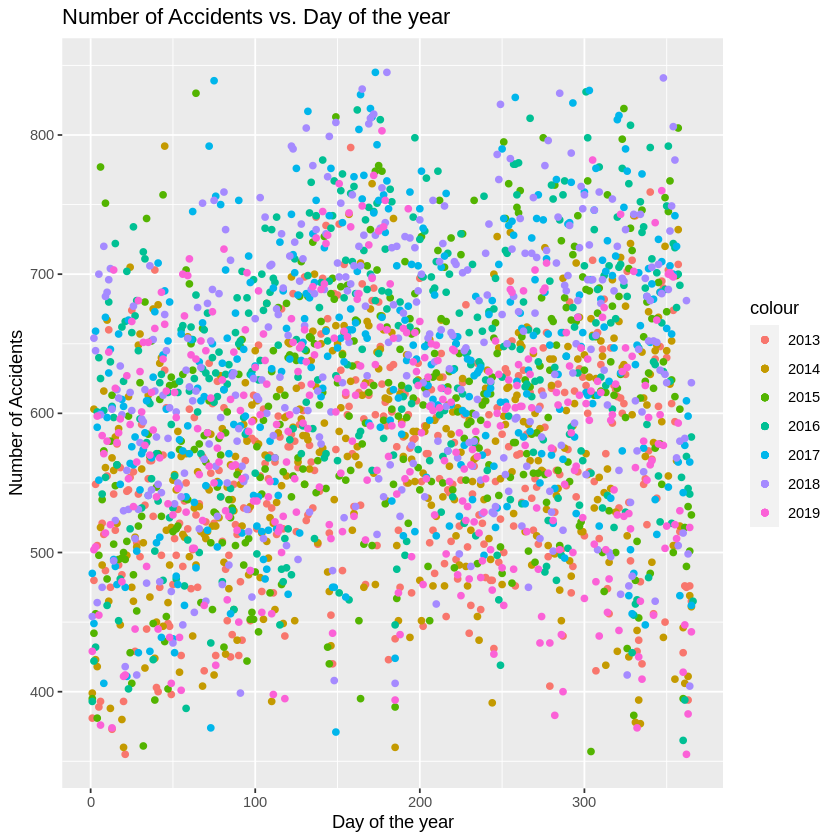

In [ ]:
plot2 <- ggplot() +
  geom_point(data=mds13, aes(dayofyear, num_accidents, color="2013")) +
  geom_point(data=mds14, aes(dayofyear, num_accidents, color="2014")) +
  geom_point(data=mds15, aes(dayofyear, num_accidents, color="2015")) +
  geom_point(data=mds16, aes(dayofyear, num_accidents, color= "2016")) +
  geom_point(data=mds17, aes(dayofyear, num_accidents, color="2017")) +
  geom_point(data=mds18, aes(dayofyear, num_accidents, color="2018")) +
  geom_point(data=mds19, aes(dayofyear, num_accidents, color= "2019")) +
  ggtitle("Number of Accidents vs. Day of the year") +
  xlab("Day of the year") +
  ylab("Number of Accidents")
  plot2

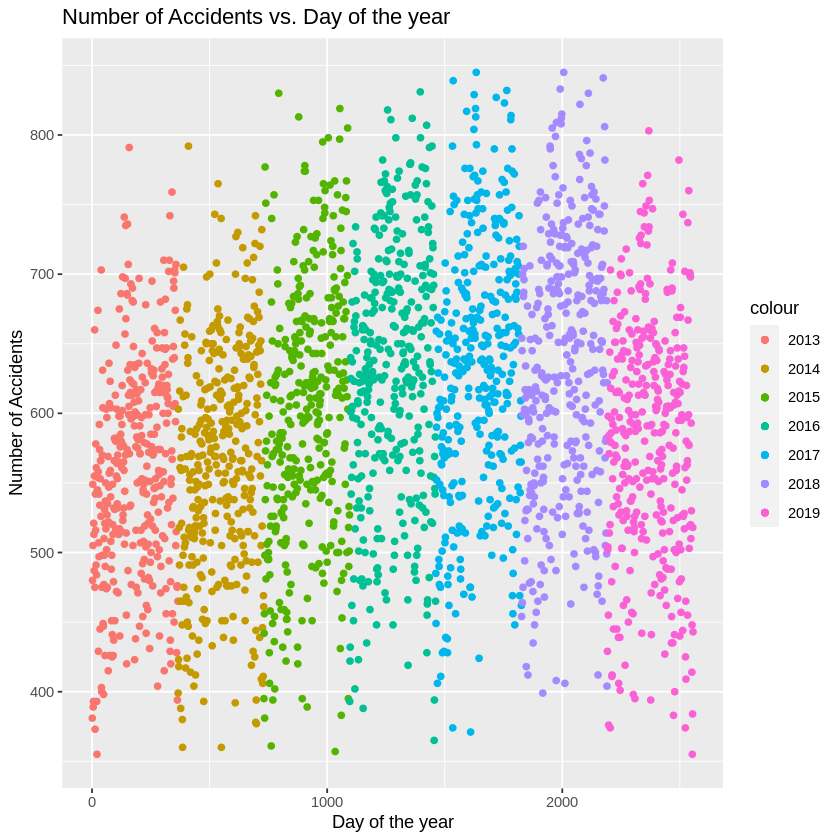

In [ ]:
years <- ggplot() +
  geom_point(data=mds13, aes(dayindex, num_accidents, color="2013")) +
  geom_point(data=mds14, aes(dayindex, num_accidents, color="2014")) +
  geom_point(data=mds15, aes(dayindex, num_accidents, color="2015")) +
  geom_point(data=mds16, aes(dayindex, num_accidents, color= "2016")) +
  geom_point(data=mds17, aes(dayindex, num_accidents, color="2017")) +
  geom_point(data=mds18, aes(dayindex, num_accidents, color="2018")) +
  geom_point(data=mds19, aes(dayindex, num_accidents, color= "2019")) +
  ggtitle("Number of Accidents vs. Day of the year") +
  xlab("Day of the year") +
  ylab("Number of Accidents")
  years

Removing the outliers makes for much neater plots and clearly displays the annual patterns and general increase therefore the data will now undergo normalisation to allow it to be shown on a common scale.  



## Normalisation of data

 

This will rescale the data into the range 0, 1. 

In [ ]:
summary(mds13$num_accidents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  355.0   505.0   557.5   557.3   612.8   791.0 

In [ ]:
mds13$num_accidents <- (mds13$num_accidents-355)/(791-355)

In [ ]:
summary(mds14$num_accidents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  360.0   511.5   568.0   564.3   622.5   792.0 

In [ ]:
mds14$num_accidents <- (mds14$num_accidents-360)/(792-360)

In [ ]:
summary(mds15$num_accidents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  357.0   535.5   603.0   597.9   666.0   830.0 

In [ ]:
mds15$num_accidents <- (mds15$num_accidents-357)/(830-357)

In [ ]:
summary(mds16$num_accidents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  365.0   569.0   635.0   628.5   695.8   831.0 

In [ ]:
mds16$num_accidents <- (mds16$num_accidents-365)/(831-365)

In [ ]:
summary(mds17$num_accidents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  371.0   568.5   634.5   628.9   694.0   845.0 

In [ ]:
mds17$num_accidents <- (mds17$num_accidents-371)/(845-371)

In [ ]:
summary(mds18$num_accidents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  399.0   562.0   633.0   632.7   706.0   845.0 

In [ ]:
mds18$num_accidents <- (mds18$num_accidents-399)/(845-399)

In [ ]:
summary(mds19$num_accidents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  355.0   522.0   589.0   580.3   641.2   803.0 

In [ ]:
mds19$num_accidents <- (mds19$num_accidents-355)/(803-355)

## Create plots using normalised data

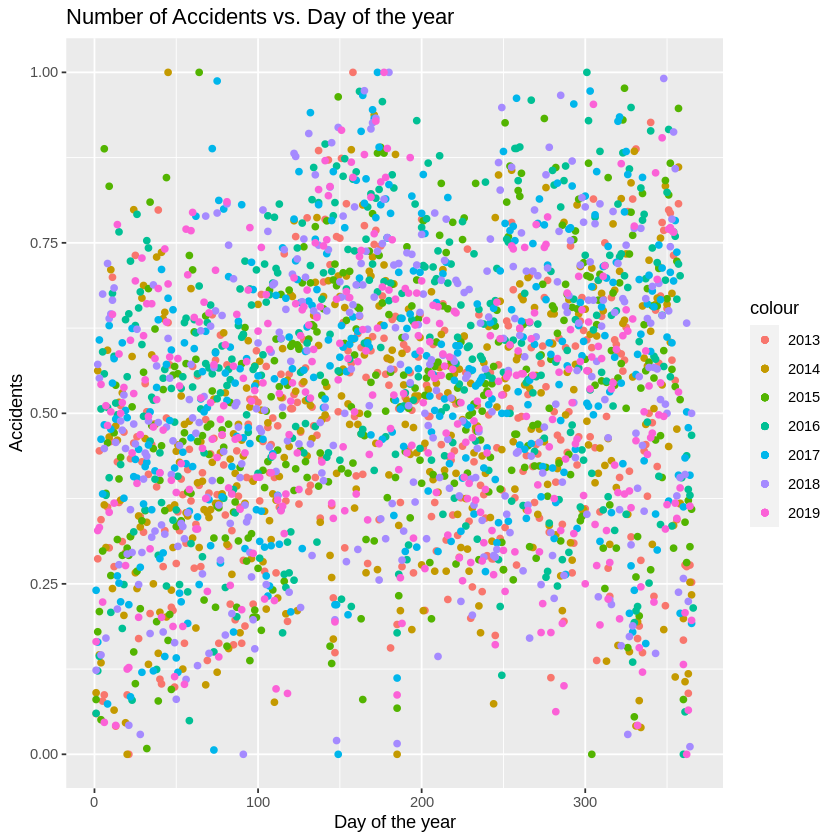

In [ ]:
nplot2 <- ggplot() +
  geom_point(data=mds13, aes(dayofyear, num_accidents, color="2013")) +
  geom_point(data=mds14, aes(dayofyear, num_accidents, color="2014")) +
  geom_point(data=mds15, aes(dayofyear, num_accidents, color="2015")) +
  geom_point(data=mds16, aes(dayofyear, num_accidents, color= "2016")) +
  geom_point(data=mds17, aes(dayofyear, num_accidents, color="2017")) +
  geom_point(data=mds18, aes(dayofyear, num_accidents, color="2018")) +
  geom_point(data=mds19, aes(dayofyear, num_accidents, color= "2019")) +
  ggtitle("Number of Accidents vs. Day of the year") +
  xlab("Day of the year") +
  ylab("Accidents")
  nplot2

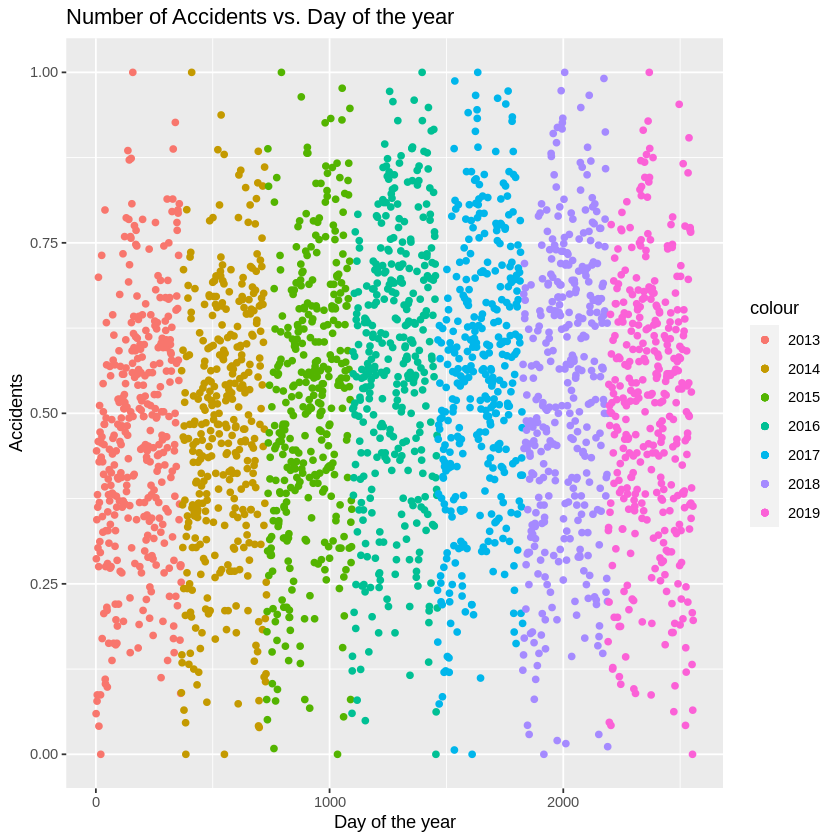

In [ ]:
nyears <- ggplot() +
  geom_point(data=mds13, aes(dayindex, num_accidents, color="2013")) +
  geom_point(data=mds14, aes(dayindex, num_accidents, color="2014")) +
  geom_point(data=mds15, aes(dayindex, num_accidents, color="2015")) +
  geom_point(data=mds16, aes(dayindex, num_accidents, color= "2016")) +
  geom_point(data=mds17, aes(dayindex, num_accidents, color="2017")) +
  geom_point(data=mds18, aes(dayindex, num_accidents, color="2018")) +
  geom_point(data=mds19, aes(dayindex, num_accidents, color= "2019")) +
  ggtitle("Number of Accidents vs. Day of the year") +
  xlab("Day of the year") +
  ylab("Accidents")
  nyears

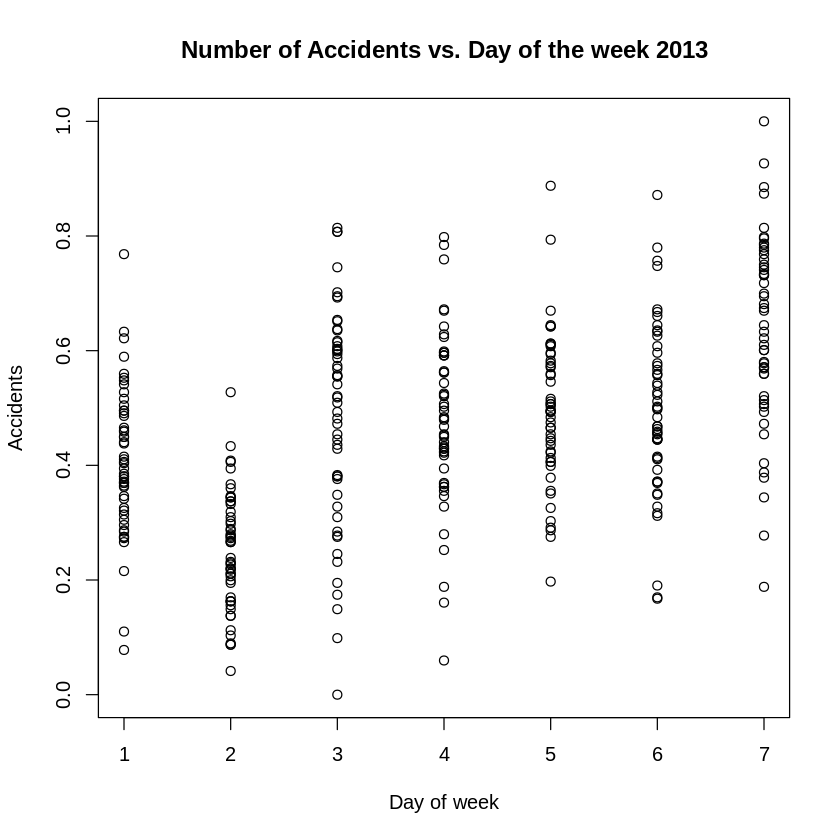

In [ ]:
plot(mds13$dayofweek, mds13$num_accidents, main="Number of Accidents vs. Day of the week 2013", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mds13$dayofweek, mds13$num_accidents)

[1] 0.4690141

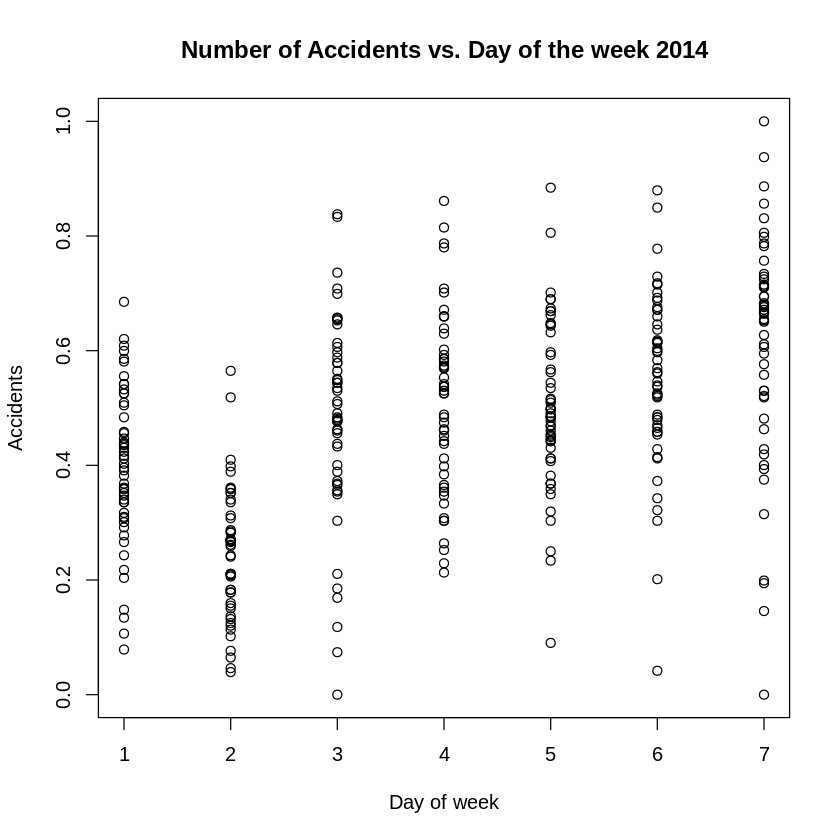

In [ ]:
plot(mds14$dayofweek, mds14$num_accidents, main="Number of Accidents vs. Day of the week 2014", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mds14$dayofweek, mds14$num_accidents)

[1] 0.4702915

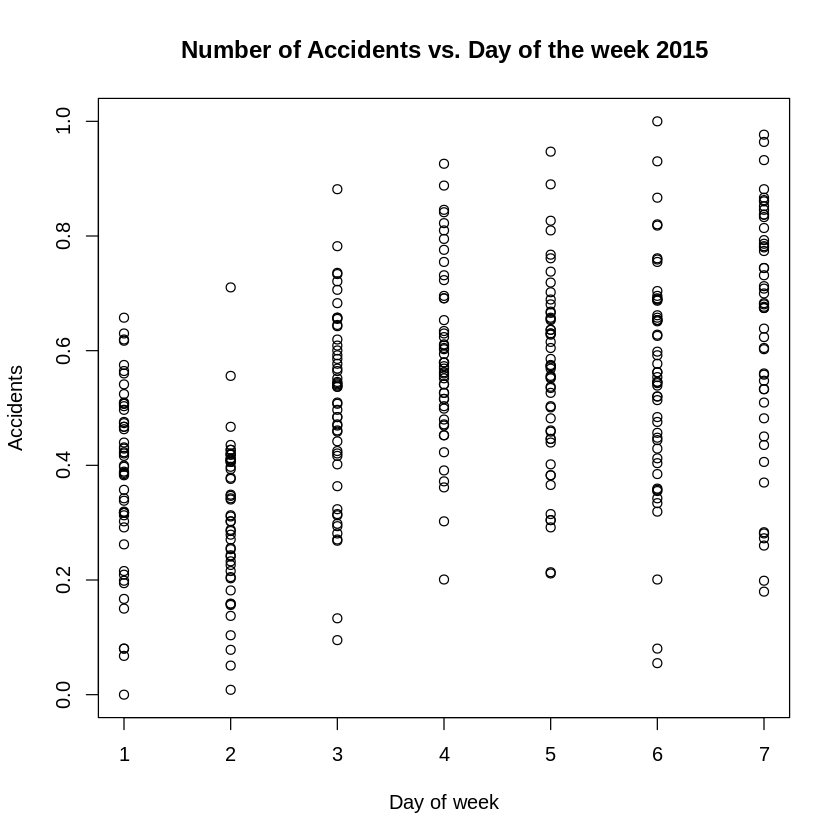

In [ ]:
plot(mds15$dayofweek, mds15$num_accidents, main="Number of Accidents vs. Day of the week 2015", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mds15$dayofweek, mds15$num_accidents)

[1] 0.4751389

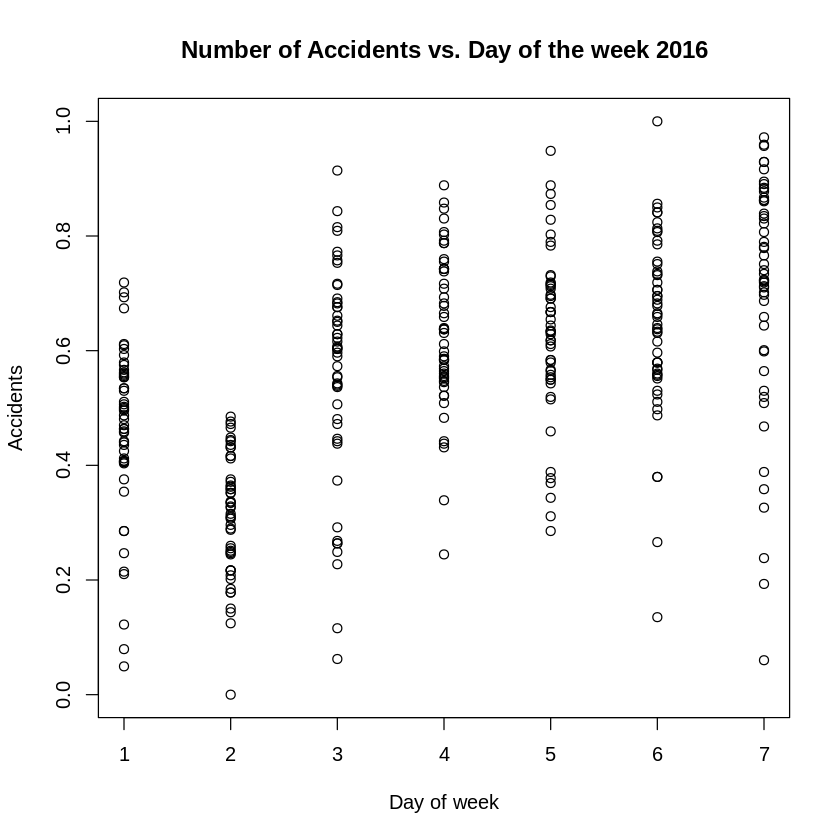

In [ ]:
plot(mds16$dayofweek, mds16$num_accidents, main="Number of Accidents vs. Day of the week 2016", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mds16$dayofweek, mds16$num_accidents)

[1] 0.5222944

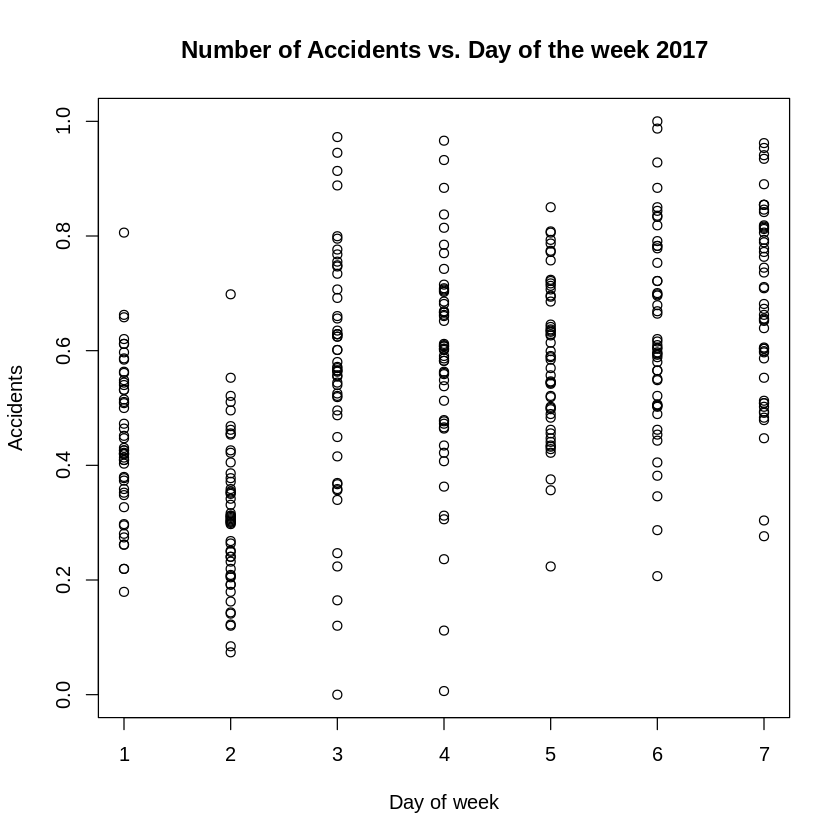

In [ ]:
plot(mds17$dayofweek, mds17$num_accidents, main="Number of Accidents vs. Day of the week 2017", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mds17$dayofweek, mds17$num_accidents)

[1] 0.494313

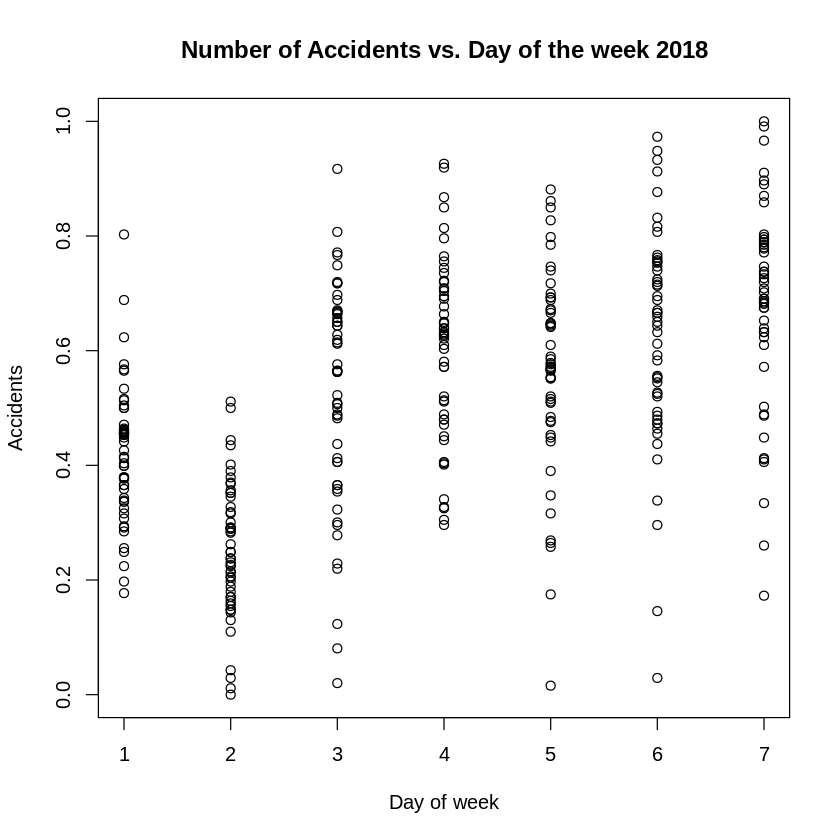

In [ ]:
plot(mds18$dayofweek, mds18$num_accidents, main="Number of Accidents vs. Day of the week 2018", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mds18$dayofweek, mds18$num_accidents)

[1] 0.5279133

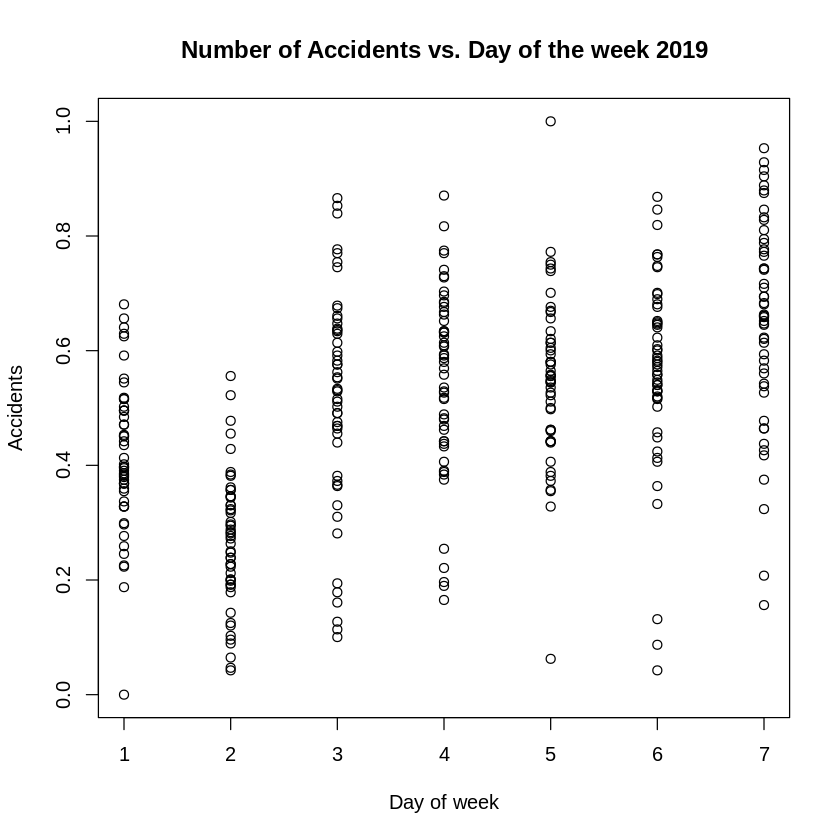

In [ ]:
plot(mds19$dayofweek, mds19$num_accidents, main="Number of Accidents vs. Day of the week 2019", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mds19$dayofweek, mds19$num_accidents)

[1] 0.4961035

These plots show a fairly strong correlation between day of the week and number of accidents ranging from a correlation of 0.47 in 2013/2014/2015 to 0.53 in 2018.

## Combine years again

In [ ]:
mdscombined <- rbind(mds13, mds14, mds15, mds16, mds17, mds18, mds19)

In [ ]:
mdscombined

dayindex dayofyear dayofweek day year month date       temp dewp slp   
1     1        1        4          1  2013 1     2013-01-01 38.0 25.6 1008.8
2     2        2        5          2  2013 1     2013-01-02 27.5 12.1 1013.4
3     3        3        6          3  2013 1     2013-01-03 21.8  7.8 1018.1
4     4        4        7          4  2013 1     2013-01-04 32.2 21.1 1015.2
5     5        5        1          5  2013 1     2013-01-05 37.3 24.5 1017.3
6     6        6        2          6  2013 1     2013-01-06 35.7 31.3 1019.7
7     7        7        3          7  2013 1     2013-01-07 35.9 31.0 1020.5
8     8        8        4          8  2013 1     2013-01-08 39.8 34.1 1028.8
9     9        9        5          9  2013 1     2013-01-09 39.9 37.6 1026.2
10   10       10        6         10  2013 1     2013-01-10 43.5 30.4 1024.0
11   11       11        7         11  2013 1     2013-01-11 38.0 31.4 1030.6
12   12       12        1         12  2013 1     2013-01-12 42.7 41.5 1022.6
13   13       13        2         13  2013 1     2013-01-13 45.4 44.9 1020.7
14   14       14        3         14  2013 1     2013-01-14 47.2 47.1 1017.5
15   15       15        4         15  2013 1     2013-01-15 42.3 38.3 1023.1
16   16       16        5         16  2013 1     2013-01-16 41.6 40.0 1018.3
17   17       17        6         17  2013 1     2013-01-17 39.4 34.6 1014.2
18   18       18        7         18  2013 1     2013-01-18 28.1 16.6 1023.2
19   19       19        1         19  2013 1     2013-01-19 35.9 26.6 1026.4
20   20       20        2         20  2013 1     2013-01-20 46.3 41.2 1010.0
21   21       21        3         21  2013 1     2013-01-21 31.2 16.0 1015.5
22   22       22        4         22  2013 1     2013-01-22 26.3 18.1 1011.1
23   23       23        5         23  2013 1     2013-01-23 16.2 -1.1 1018.6
24   24       24        6         24  2013 1     2013-01-24 14.3 -1.9 1018.7
25   25       25        7         25  2013 1     2013-01-25 19.0  3.3 1023.1
26   26       26        1         26  2013 1     2013-01-26 24.4 16.6 1016.4
27   27       27        2         27  2013 1     2013-01-27 21.7  4.7 1025.6
28   28       28        3         28  2013 1     2013-01-28 27.3 10.8 1028.9
29   29       29        4         29  2013 1     2013-01-29 35.4 34.9 1019.0
30   30       30        5         30  2013 1     2013-01-30 45.1 44.0 1013.9
⋮    ⋮        ⋮         ⋮         ⋮   ⋮    ⋮     ⋮          ⋮    ⋮    ⋮     
2526 2526     335       2          1  2019 12    2019-12-01 36.7 26.8 1014.3
2527 2527     336       3          2  2019 12    2019-12-02 44.8 41.3  996.1
2528 2528     337       4          3  2019 12    2019-12-03 39.9 36.3  990.8
2529 2529     338       5          4  2019 12    2019-12-04 36.6 27.4  998.7
2530 2530     339       6          5  2019 12    2019-12-05 39.6 30.2 1002.0
2531 2531     340       7          6  2019 12    2019-12-06 38.3 25.4 1016.2
2532 2532     341       1          7  2019 12    2019-12-07 36.4 25.7 1022.2
2533 2533     342       2          8  2019 12    2019-12-08 31.8 19.5 1032.5
2534 2534     343       3          9  2019 12    2019-12-09 48.2 43.6 1024.0
2535 2535     344       4         10  2019 12    2019-12-10 53.1 51.0 1010.4
2536 2536     345       5         11  2019 12    2019-12-11 39.9 36.7 1020.1
2537 2537     346       6         12  2019 12    2019-12-12 31.1 19.7 1034.8
2538 2538     347       7         13  2019 12    2019-12-13 38.7 31.8 1033.4
2539 2539     348       1         14  2019 12    2019-12-14 52.7 51.3 1010.4
2540 2540     349       2         15  2019 12    2019-12-15 47.7 38.4 1001.7
2541 2541     350       3         16  2019 12    2019-12-16 35.4 19.8 1020.9
2542 2542     351       4         17  2019 12    2019-12-17 37.5 32.0 1012.7
2543 2543     352       5         18  2019 12    2019-12-18 39.3 35.2 1004.4
2544 2544     353       6         19  2019 12    2019-12-19 24.2  8.3 1016.0
2545 2545     354       7         20  2019 12    2019-12-20 24.2 11.6 1027.8
2

## Create final plots to check correlations and confirm variables selected

In [ ]:
cor(mdscombined$dayofyear, mdscombined$num_accidents)

[1] 0.1748039

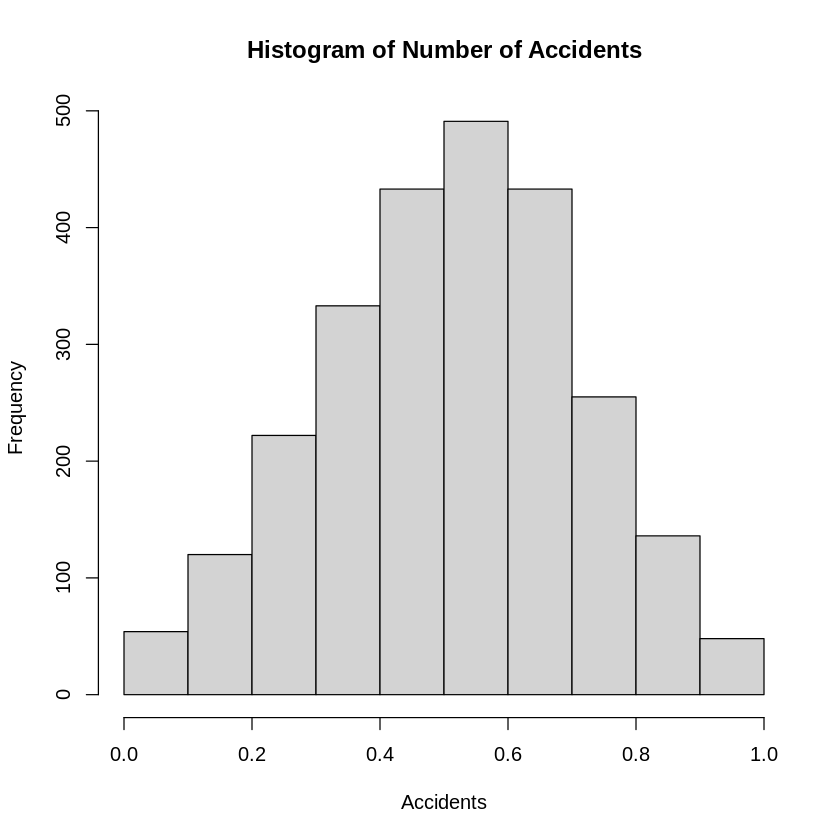

In [ ]:
hist(mdscombined$num_accidents, breaks =10, main = "Histogram of Number of Accidents", xlab = "Accidents")

This shows a normal distribution for the number of accidents.

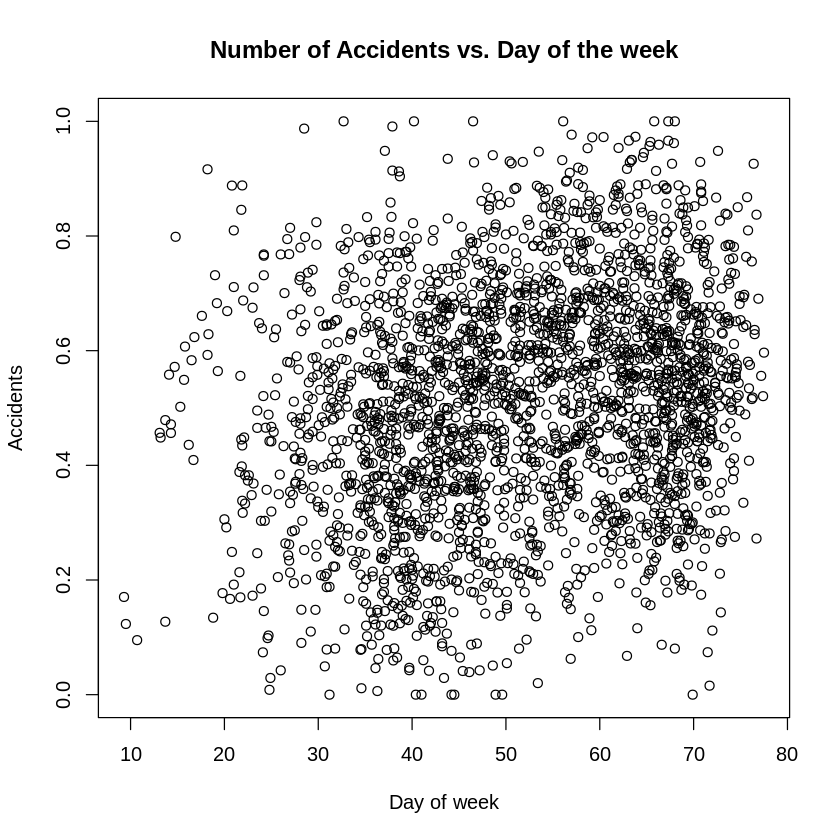

In [ ]:
plot(mdscombined$temp, mdscombined$num_accidents, main="Number of Accidents vs. Day of the week", xlab = "Day of week", ylab = "Accidents")

In [ ]:
cor(mdscombined$temp, mdscombined$num_accidents)

[1] 0.2234181

In [ ]:
cor(mdscombined$fog, mdscombined$num_accidents)

[1] 0.07817299

In [ ]:
cor(mdscombined$visib, mdscombined$num_accidents)

[1] -0.06484403

The variables to be used for the models are day of the week, temperature, fog and visibility as these showed the highest correlations with number of accidents.  A variety of different combinations of these variables will now be saved as csv files to enable them to be used in Linear Regression and Deep Neural Network models.

# Create data for linear regression models

In [ ]:
head(mdscombined)

dayindex dayofyear dayofweek day year month date       temp dewp slp    visib
1 1        1         4         1   2013 1     2013-01-01 38.0 25.6 1008.8 10.0 
2 2        2         5         2   2013 1     2013-01-02 27.5 12.1 1013.4 10.0 
3 3        3         6         3   2013 1     2013-01-03 21.8  7.8 1018.1 10.0 
4 4        4         7         4   2013 1     2013-01-04 32.2 21.1 1015.2 10.0 
5 5        5         1         5   2013 1     2013-01-05 37.3 24.5 1017.3 10.0 
6 6        6         2         6   2013 1     2013-01-06 35.7 31.3 1019.7  9.8 
  wdsp mxpsd gust max  min  prcp sndp  fog num_accidents
1 15.0 21.0  28.0 41.0 33.1 0.00 999.9 0   0.05963303   
2 12.4 15.9  25.1 33.1 21.9 0.00 999.9 0   0.28669725   
3  9.8 18.1  24.1 28.9 16.0 0.00 999.9 0   0.44495413   
4 11.3 22.0  29.9 41.0 24.1 0.00 999.9 0   0.34403670   
5 13.2 20.0  28.0 42.1 30.9 0.00 999.9 0   0.07798165   
6  5.9 15.0  20.0 44.1 23.0 0.01 999.9 0   0.08715596

Day of the week and number of accidents

In [ ]:
lrdata_dow_numacc <- mdscombined[,c(3,20)]

In [ ]:
write.csv(lrdata_dow_numacc, file="/content/lrdata_dow_numacc.csv")

Day of the week, temp and number of accidents

In [ ]:
lrdata_dow_temp_numacc <- mdscombined[,c(3,8,20)]

In [ ]:
write.csv(lrdata_dow_temp_numacc, file="/content/lrdata_dow_temp_numacc.csv")

Day of the week, fog and number of accidents

In [ ]:
lrdata_dow_fog_numacc <- mdscombined[,c(3,19,20)]

In [ ]:
write.csv(lrdata_dow_fog_numacc, file="/content/lrdata_dow_fog_numacc.csv")

Day of the week, visib and number of accidents

In [ ]:
lrdata_dow_visib_numacc <- mdscombined[,c(3,11,20)]

In [ ]:
write.csv(lrdata_dow_visib_numacc, file="/content/lrdata_dow_visib_numacc.csv")

Day of the week, temp, fog and number of accidents

In [ ]:
lrdata_tempfog_numacc <- mdscombined[,c(3,8, 19, 20)]

In [ ]:
write.csv(lrdata_tempfog_numacc, file="/content/lrdata_tempfog_numacc.csv")

Day of the week, temp, visib and number of accidents

In [ ]:
lrdata_tempvisib_numacc <- mdscombined[,c(3,8, 11, 20)]

In [ ]:
write.csv(lrdata_tempvisib_numacc, file="/content/lrdata_tempvisib_numacc.csv")

Day of the week, fog, visib and number of accidents

In [ ]:
lrdata_fogvisib_numacc <- mdscombined[,c(3, 19, 11, 20)]

In [ ]:
write.csv(lrdata_fogvisib_numacc, file="/content/lrdata_fogvisib_numacc.csv")

Day of the week, temp, fog, visib and number of accidents

In [ ]:
lrdata_tempfogvisib_numacc <- mdscombined[,c(3,8, 11, 19, 20)]

In [ ]:
write.csv(lrdata_tempfogvisib_numacc, file="/content/lrdata_tempfogvisib_numacc.csv")

# Create data for Deep Neural Networks

In [ ]:
mdscombined2 <- mdscombined

Ensure months are text

In [ ]:
mdscombined2$month[mdscombined2$month == 1] <- 'Jan'
mdscombined2$month[mdscombined2$month == 2] <- 'Feb'
mdscombined2$month[mdscombined2$month == 3] <- 'Mar'
mdscombined2$month[mdscombined2$month == 4] <- 'Apr'
mdscombined2$month[mdscombined2$month == 5] <- 'May'
mdscombined2$month[mdscombined2$month == 6] <- 'Jun'
mdscombined2$month[mdscombined2$month == 7] <- 'Jul'
mdscombined2$month[mdscombined2$month == 8] <- 'Aug'
mdscombined2$month[mdscombined2$month == 9] <- 'Sep'
mdscombined2$month[mdscombined2$month == 10] <- 'Oct'
mdscombined2$month[mdscombined2$month == 11] <- 'Nov'
mdscombined2$month[mdscombined2$month == 12] <- 'Dec'

Ensure days are text

In [ ]:
mdscombined2$dayofweek[mdscombined2$dayofweek == 1] <- 'Sat'
mdscombined2$dayofweek[mdscombined2$dayofweek == 2] <- 'Sun'
mdscombined2$dayofweek[mdscombined2$dayofweek == 3] <- 'Mon'
mdscombined2$dayofweek[mdscombined2$dayofweek == 4] <- 'Tue'
mdscombined2$dayofweek[mdscombined2$dayofweek == 5] <- 'Wed'
mdscombined2$dayofweek[mdscombined2$dayofweek == 6] <- 'Thu'
mdscombined2$dayofweek[mdscombined2$dayofweek == 7] <- 'Fri'

Check amended data

In [ ]:
head(mdscombined2)

dayindex dayofyear dayofweek day year month date       temp dewp slp    visib
1 1        1         Tue       1   2013 Jan   2013-01-01 38.0 25.6 1008.8 10.0 
2 2        2         Wed       2   2013 Jan   2013-01-02 27.5 12.1 1013.4 10.0 
3 3        3         Thu       3   2013 Jan   2013-01-03 21.8  7.8 1018.1 10.0 
4 4        4         Fri       4   2013 Jan   2013-01-04 32.2 21.1 1015.2 10.0 
5 5        5         Sat       5   2013 Jan   2013-01-05 37.3 24.5 1017.3 10.0 
6 6        6         Sun       6   2013 Jan   2013-01-06 35.7 31.3 1019.7  9.8 
  wdsp mxpsd gust max  min  prcp sndp  fog num_accidents
1 15.0 21.0  28.0 41.0 33.1 0.00 999.9 0   0.05963303   
2 12.4 15.9  25.1 33.1 21.9 0.00 999.9 0   0.28669725   
3  9.8 18.1  24.1 28.9 16.0 0.00 999.9 0   0.44495413   
4 11.3 22.0  29.9 41.0 24.1 0.00 999.9 0   0.34403670   
5 13.2 20.0  28.0 42.1 30.9 0.00 999.9 0   0.07798165   
6  5.9 15.0  20.0 44.1 23.0 0.01 999.9 0   0.08715596

Apply one-hot encoding to months

In [ ]:
months <- model.matrix(~0+mdscombined2$month)
head(months)

mdscombined2$monthApr mdscombined2$monthAug mdscombined2$monthDec
1 0                     0                     0                    
2 0                     0                     0                    
3 0                     0                     0                    
4 0                     0                     0                    
5 0                     0                     0                    
6 0                     0                     0                    
  mdscombined2$monthFeb mdscombined2$monthJan mdscombined2$monthJul
1 0                     1                     0                    
2 0                     1                     0                    
3 0                     1                     0                    
4 0                     1                     0                    
5 0                     1                     0                    
6 0                     1                     0                    
  mdscombined2$monthJun mdscombined2$monthMar mdscombined2$monthMay
1 0                     0                     0                    
2 0                     0                     0                    
3 0                     0                     0                    
4 0                     0                     0                    
5 0                     0                     0                    
6 0                     0                     0                    
  mdscombined2$monthNov mdscombined2$monthOct mdscombined2$monthSep
1 0                     0                     0                    
2 0                     0                     0                    
3 0                     0                     0                    
4 0                     0                     0                    
5 0                     0                     0                    
6 0                     0                     0

In [ ]:
colnames(months) <- c("Apr", "Aug", "Dec", "Feb", "Jan", "Jul", "Jun", "Mar", "May", "Nov", "Oct", "Sep")
head(months)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov Oct Sep
1 0   0   0   0   1   0   0   0   0   0   0   0  
2 0   0   0   0   1   0   0   0   0   0   0   0  
3 0   0   0   0   1   0   0   0   0   0   0   0  
4 0   0   0   0   1   0   0   0   0   0   0   0  
5 0   0   0   0   1   0   0   0   0   0   0   0  
6 0   0   0   0   1   0   0   0   0   0   0   0

Apply one-hot encoding to days of the week

In [ ]:
daysofweek <- model.matrix(~0+mdscombined2$dayofweek)
head(daysofweek)

mdscombined2$dayofweekFri mdscombined2$dayofweekMon mdscombined2$dayofweekSat
1 0                         0                         0                        
2 0                         0                         0                        
3 0                         0                         0                        
4 1                         0                         0                        
5 0                         0                         1                        
6 0                         0                         0                        
  mdscombined2$dayofweekSun mdscombined2$dayofweekThu mdscombined2$dayofweekTue
1 0                         0                         1                        
2 0                         0                         0                        
3 0                         1                         0                        
4 0                         0                         0                        
5 0                         0                         0                        
6 1                         0                         0                        
  mdscombined2$dayofweekWed
1 0                        
2 1                        
3 0                        
4 0                        
5 0                        
6 0

In [ ]:
colnames(daysofweek) <- c("Fri", "Mon", "Sat", "Sun", "Thu", "Tue", "Wed")
head(daysofweek)

Fri Mon Sat Sun Thu Tue Wed
1 0   0   0   0   0   1   0  
2 0   0   0   0   0   0   1  
3 0   0   0   0   1   0   0  
4 1   0   0   0   0   0   0  
5 0   0   1   0   0   0   0  
6 0   0   0   1   0   0   0

Day of the week and number of accidents

In [ ]:
dnndata_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$num_accidents)


In [ ]:
colnames(dnndata_numacc)[which(names(dnndata_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_numacc)[which(names(dnndata_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"


In [ ]:
head(dnndata_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Sep Fri Mon Sat Sun Thu Tue Wed
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   1   0  
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   0   1  
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   1   0   0  
4 0   0   0   0   1   0   0   0   0   0   ⋯ 0   1   0   0   0   0   0   0  
5 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   0   0   0  
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   0   0   0  
  year number_of_accidents
1 2013 0.05963303         
2 2013 0.28669725         
3 2013 0.44495413         
4 2013 0.34403670         
5 2013 0.07798165         
6 2013 0.08715596

In [ ]:
summary(dnndata_numacc)

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_numacc, file="/content/dnndata_numacc.csv")

Day of the week, temp and number of accidents

In [ ]:
dnndata_temp_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$temp, mdscombined2$num_accidents)


In [ ]:
colnames(dnndata_temp_numacc)[which(names(dnndata_temp_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_temp_numacc)[which(names(dnndata_temp_numacc) == "mdscombined2.temp")] <- "temp"
colnames(dnndata_temp_numacc)[which(names(dnndata_temp_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"


In [ ]:
head(dnndata_temp_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Fri Mon Sat Sun Thu Tue Wed year
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   1   0   2013
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   1   2013
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   0   0   2013
4 0   0   0   0   1   0   0   0   0   0   ⋯ 1   0   0   0   0   0   0   2013
5 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   1   0   0   0   0   2013
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   0   0   2013
  temp number_of_accidents
1 38.0 0.05963303         
2 27.5 0.28669725         
3 21.8 0.44495413         
4 32.2 0.34403670         
5 37.3 0.07798165         
6 35.7 0.08715596

In [ ]:
summary(dnndata_temp_numacc)

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_temp_numacc, file="/content/dnndata_temp_numacc.csv")

Day of the week, visib and number of accidents

In [ ]:
dnndata_visib_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$visib, mdscombined2$num_accidents)

In [ ]:
colnames(dnndata_visib_numacc)[which(names(dnndata_visib_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_visib_numacc)[which(names(dnndata_visib_numacc) == "mdscombined2.visib")] <- "visib"
colnames(dnndata_visib_numacc)[which(names(dnndata_visib_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"

In [ ]:
head(dnndata_visib_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Fri Mon Sat Sun Thu Tue Wed year
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   1   0   2013
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   1   2013
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   0   0   2013
4 0   0   0   0   1   0   0   0   0   0   ⋯ 1   0   0   0   0   0   0   2013
5 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   1   0   0   0   0   2013
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   0   0   2013
  visib number_of_accidents
1 10.0  0.05963303         
2 10.0  0.28669725         
3 10.0  0.44495413         
4 10.0  0.34403670         
5 10.0  0.07798165         
6  9.8  0.08715596

In [ ]:
summary(dnndata_visib_numacc)

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_visib_numacc, file="/content/dnndata_visib_numacc.csv")

Day of the week, fog and number of accidents

In [ ]:
dnndata_fog_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$fog, mdscombined2$num_accidents)

In [ ]:
colnames(dnndata_fog_numacc)[which(names(dnndata_fog_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_fog_numacc)[which(names(dnndata_fog_numacc) == "mdscombined2.fog")] <- "fog"
colnames(dnndata_fog_numacc)[which(names(dnndata_fog_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"

In [ ]:
head(dnndata_fog_numacc)
summary(dnndata_fog_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Fri Mon Sat Sun Thu Tue Wed year
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   1   0   2013
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   1   2013
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   0   0   2013
4 0   0   0   0   1   0   0   0   0   0   ⋯ 1   0   0   0   0   0   0   2013
5 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   1   0   0   0   0   2013
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   0   0   2013
  fog number_of_accidents
1 0   0.05963303         
2 0   0.28669725         
3 0   0.44495413         
4 0   0.34403670         
5 0   0.07798165         
6 0   0.08715596

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_fog_numacc, file="/content/dnndata_fog_numacc.csv")

Day of the week, temp, fog and number of accidents

In [ ]:
dnndata_tempfog_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$temp, mdscombined2$fog, mdscombined2$num_accidents)

In [ ]:
colnames(dnndata_tempfog_numacc)[which(names(dnndata_tempfog_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_tempfog_numacc)[which(names(dnndata_tempfog_numacc) == "mdscombined2.temp")] <- "temp"
colnames(dnndata_tempfog_numacc)[which(names(dnndata_tempfog_numacc) == "mdscombined2.fog")] <- "fog"
colnames(dnndata_tempfog_numacc)[which(names(dnndata_tempfog_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"

In [ ]:
head(dnndata_tempfog_numacc)
summary(dnndata_tempfog_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Mon Sat Sun Thu Tue Wed year temp
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   0   2013 38.0
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   1   2013 27.5
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   0   2013 21.8
4 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   2013 32.2
5 0   0   0   0   1   0   0   0   0   0   ⋯ 0   1   0   0   0   0   2013 37.3
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   1   0   0   0   2013 35.7
  fog number_of_accidents
1 0   0.05963303         
2 0   0.28669725         
3 0   0.44495413         
4 0   0.34403670         
5 0   0.07798165         
6 0   0.08715596

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_tempfog_numacc, file="/content/dnndata_tempfog_numacc.csv")

Day of the week, temp, visib and number of accidents

In [ ]:
dnndata_tempvisib_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$temp, mdscombined2$visib, mdscombined2$num_accidents)

In [ ]:
colnames(dnndata_tempvisib_numacc)[which(names(dnndata_tempvisib_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_tempvisib_numacc)[which(names(dnndata_tempvisib_numacc) == "mdscombined2.temp")] <- "temp"
colnames(dnndata_tempvisib_numacc)[which(names(dnndata_tempvisib_numacc) == "mdscombined2.visib")] <- "visib"
colnames(dnndata_tempvisib_numacc)[which(names(dnndata_tempvisib_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"

In [ ]:
head(dnndata_tempvisib_numacc)
summary(dnndata_tempvisib_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Mon Sat Sun Thu Tue Wed year temp
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   0   2013 38.0
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   1   2013 27.5
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   0   2013 21.8
4 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   2013 32.2
5 0   0   0   0   1   0   0   0   0   0   ⋯ 0   1   0   0   0   0   2013 37.3
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   1   0   0   0   2013 35.7
  visib number_of_accidents
1 10.0  0.05963303         
2 10.0  0.28669725         
3 10.0  0.44495413         
4 10.0  0.34403670         
5 10.0  0.07798165         
6  9.8  0.08715596

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_tempvisib_numacc, file="/content/dnndata_tempvisib_numacc.csv")

Day of the week, fog, visib and number of accidents

In [ ]:
dnndata_fogvisib_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$fog, mdscombined2$visib, mdscombined2$num_accidents)

In [ ]:
colnames(dnndata_fogvisib_numacc)[which(names(dnndata_fogvisib_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_fogvisib_numacc)[which(names(dnndata_fogvisib_numacc) == "mdscombined2.fog")] <- "fog"
colnames(dnndata_fogvisib_numacc)[which(names(dnndata_fogvisib_numacc) == "mdscombined2.visib")] <- "visib"
colnames(dnndata_fogvisib_numacc)[which(names(dnndata_fogvisib_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"

In [ ]:
head(dnndata_fogvisib_numacc)
summary(dnndata_fogvisib_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Mon Sat Sun Thu Tue Wed year fog
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   0   2013 0  
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   1   2013 0  
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   0   2013 0  
4 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   0   2013 0  
5 0   0   0   0   1   0   0   0   0   0   ⋯ 0   1   0   0   0   0   2013 0  
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   1   0   0   0   2013 0  
  visib number_of_accidents
1 10.0  0.05963303         
2 10.0  0.28669725         
3 10.0  0.44495413         
4 10.0  0.34403670         
5 10.0  0.07798165         
6  9.8  0.08715596

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_fogvisib_numacc, file="/content/dnndata_fogvisib_numacc.csv")

Day of the week, temp, fog, visib and number of accidents

In [ ]:
dnndata_tempfogvisib_numacc <- data.frame(months, daysofweek, mdscombined2$year, mdscombined2$temp, mdscombined2$fog, mdscombined2$visib, mdscombined2$num_accidents)

In [ ]:
colnames(dnndata_tempfogvisib_numacc)[which(names(dnndata_tempfogvisib_numacc) == "mdscombined2.year")] <- "year"
colnames(dnndata_tempfogvisib_numacc)[which(names(dnndata_tempfogvisib_numacc) == "mdscombined2.fog")] <- "fog"
colnames(dnndata_tempfogvisib_numacc)[which(names(dnndata_tempfogvisib_numacc) == "mdscombined2.temp")] <- "temp"
colnames(dnndata_tempfogvisib_numacc)[which(names(dnndata_tempfogvisib_numacc) == "mdscombined2.visib")] <- "visib"
colnames(dnndata_tempfogvisib_numacc)[which(names(dnndata_tempfogvisib_numacc) == "mdscombined2.num_accidents")] <- "number_of_accidents"

In [ ]:
head(dnndata_tempfogvisib_numacc)
summary(dnndata_tempfogvisib_numacc)

Apr Aug Dec Feb Jan Jul Jun Mar May Nov ⋯ Sat Sun Thu Tue Wed year temp fog
1 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   1   0   2013 38.0 0  
2 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   1   2013 27.5 0  
3 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   1   0   0   2013 21.8 0  
4 0   0   0   0   1   0   0   0   0   0   ⋯ 0   0   0   0   0   2013 32.2 0  
5 0   0   0   0   1   0   0   0   0   0   ⋯ 1   0   0   0   0   2013 37.3 0  
6 0   0   0   0   1   0   0   0   0   0   ⋯ 0   1   0   0   0   2013 35.7 0  
  visib number_of_accidents
1 10.0  0.05963303         
2 10.0  0.28669725         
3 10.0  0.44495413         
4 10.0  0.34403670         
5 10.0  0.07798165         
6  9.8  0.08715596

      Apr               Aug               Dec               Feb         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08277   Mean   :0.08594   Mean   :0.08238   Mean   :0.07683  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      Jan               Jul               Jun               Mar         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.08356   Mean   :0.08594   Mean   :0.08317   Mean   :0.08436  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0000

In [ ]:
write.csv(dnndata_tempfogvisib_numacc, file="/content/dnndata_tempfogvisib_numacc.csv")

# Conclusion



In conclusion, this report sought to investigate whether there was a link between weather and the number of accidents in New York.  Weather data for 2012 - 2020 was extracted using BigQuery and this then had to be cleaned to remove duplicate entries.  When cleaning was complete the weather data was joined with the number of accidents per day.  It was discovered that the 2012 accident data was incomplete so 2012 was removed from the investigation.  

The data was then analysed to find the best correlation between the weather variables and number of accidents.  At this point it was discovered that 2020 was an extremely uncommon year compared to years 2013 - 2019 showing not only lower accident numbers overall but also a strange pattern over the year.  This is believed to be due to the covid lockdown and restrictions so after some investigation 2020 was also excluded from the study.  

It was found that the highest correlation with number of accidents came from day of the week, temperature, visibility and fog so these variables were selected to go forward to be used in deep neural network and linear regression modelling.  A range of combinations of these variables were used to create different csv files that were exported and can now be used in the models.

# References



New York State (2021) *Governor Cuomo Announces New York Ending COVID-19 State Disaster Emergency on June 24* [online]. Available from <https://www.governor.ny.gov/news/governor-cuomo-announces-new-york-ending-covid-19-state-disaster-emergency-june-24> [30 November 2021]  